# Predicting perturbation responses for unseen cell-types (context transfer)

## Setting up environment-Imports

In [1]:
import os
import cpa
import scanpy as sc
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import energy_distance
import seaborn as sns


sc.settings.set_figure_params(dpi=100)

data_path = './plate9_preprocessed_for_CPA_pred_cell_1.h5ad'


Global seed set to 0


## Dataset setup

In [2]:
# Load AnnDAta Object
adata = sc.read(data_path)

# Count unique condition_IDs
adata.obs['condition_ID'].value_counts()

# List all obs (cell) metadata columns
print(adata.obs.columns.tolist())
print(adata.obs.head())

print("=== dose column ===")
print(adata.obs['dose'].unique().tolist())

print("\n=== cell_line value counts ===")
print(adata.obs['cell_line'].unique().tolist())

print("\n=== condition_ID value counts ===")
print(adata.obs['condition_ID'].unique().tolist())


['sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond']
                       sample  gene_count  tscp_count  mread_count  \
BARCODE_SUB_LIB_ID                                                   
01_166_159-lib_1645  smp_2263         647         827          966   
01_001_005-lib_2504  smp_2263        2167        3243         3820   
01_015_109-lib_1647  smp_2263        1027        1438         1687   
01_093_083-lib_1592  smp_2263         791        1010         1172   
01_149_149-lib_1632  smp_2263         873        1294         1498   

                                                     drugname_drugconc  \
BARCODE_SUB_LIB_ID                                                       
01_166_159-lib_1645  [('Sivelestat (sodium tetrahydrate)', 5.0, 'uM')]   
01_001_005

In [3]:
adata.obs['cell_name'].unique()

['HS-578T', 'NCI-H1792', 'PANC-1', 'H4', 'AsPC-1', ..., 'RPMI-7951', 'C-33 A', 'NCI-H661', 'NCI-H596', 'NCI-H2122']
Length: 50
Categories (50, object): ['A-172', 'A-427', 'A498', 'A549', ..., 'SW1417', 'SW48', 'SW480', 'hTERT-HPNE']

### Splitting Data into Train, Validation, and OOD Sets (Cell Line Holdout)

In [4]:
# Choose which cell type to hold out
cell_line_holdout = 'CVCL_0546'

# Initialize all as train
adata.obs['split_CVCL_0546'] = 'train'

# Mark OOD on that cell type
adata.obs.loc[
    adata.obs['cell_line'] == cell_line_holdout,
    'split_CVCL_0546'
] = 'ood'

# Create a Validation Subset from Training Cells (~5%)
train_idx = adata.obs.index[adata.obs['split_CVCL_0546'] == 'train']
n_val = max(1, int(0.05 * len(train_idx)))
val_idx = np.random.choice(train_idx, size=n_val, replace=False)
adata.obs.loc[val_idx, 'split_CVCL_0546'] = 'valid'

# Inspect counts
print(adata.obs['split_CVCL_0546'].value_counts())


split_CVCL_0546
train    82593
ood       6060
valid     4347
Name: count, dtype: int64


In [5]:
group = 'CVCL_0546_stimulated'  # or any other from the list above
print("Keys inside that group:", adata.uns['rank_genes_groups'][group].keys())

Keys inside that group: dict_keys(['logfoldchanges', 'names', 'pvals', 'pvals_adj', 'scores'])


In [6]:
# Build a new dictionary with just gene names per cov_cond
rg_cov = {}
for key in adata.uns['rank_genes_groups'].keys():
    rg_cov[key] = adata.uns['rank_genes_groups'][key]['names']

# Save under correct key
adata.uns['rank_genes_groups_cov'] = rg_cov


In [7]:
adata.obs['cell_line'].value_counts()

cell_line
CVCL_0546    6060
CVCL_0459    5941
CVCL_0480    4370
CVCL_0334    3478
CVCL_0428    3263
CVCL_1285    3140
CVCL_1693    2828
CVCL_1119    2778
CVCL_0399    2709
CVCL_1056    2648
CVCL_1381    2302
CVCL_1550    2276
CVCL_0371    2213
CVCL_0023    2181
CVCL_0504    2092
CVCL_0293    2069
CVCL_0359    2062
CVCL_1478    2025
CVCL_0320    2014
CVCL_1495    1870
CVCL_0397    1793
CVCL_0332    1779
CVCL_0152    1771
CVCL_1717    1714
CVCL_0131    1688
CVCL_1635    1680
CVCL_0292    1650
CVCL_1731    1597
CVCL_1666    1572
CVCL_1097    1557
CVCL_0069    1476
CVCL_0099    1460
CVCL_0218    1447
CVCL_1547    1438
CVCL_1055    1416
CVCL_1094    1367
CVCL_1517    1353
CVCL_C466    1283
CVCL_1239    1187
CVCL_0366    1152
CVCL_0179    1093
CVCL_1724     855
CVCL_1098     741
CVCL_1125     615
CVCL_0028     472
CVCL_1716     198
CVCL_1577     165
CVCL_1715      93
CVCL_1531      39
CVCL_1571      30
Name: count, dtype: int64

### CPA Model Configuration and Initialization

In [8]:
#Setting Up AnnData for CPA Training

cpa.CPA.setup_anndata(adata,
                      perturbation_key='condition',
                      control_group='ctrl',
                      dosage_key='log_dose',
                      categorical_covariate_keys=['cell_line'],
                      is_count_data=True,
                      deg_uns_key='rank_genes_groups_cov',
                      deg_uns_cat_key='cov_cond',
                      max_comb_len=1,
                     )

100%|██████████| 100/100 [00:00<00:00, 4762.30it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [9]:
# Trainer Hyperparameters

model_params = {
    "n_latent": 128,
    "recon_loss": "nb",
    "doser_type": "linear",
    "n_hidden_encoder": 128,
    "n_layers_encoder": 2,
    "n_hidden_decoder": 512,
    "n_layers_decoder": 2,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": False,
    "use_layer_norm_decoder": True,
    "dropout_rate_encoder": 0.05,
    "dropout_rate_decoder": 0.05,
    "variational": False,
    "seed": 6977,
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_pretrain_ae": 30,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 0,
    "mixup_alpha": 0.0,
    "adv_steps": None,
    "n_hidden_adv": 64,
    "n_layers_adv": 3,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "reg_adv": 20.0,
    "pen_adv": 5.0,
    "lr": 0.001,
    "wd": 4e-07,
    "adv_lr": 0.0003,
    "adv_wd": 4e-07,
    "adv_loss": "cce",
    "doser_lr": 0.0003,
    "doser_wd": 4e-07,
    "do_clip_grad": True,
    "gradient_clip_value": 1.0,
    "step_size_lr": 10,
}

In [10]:
# Initialize CPA Model with Data Splits and Hyperparameters

model = cpa.CPA(
    adata                = adata,
    split_key            = "split_CVCL_0546",   # <— use your new split
    train_split          = "train",
    valid_split          = "valid",
    test_split           = "ood",
    use_rdkit_embeddings = False,
    **model_params,
)

Global seed set to 6977


## Training CPA

In [12]:
model.train(max_epochs= 2000,
            use_gpu=False,
            train_size= 0.8,
            validation_size= 0.2,
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping_patience=20,
            check_val_every_n_epoch=5,
            save_path='./pred_cell_Tahoe_optimized_params_2',         #save here 
           )

100%|██████████| 2/2 [00:00<00:00, 37.04it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/2000:   0%|          | 4/2000 [02:43<22:32:33, 40.66s/it, v_num=1, recon=277, r2_mean=0.633, adv_loss=2.52, acc_pert=0.585, acc_cell_line=0.504]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/2000:   0%|          | 9/2000 [06:22<24:18:07, 43.94s/it, v_num=1, recon=266, r2_mean=0.655, adv_loss=2.13, acc_pert=0.605, acc_cell_line=0.587, val_recon=272, disnt_basal=0.667, disnt_after=1.17, val_r2_mean=0.632, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.6537587373102212
disnt_after = 1.1678073633636308
val_r2_mean = 0.6497112249755975
val_r2_var = 0.25741604308706023
Epoch 15/2000:   1%|          | 14/2000 [10:11<24:58:39, 45.28s/it, v_num=1, recon=261, r2_mean=0.666, adv_loss=2.05, acc_pert=0.61, acc_cell_line=0.612, val_recon=265, disnt_basal=0.654, disnt_after=1.17, val_r2_mean=0.65, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/2000:   1%|          | 19/2000 [14:01<25:02:48, 45.52s/it, v_num=1, recon=258, r2_mean=0.674, adv_loss=2.02, acc_pert=0.612, acc_cell_line=0.625, val_recon=261, disnt_basal=0.645, disnt_after=1.17, val_r2_mean=0.663, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.6430927098363878
disnt_after = 1.165288124606612
val_r2_mean = 0.6657215335611725
val_r2_var = 0.2756934619484547
Epoch 25/2000:   1%|          | 24/2000 [17:51<25:06:15, 45.74s/it, v_num=1, recon=256, r2_mean=0.677, adv_loss=2.01, acc_pert=0.613, acc_cell_line=0.632, val_recon=259, disnt_basal=0.643, disnt_after=1.17, val_r2_mean=0.666, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/2000:   1%|▏         | 29/2000 [21:41<25:03:05, 45.76s/it, v_num=1, recon=254, r2_mean=0.682, adv_loss=1.99, acc_pert=0.614, acc_cell_line=0.636, val_recon=257, disnt_basal=0.638, disnt_after=1.17, val_r2_mean=0.668, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.6346980576139765
disnt_after = 1.1643127013154035
val_r2_mean = 0.6741500240688099
val_r2_var = 0.29674186484781817
Epoch 35/2000:   2%|▏         | 34/2000 [25:38<25:45:00, 47.15s/it, v_num=1, recon=253, r2_mean=0.685, adv_loss=2.53, acc_pert=0.61, acc_cell_line=0.498, val_recon=255, disnt_basal=0.635, disnt_after=1.16, val_r2_mean=0.674, val_KL=nan] 


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/2000:   2%|▏         | 39/2000 [29:38<25:55:59, 47.61s/it, v_num=1, recon=253, r2_mean=0.684, adv_loss=4.04, acc_pert=0.585, acc_cell_line=0.142, val_recon=256, disnt_basal=0.581, disnt_after=1.16, val_r2_mean=0.672, val_KL=nan]


Epoch 00039: cpa_metric reached. Module best state updated.



disnt_basal = 0.5610965934598717
disnt_after = 1.1555597553905197
val_r2_mean = 0.671380937510558
val_r2_var = 0.2979428897013991
Epoch 45/2000:   2%|▏         | 44/2000 [33:37<25:48:46, 47.51s/it, v_num=1, recon=252, r2_mean=0.687, adv_loss=4.16, acc_pert=0.564, acc_cell_line=0.0999, val_recon=256, disnt_basal=0.561, disnt_after=1.16, val_r2_mean=0.671, val_KL=nan]


Epoch 00044: cpa_metric reached. Module best state updated.


Epoch 50/2000:   2%|▏         | 49/2000 [37:35<25:40:43, 47.38s/it, v_num=1, recon=250, r2_mean=0.689, adv_loss=4.22, acc_pert=0.544, acc_cell_line=0.0906, val_recon=254, disnt_basal=0.557, disnt_after=1.16, val_r2_mean=0.675, val_KL=nan]


Epoch 00049: cpa_metric reached. Module best state updated.



disnt_basal = 0.5555775783997906
disnt_after = 1.160468433643403
val_r2_mean = 0.6809095271248273
val_r2_var = 0.31704855699158985
Epoch 55/2000:   3%|▎         | 54/2000 [41:34<25:38:20, 47.43s/it, v_num=1, recon=249, r2_mean=0.693, adv_loss=4.25, acc_pert=0.539, acc_cell_line=0.0817, val_recon=252, disnt_basal=0.556, disnt_after=1.16, val_r2_mean=0.681, val_KL=nan]


Epoch 00054: cpa_metric reached. Module best state updated.


Epoch 60/2000:   3%|▎         | 59/2000 [45:33<25:37:46, 47.54s/it, v_num=1, recon=248, r2_mean=0.697, adv_loss=4.26, acc_pert=0.532, acc_cell_line=0.076, val_recon=250, disnt_basal=0.551, disnt_after=1.16, val_r2_mean=0.686, val_KL=nan] 


Epoch 00059: cpa_metric reached. Module best state updated.



disnt_basal = 0.5467567361881046
disnt_after = 1.1598845844478065
val_r2_mean = 0.6865720217207767
val_r2_var = 0.3312052007237567
Epoch 65/2000:   3%|▎         | 64/2000 [49:32<25:33:35, 47.53s/it, v_num=1, recon=247, r2_mean=0.7, adv_loss=4.28, acc_pert=0.526, acc_cell_line=0.0745, val_recon=250, disnt_basal=0.547, disnt_after=1.16, val_r2_mean=0.687, val_KL=nan]  


Epoch 00064: cpa_metric reached. Module best state updated.


Epoch 70/2000:   3%|▎         | 69/2000 [53:31<25:29:54, 47.54s/it, v_num=1, recon=246, r2_mean=0.703, adv_loss=4.29, acc_pert=0.523, acc_cell_line=0.0719, val_recon=248, disnt_basal=0.543, disnt_after=1.16, val_r2_mean=0.689, val_KL=nan]


Epoch 00069: cpa_metric reached. Module best state updated.



disnt_basal = 0.5425235304413929
disnt_after = 1.1598012035675973
val_r2_mean = 0.6981603203997061
val_r2_var = 0.35248135673584763
Epoch 80/2000:   4%|▍         | 79/2000 [1:01:31<25:24:01, 47.60s/it, v_num=1, recon=243, r2_mean=0.708, adv_loss=4.3, acc_pert=0.515, acc_cell_line=0.0722, val_recon=246, disnt_basal=0.54, disnt_after=1.16, val_r2_mean=0.699, val_KL=nan]


Epoch 00079: cpa_metric reached. Module best state updated.



disnt_basal = 0.5421853672005142
disnt_after = 1.1592087452004562
val_r2_mean = 0.7047902059517593
val_r2_var = 0.3617098698608446
Epoch 90/2000:   4%|▍         | 89/2000 [1:09:28<25:11:23, 47.45s/it, v_num=1, recon=241, r2_mean=0.714, adv_loss=4.3, acc_pert=0.519, acc_cell_line=0.0724, val_recon=244, disnt_basal=0.541, disnt_after=1.15, val_r2_mean=0.706, val_KL=nan] 


Epoch 00089: cpa_metric reached. Module best state updated.



disnt_basal = 0.5356911309697092
disnt_after = 1.1561659180435337
val_r2_mean = 0.7077795017202684
val_r2_var = 0.3645932261888298
Epoch 100/2000:   5%|▍         | 99/2000 [1:17:26<25:06:10, 47.54s/it, v_num=1, recon=239, r2_mean=0.719, adv_loss=4.29, acc_pert=0.514, acc_cell_line=0.0733, val_recon=241, disnt_basal=0.537, disnt_after=1.15, val_r2_mean=0.706, val_KL=nan]


Epoch 00099: cpa_metric reached. Module best state updated.



disnt_basal = 0.5335794278772752
disnt_after = 1.1519248683921988
val_r2_mean = 0.7126925206175521
val_r2_var = 0.3732148538248272
Epoch 105/2000:   5%|▌         | 104/2000 [1:21:25<24:59:03, 47.44s/it, v_num=1, recon=238, r2_mean=0.722, adv_loss=4.29, acc_pert=0.516, acc_cell_line=0.0724, val_recon=240, disnt_basal=0.534, disnt_after=1.15, val_r2_mean=0.713, val_KL=nan]


Epoch 00104: cpa_metric reached. Module best state updated.


Epoch 110/2000:   5%|▌         | 109/2000 [1:25:24<24:55:52, 47.46s/it, v_num=1, recon=237, r2_mean=0.724, adv_loss=4.29, acc_pert=0.517, acc_cell_line=0.0722, val_recon=239, disnt_basal=0.532, disnt_after=1.15, val_r2_mean=0.715, val_KL=nan]
disnt_basal = 0.5357818381516708
disnt_after = 1.153958767534081
val_r2_mean = 0.7148821498320798
val_r2_var = 0.37908527578073437
Epoch 115/2000:   6%|▌         | 114/2000 [1:29:23<24:54:53, 47.56s/it, v_num=1, recon=237, r2_mean=0.727, adv_loss=4.29, acc_pert=0.518, acc_cell_line=0.0713, val_recon=238, disnt_basal=0.536, disnt_after=1.15, val_r2_mean=0.715, val_KL=nan]


Epoch 00114: cpa_metric reached. Module best state updated.


Epoch 120/2000:   6%|▌         | 119/2000 [1:33:22<24:47:57, 47.46s/it, v_num=1, recon=236, r2_mean=0.727, adv_loss=4.29, acc_pert=0.516, acc_cell_line=0.0716, val_recon=237, disnt_basal=0.534, disnt_after=1.15, val_r2_mean=0.724, val_KL=nan]
disnt_basal = 0.5331964809097742
disnt_after = 1.1511050989891407
val_r2_mean = 0.7195275449640426
val_r2_var = 0.3862555760156832
Epoch 130/2000:   6%|▋         | 129/2000 [1:41:20<24:43:06, 47.56s/it, v_num=1, recon=235, r2_mean=0.731, adv_loss=4.29, acc_pert=0.519, acc_cell_line=0.0719, val_recon=236, disnt_basal=0.534, disnt_after=1.15, val_r2_mean=0.724, val_KL=nan]
disnt_basal = 0.5328586817906589
disnt_after = 1.1491005935324488
val_r2_mean = 0.7213740724275315
val_r2_var = 0.3938356033378556
Epoch 135/2000:   7%|▋         | 134/2000 [1:45:18<24:31:48, 47.33s/it, v_num=1, recon=234, r2_mean=0.732, adv_loss=4.29, acc_pert=0.517, acc_cell_line=0.0734, val_recon=235, disnt_basal=0.533, disnt_after=1.15, val_r2_mean=0.721, val_KL=nan]


Epoch 00134: cpa_metric reached. Module best state updated.


Epoch 140/2000:   7%|▋         | 139/2000 [1:49:17<24:32:42, 47.48s/it, v_num=1, recon=233, r2_mean=0.735, adv_loss=4.28, acc_pert=0.521, acc_cell_line=0.0732, val_recon=235, disnt_basal=0.532, disnt_after=1.15, val_r2_mean=0.731, val_KL=nan]


Epoch 00139: cpa_metric reached. Module best state updated.



disnt_basal = 0.532258060551453
disnt_after = 1.149801415323395
val_r2_mean = 0.7332698652073737
val_r2_var = 0.41271789422543415
Epoch 150/2000:   7%|▋         | 149/2000 [1:57:18<24:50:17, 48.31s/it, v_num=1, recon=232, r2_mean=0.736, adv_loss=4.29, acc_pert=0.522, acc_cell_line=0.0728, val_recon=233, disnt_basal=0.533, disnt_after=1.15, val_r2_mean=0.728, val_KL=nan]
disnt_basal = 0.5333489534896554
disnt_after = 1.1498309234245834
val_r2_mean = 0.7266717894329722
val_r2_var = 0.40097225558839233
Epoch 160/2000:   8%|▊         | 159/2000 [2:05:33<25:07:06, 49.12s/it, v_num=1, recon=231, r2_mean=0.739, adv_loss=4.28, acc_pert=0.522, acc_cell_line=0.073, val_recon=231, disnt_basal=0.532, disnt_after=1.15, val_r2_mean=0.736, val_KL=nan] 


Epoch 00159: cpa_metric reached. Module best state updated.



disnt_basal = 0.5333848457235294
disnt_after = 1.1461534332486238
val_r2_mean = 0.7391545922999195
val_r2_var = 0.42164932060461285
Epoch 170/2000:   8%|▊         | 169/2000 [2:13:38<24:22:42, 47.93s/it, v_num=1, recon=230, r2_mean=0.742, adv_loss=4.28, acc_pert=0.526, acc_cell_line=0.074, val_recon=231, disnt_basal=0.535, disnt_after=1.15, val_r2_mean=0.738, val_KL=nan] 
disnt_basal = 0.5362635398175732
disnt_after = 1.1440068880332284
val_r2_mean = 0.7341350016833825
val_r2_var = 0.41861040840826447
Epoch 180/2000:   9%|▉         | 179/2000 [2:21:40<24:12:14, 47.85s/it, v_num=1, recon=229, r2_mean=0.744, adv_loss=4.27, acc_pert=0.527, acc_cell_line=0.0747, val_recon=230, disnt_basal=0.534, disnt_after=1.15, val_r2_mean=0.733, val_KL=nan]
disnt_basal = 0.5338018124898511
disnt_after = 1.1420691555785565
val_r2_mean = 0.7352781281948603
val_r2_var = 0.4214888565970206
Epoch 190/2000:   9%|▉         | 189/2000 [2:29:41<24:05:48, 47.90s/it, v_num=1, recon=228, r2_mean=0.746, adv_loss=4.


Epoch 00224: cpa_metric reached. Module best state updated.


Epoch 230/2000:  11%|█▏        | 229/2000 [3:01:47<23:32:11, 47.84s/it, v_num=1, recon=224, r2_mean=0.754, adv_loss=4.26, acc_pert=0.532, acc_cell_line=0.0785, val_recon=225, disnt_basal=0.532, disnt_after=1.14, val_r2_mean=0.748, val_KL=nan]
disnt_basal = 0.532708670343408
disnt_after = 1.136577298156248
val_r2_mean = 0.7395242249713192
val_r2_var = 0.43013107826132496
Epoch 240/2000:  12%|█▏        | 239/2000 [3:09:48<23:20:55, 47.73s/it, v_num=1, recon=224, r2_mean=0.755, adv_loss=4.26, acc_pert=0.53, acc_cell_line=0.0773, val_recon=225, disnt_basal=0.533, disnt_after=1.14, val_r2_mean=0.748, val_KL=nan] 
disnt_basal = 0.5307305315195756
disnt_after = 1.135326723046488
val_r2_mean = 0.7421089187990225
val_r2_var = 0.43231703376959096
Epoch 250/2000:  12%|█▏        | 249/2000 [3:17:49<23:13:35, 47.75s/it, v_num=1, recon=223, r2_mean=0.755, adv_loss=4.26, acc_pert=0.535, acc_cell_line=0.0782, val_recon=225, disnt_basal=0.533, disnt_after=1.13, val_r2_mean=0.74, val_KL=nan] 
disnt_basa


Epoch 00254: cpa_metric reached. Module best state updated.


Epoch 260/2000:  13%|█▎        | 259/2000 [3:25:45<22:51:24, 47.26s/it, v_num=1, recon=223, r2_mean=0.756, adv_loss=4.25, acc_pert=0.533, acc_cell_line=0.0806, val_recon=224, disnt_basal=0.531, disnt_after=1.13, val_r2_mean=0.751, val_KL=nan]
disnt_basal = 0.5315182227869708
disnt_after = 1.1337748085292065
val_r2_mean = 0.7435906651081604
val_r2_var = 0.43457669825756035
Epoch 270/2000:  13%|█▎        | 269/2000 [3:33:42<22:45:55, 47.35s/it, v_num=1, recon=222, r2_mean=0.758, adv_loss=4.25, acc_pert=0.534, acc_cell_line=0.0793, val_recon=223, disnt_basal=0.536, disnt_after=1.14, val_r2_mean=0.751, val_KL=nan]


Epoch 00269: cpa_metric reached. Module best state updated.



disnt_basal = 0.5312596842133944
disnt_after = 1.1353163806063984
val_r2_mean = 0.750886076806587
val_r2_var = 0.4496935522836983
Epoch 280/2000:  14%|█▍        | 279/2000 [3:41:38<22:37:37, 47.33s/it, v_num=1, recon=222, r2_mean=0.758, adv_loss=4.25, acc_pert=0.533, acc_cell_line=0.0792, val_recon=223, disnt_basal=0.531, disnt_after=1.13, val_r2_mean=0.752, val_KL=nan]
disnt_basal = 0.5339819882556665
disnt_after = 1.131946579460333
val_r2_mean = 0.7549627066583169
val_r2_var = 0.4485573577955393
Epoch 290/2000:  14%|█▍        | 289/2000 [3:49:34<22:28:03, 47.27s/it, v_num=1, recon=221, r2_mean=0.76, adv_loss=4.25, acc_pert=0.535, acc_cell_line=0.0811, val_recon=223, disnt_basal=0.53, disnt_after=1.13, val_r2_mean=0.746, val_KL=nan]  
disnt_basal = 0.5323272818833492
disnt_after = 1.1296920419339258
val_r2_mean = 0.7478047506849457
val_r2_var = 0.442274064008112
Epoch 300/2000:  15%|█▍        | 299/2000 [3:57:30<22:22:54, 47.37s/it, v_num=1, recon=220, r2_mean=0.761, adv_loss=4.25, a


Epoch 00329: cpa_metric reached. Module best state updated.



disnt_basal = 0.5298329766157709
disnt_after = 1.1283668899996777
val_r2_mean = 0.758648739626706
val_r2_var = 0.45896168390144976
Epoch 340/2000:  17%|█▋        | 339/2000 [4:29:16<21:52:18, 47.40s/it, v_num=1, recon=218, r2_mean=0.766, adv_loss=4.23, acc_pert=0.542, acc_cell_line=0.0838, val_recon=220, disnt_basal=0.531, disnt_after=1.13, val_r2_mean=0.757, val_KL=nan]
disnt_basal = 0.5314312292158154
disnt_after = 1.1283458609147572
val_r2_mean = 0.7490149520283423
val_r2_var = 0.4495170182195063
Epoch 350/2000:  17%|█▋        | 349/2000 [4:37:12<21:39:27, 47.22s/it, v_num=1, recon=218, r2_mean=0.766, adv_loss=4.24, acc_pert=0.538, acc_cell_line=0.0838, val_recon=220, disnt_basal=0.535, disnt_after=1.13, val_r2_mean=0.751, val_KL=nan]
disnt_basal = 0.5346841067180599
disnt_after = 1.1284759962174273
val_r2_mean = 0.7607028285135271
val_r2_var = 0.4646964828766392
Epoch 360/2000:  18%|█▊        | 359/2000 [4:45:08<21:32:08, 47.24s/it, v_num=1, recon=217, r2_mean=0.767, adv_loss=4.23


Epoch 00394: cpa_metric reached. Module best state updated.


Epoch 400/2000:  20%|█▉        | 399/2000 [5:16:53<21:00:40, 47.25s/it, v_num=1, recon=216, r2_mean=0.77, adv_loss=4.23, acc_pert=0.543, acc_cell_line=0.0856, val_recon=218, disnt_basal=0.532, disnt_after=1.13, val_r2_mean=0.763, val_KL=nan] 
disnt_basal = 0.5352870729493999
disnt_after = 1.1318583381293599
val_r2_mean = 0.7526003325248705
val_r2_var = 0.45251525516884794
Epoch 410/2000:  20%|██        | 409/2000 [5:24:50<20:53:03, 47.26s/it, v_num=1, recon=215, r2_mean=0.773, adv_loss=4.22, acc_pert=0.547, acc_cell_line=0.0869, val_recon=218, disnt_basal=0.534, disnt_after=1.13, val_r2_mean=0.759, val_KL=nan]
disnt_basal = 0.5342323615140594
disnt_after = 1.1332024319517557
val_r2_mean = 0.7494533803912525
val_r2_var = 0.4565135221638317
Epoch 420/2000:  21%|██        | 419/2000 [5:32:44<20:42:05, 47.14s/it, v_num=1, recon=215, r2_mean=0.774, adv_loss=4.22, acc_pert=0.549, acc_cell_line=0.0877, val_recon=217, disnt_basal=0.533, disnt_after=1.13, val_r2_mean=0.757, val_KL=nan]
disnt_ba


Epoch 00434: cpa_metric reached. Module best state updated.


Epoch 440/2000:  22%|██▏       | 439/2000 [5:48:35<20:30:18, 47.29s/it, v_num=1, recon=215, r2_mean=0.774, adv_loss=4.22, acc_pert=0.547, acc_cell_line=0.0868, val_recon=216, disnt_basal=0.531, disnt_after=1.13, val_r2_mean=0.769, val_KL=nan]
disnt_basal = 0.5336181527102688
disnt_after = 1.1335619819457794
val_r2_mean = 0.7620200165331907
val_r2_var = 0.46696392465130593
Epoch 450/2000:  22%|██▏       | 449/2000 [5:56:29<20:17:27, 47.10s/it, v_num=1, recon=214, r2_mean=0.774, adv_loss=4.21, acc_pert=0.546, acc_cell_line=0.0885, val_recon=217, disnt_basal=0.536, disnt_after=1.13, val_r2_mean=0.756, val_KL=nan]
disnt_basal = 0.5342530589079774
disnt_after = 1.130581022241041
val_r2_mean = 0.7479672339712377
val_r2_var = 0.4591420683292522
Epoch 460/2000:  23%|██▎       | 459/2000 [6:04:24<20:11:26, 47.17s/it, v_num=1, recon=214, r2_mean=0.775, adv_loss=4.21, acc_pert=0.546, acc_cell_line=0.0877, val_recon=218, disnt_basal=0.534, disnt_after=1.13, val_r2_mean=0.757, val_KL=nan]
disnt_bas

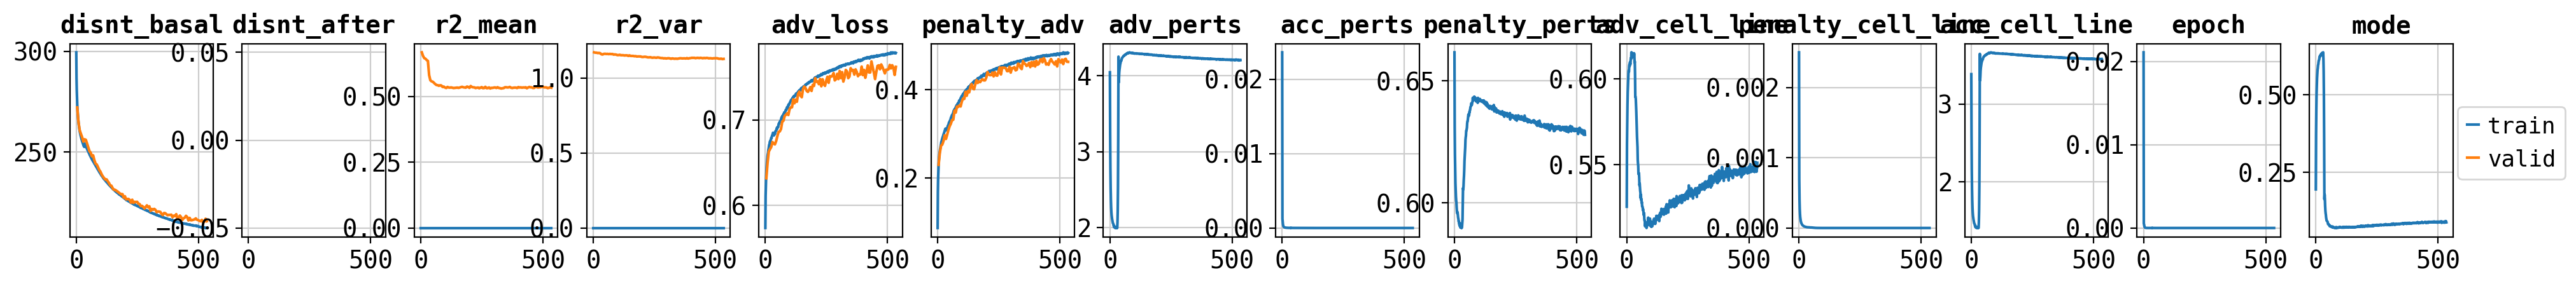

In [13]:
cpa.pl.plot_history(model)

# Load the saved Model

In [14]:
#Restore model 
# model = cpa.CPA.load(dir_path='./pred_cell_Tahoe_CVCL_0546_plate_9_FINAL',
#                      adata=adata,
#                      use_gpu=False)

# cpa.pl.plot_history(model)

## Latent Space Visualization

100%|██████████| 46/46 [00:02<00:00, 16.28it/s]


Epoch 1/2000:   0%|          | 0/2000 [7:04:27<?, ?it/s]


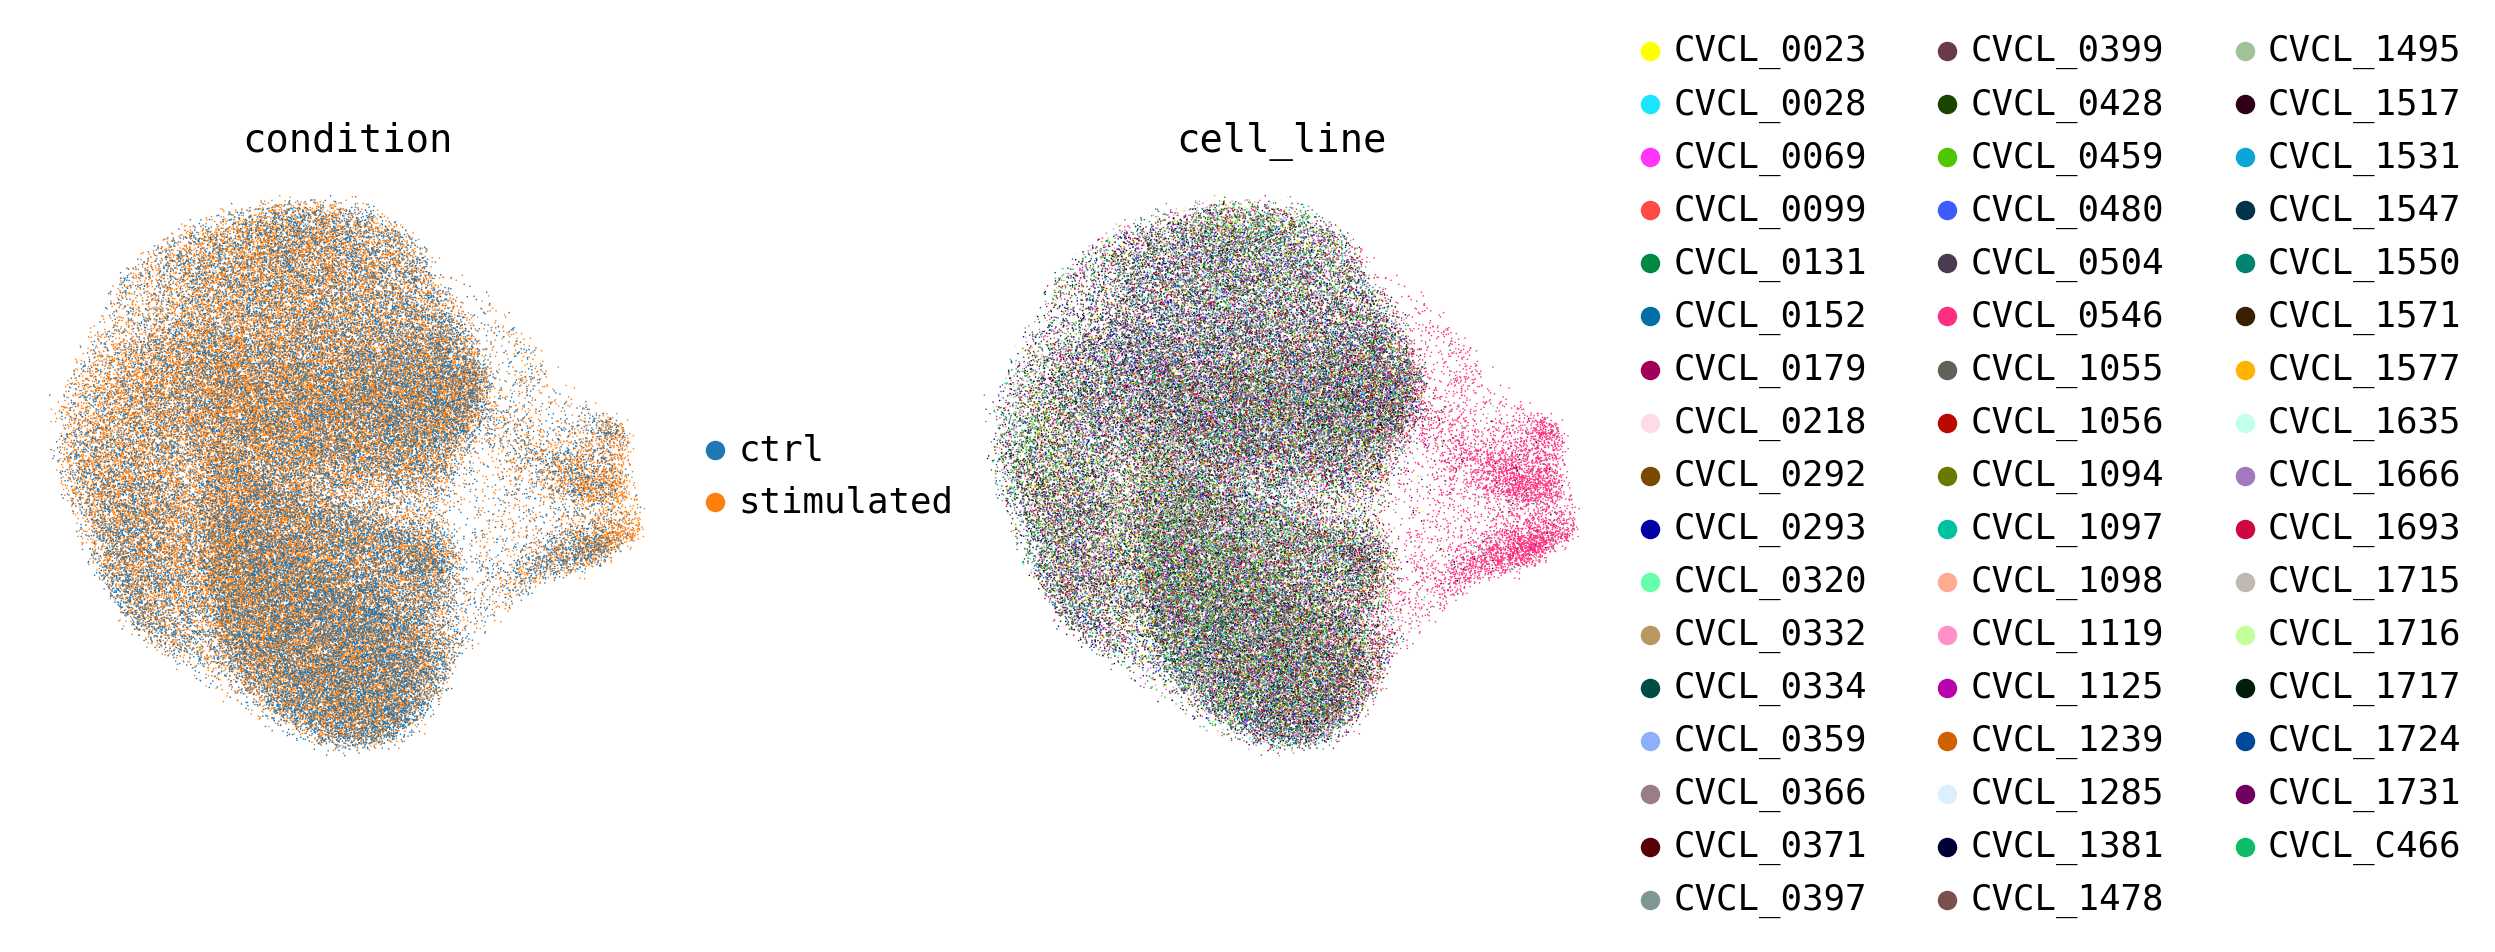

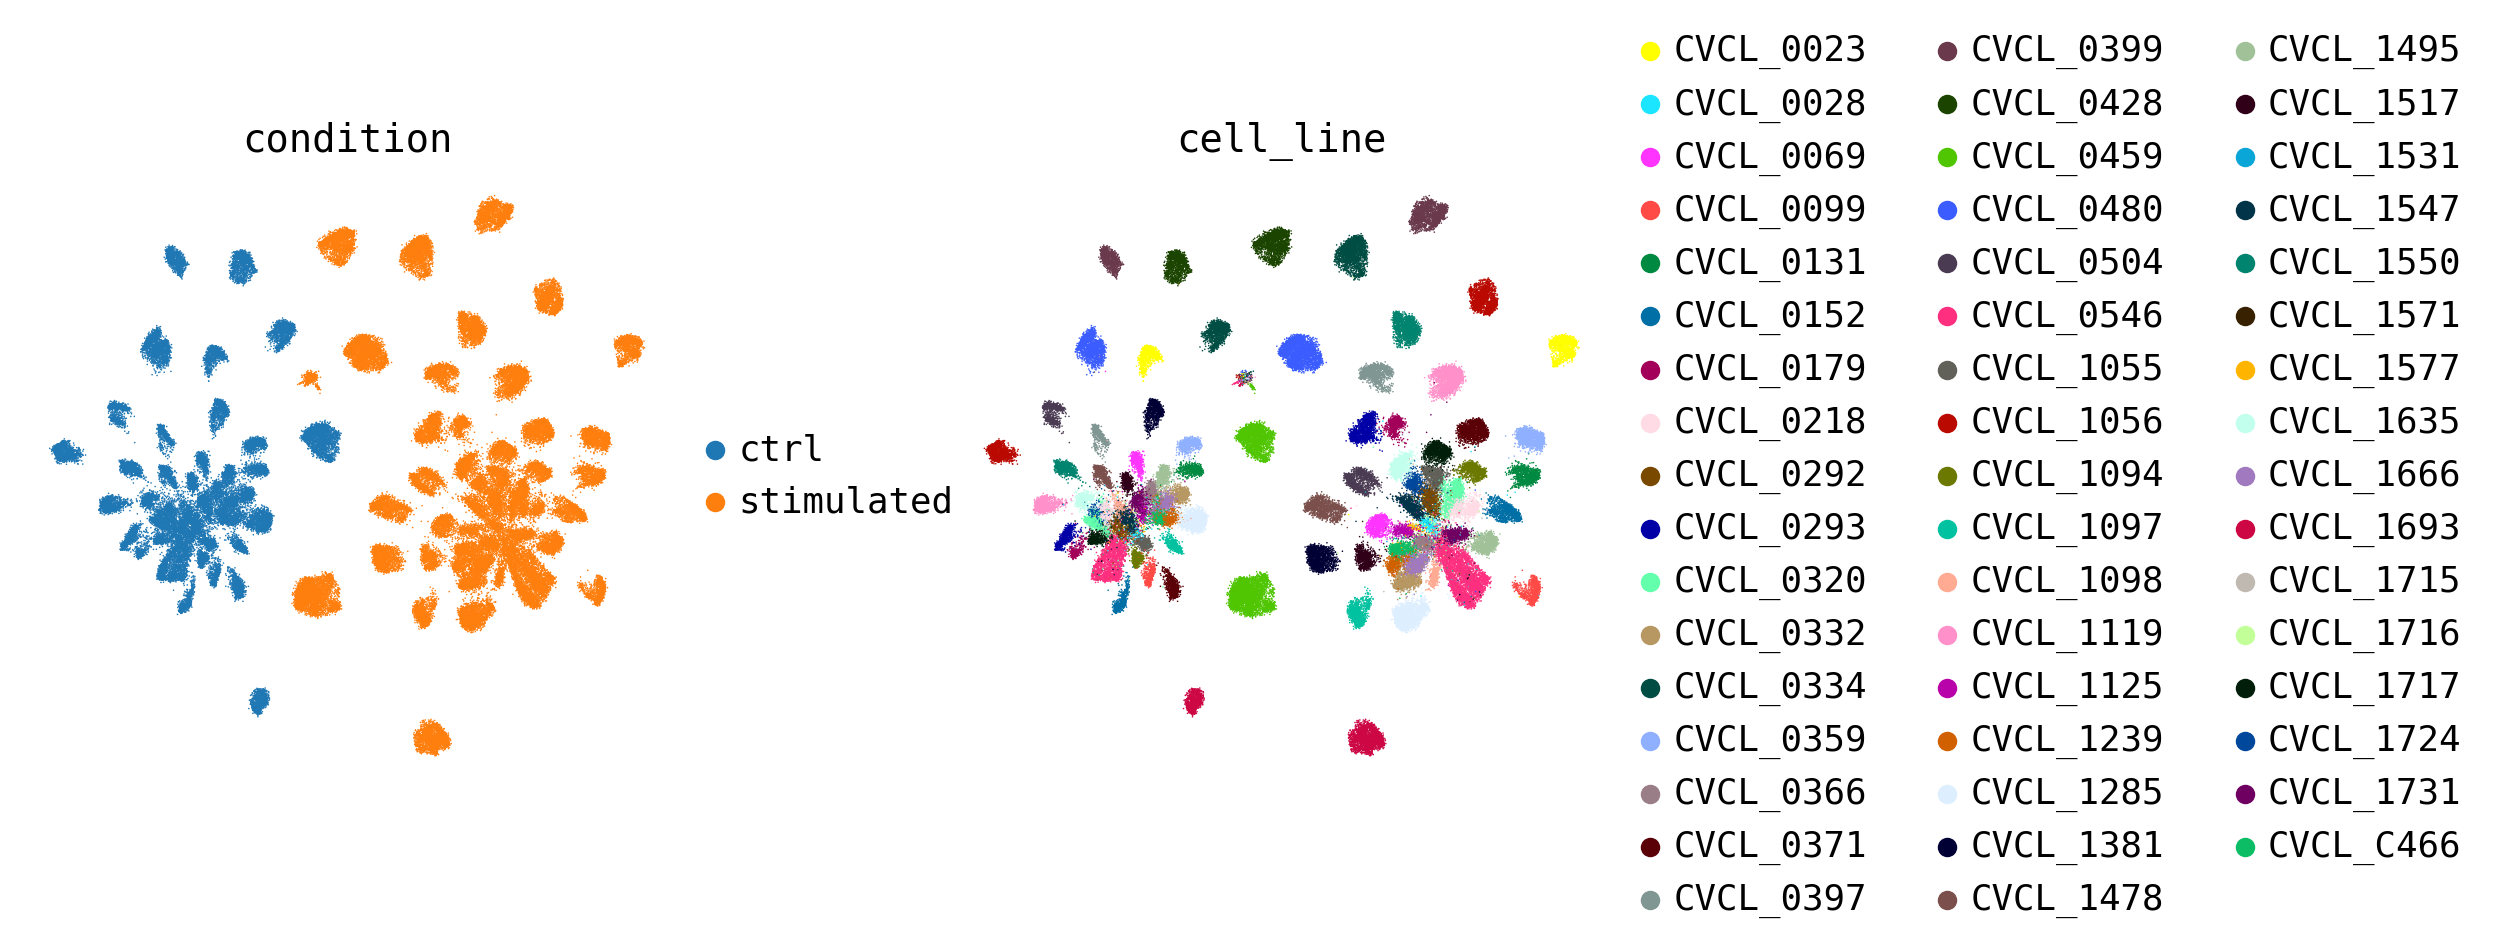

In [15]:
latent_outputs = model.get_latent_representation(adata, batch_size=2048)
latent_outputs.keys()
sc.pp.neighbors(latent_outputs['latent_basal'])
sc.tl.umap(latent_outputs['latent_basal'])
sc.pl.umap(latent_outputs['latent_basal'],
           color=['condition', 'cell_line'],
           frameon=False,
           wspace=0.3)

sc.pp.neighbors(latent_outputs['latent_after'])
sc.tl.umap(latent_outputs['latent_after'])

sc.pl.umap(latent_outputs['latent_after'],
           color=['condition', 'cell_line'],
           frameon=False,
           wspace=0.3)

## Evaluation

In [16]:
model.predict(adata, batch_size=2048)

100%|██████████| 46/46 [00:04<00:00, 10.03it/s]


In [17]:
n_top_degs = [10, 20, 50, None] # None means all genes

results = defaultdict(list)                       #here it saves the performance results
for cat in tqdm(adata.obs['cov_cond'].unique()):  #loops over experimental conditions
    if 'ctrl' not in cat:
        cov, condition = cat.rsplit('_',1)
        cat_adata = adata[adata.obs['cov_cond'] == cat].copy()            #cat_adata: All cells for the current stimulated condition
        print("cat-data:", cat_adata)
        ctrl_adata = adata[adata.obs['cov_cond'] == f'{cov}_ctrl'].copy() #ctrl_adata: All cells for the corresponding control condition
        print("ctr-data:", ctrl_adata)

        #break

        deg_cat = f'{cat}'                                                  #retrive the DEGs
        deg_list = adata.uns['rank_genes_groups'][deg_cat]['names']
        print("deg_list:", deg_list)

        print(f"Number of DEGs in {deg_cat}: {len(deg_list)}")              
        
        x_true = cat_adata.layers['counts']                                 #assign the true vs predicted data
        x_pred = cat_adata.obsm['CPA_pred']
        x_ctrl = ctrl_adata.layers['counts']

        #break
        x_true = np.log1p(x_true)
        x_pred = np.log1p(x_pred)
        x_ctrl = np.log1p(x_ctrl)

        for n_top_deg in n_top_degs:                                        #evaluate the n top DEGs
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'

        
            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            x_ctrl_deg = x_ctrl[:, degs]

            if x_true_deg.shape[0] < 2 or x_pred_deg.shape[0] < 2:
                print(f" Skipping R² computation for {cat}, n_top_deg={n_top_deg} due to insufficient samples.")
                continue
            if x_true_deg.shape[1] != x_pred_deg.shape[1]:
                print(f" Skipping due to mismatch in DEG count: x_true_deg {x_true_deg.shape}, x_pred_deg {x_pred_deg.shape}")
                continue
            if len(degs) == 0:
                print(f" Skipping R² for {cat} @top-{n_top_deg}: No DEGs found")
                continue



            print(f"\n Shapes before R² computation for {cat}, top-{n_top_deg}:")
            print("x_true shape:", x_true.shape)
            print("x_pred shape:", x_pred.shape)
            print("x_ctrl shape:", x_ctrl.shape)
            print("x_true_deg shape:", x_true_deg.shape)
            print("x_pred_deg shape:", x_pred_deg.shape)
            print("x_ctrl_deg shape:", x_ctrl_deg.shape)
            print("degs shape:", degs.shape)
            print("degs indices:", degs)
            print("Number of DEGs used:", len(degs))

            # Convert to 1D numpy arrays (flattened) for compatibility
            # Means
            true_mean = np.asarray(x_true_deg.mean(0)).flatten()
            pred_mean = np.asarray(x_pred_deg.mean(0)).flatten()
            ctrl_mean = np.asarray(x_ctrl_deg.mean(0)).flatten()

            # Variances
            true_var = np.var(x_true_deg.toarray(), axis=0)
            pred_var = np.var(x_pred_deg, axis=0)
            ctrl_var = np.var(x_ctrl_deg.toarray(), axis=0)


            # R² computations
            r2_mean_deg = r2_score(true_mean, pred_mean)
            r2_var_deg = r2_score(true_var, pred_var)

            r2_mean_lfc_deg = r2_score(true_mean - ctrl_mean, pred_mean - ctrl_mean)
            r2_var_lfc_deg = r2_score(true_var - ctrl_var, pred_var - ctrl_var)

            # RMSE metrics
            rmse_mean = np.sqrt(mean_squared_error(true_mean, pred_mean))
            rmse_lfc = np.sqrt(mean_squared_error(true_mean - ctrl_mean, pred_mean - ctrl_mean))

            # Cosine similarity
            cos_sim = cosine_similarity(
                (true_mean - ctrl_mean).reshape(1, -1),
                (pred_mean - ctrl_mean).reshape(1, -1)
            )[0][0]

            # E-distance
            e_dist = energy_distance(true_mean, pred_mean)


            # store results 
            results['condition'].append(condition)
            results['cell_type'].append(cov)
            results['n_top_deg'].append(n_top_deg)
            results['r2_mean_deg'].append(r2_mean_deg)
            results['r2_var_deg'].append(r2_var_deg)
            results['r2_mean_lfc_deg'].append(r2_mean_lfc_deg)
            results['r2_var_lfc_deg'].append(r2_var_lfc_deg)
            results['rmse_mean'].append(rmse_mean)
            results['rmse_lfc'].append(rmse_lfc)
            results['cosine_sim'].append(cos_sim)
            results['e_distance'].append(e_dist)

df = pd.DataFrame(results)  #convert to Dataframe

  1%|          | 1/100 [00:00<00:14,  6.88it/s]

cat-data: AnnData object with n_obs × n_vars = 1033 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 746 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

  2%|▏         | 2/100 [00:00<00:14,  6.87it/s]


 Shapes before R² computation for CVCL_1495_stimulated, top-all:
x_true shape: (1108, 2000)
x_pred shape: (1108, 2000)
x_ctrl shape: (762, 2000)
x_true_deg shape: (1108, 2000)
x_pred_deg shape: (1108, 2000)
x_ctrl_deg shape: (762, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 2713 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'de

  4%|▍         | 4/100 [00:00<00:15,  6.08it/s]


 Shapes before R² computation for CVCL_0480_stimulated, top-all:
x_true shape: (2713, 2000)
x_pred shape: (2713, 2000)
x_ctrl shape: (1657, 2000)
x_true_deg shape: (2713, 2000)
x_pred_deg shape: (2713, 2000)
x_ctrl_deg shape: (1657, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 673 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'd

  5%|▌         | 5/100 [00:00<00:15,  6.27it/s]

cat-data: AnnData object with n_obs × n_vars = 1182 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 589 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

  6%|▌         | 6/100 [00:01<00:16,  5.60it/s]

ctr-data: AnnData object with n_obs × n_vars = 911 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PPP1R15A' 'TNFAIP2' 'CD83' ... 'C15orf48' 'MT1X' 'MT2A']
Number of DEGs in CVCL_1119_stimulated: 2000

 Shapes before R² computation for CVCL_1119_stimulated, top-10:
x_true shape: (1867, 2000)
x_pred shape: (1867, 2000)
x_ctrl shape: (911, 2000)
x_true_deg shape: (1867, 10)
x_p

  8%|▊         | 8/100 [00:01<00:15,  6.07it/s]

cat-data: AnnData object with n_obs × n_vars = 1094 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 556 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

  9%|▉         | 9/100 [00:01<00:15,  5.84it/s]

ctr-data: AnnData object with n_obs × n_vars = 864 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['SMOC1' 'RALYL' 'PPP1R15A' ... 'CGA' 'STC1' 'EGR1']
Number of DEGs in CVCL_1693_stimulated: 2000

 Shapes before R² computation for CVCL_1693_stimulated, top-10:
x_true shape: (1964, 2000)
x_pred shape: (1964, 2000)
x_ctrl shape: (864, 2000)
x_true_deg shape: (1964, 10)
x_pred_de

 11%|█         | 11/100 [00:01<00:14,  6.17it/s]


 Shapes before R² computation for CVCL_0504_stimulated, top-50:
x_true shape: (1315, 2000)
x_pred shape: (1315, 2000)
x_ctrl shape: (777, 2000)
x_true_deg shape: (1315, 50)
x_pred_deg shape: (1315, 50)
x_ctrl_deg shape: (777, 50)
degs shape: (50,)
degs indices: [   0    8   18   19   32   52   56   90  129  171  196  203  207  217
  235  246  281  321  338  343  365  374  386  394  397  415  428  439
  455  470  490  504  505  510  549  575  651  685  763  773  785  792
  827  833  864  943  956 1106 1388 1973]
Number of DEGs used: 50

 Shapes before R² computation for CVCL_0504_stimulated, top-all:
x_true shape: (1315, 2000)
x_pred shape: (1315, 2000)
x_ctrl shape: (777, 2000)
x_true_deg shape: (1315, 2000)
x_pred_deg shape: (1315, 2000)
x_ctrl_deg shape: (777, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 1413 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'dr

 12%|█▏        | 12/100 [00:01<00:13,  6.46it/s]

cat-data: AnnData object with n_obs × n_vars = 979 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 618 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose

 13%|█▎        | 13/100 [00:02<00:14,  6.01it/s]

ctr-data: AnnData object with n_obs × n_vars = 1255 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['COL5A2' 'SOD2' 'PPP1R15A' ... 'MT1E' 'MT1X' 'MT2A']
Number of DEGs in CVCL_0428_stimulated: 2000

 Shapes before R² computation for CVCL_0428_stimulated, top-10:
x_true shape: (2008, 2000)
x_pred shape: (2008, 2000)
x_ctrl shape: (1255, 2000)
x_true_deg shape: (2008, 10)
x_pred

 15%|█▌        | 15/100 [00:02<00:13,  6.38it/s]

cat-data: AnnData object with n_obs × n_vars = 810 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 473 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose

 17%|█▋        | 17/100 [00:02<00:13,  6.21it/s]


 Shapes before R² computation for CVCL_1056_stimulated, top-50:
x_true shape: (1604, 2000)
x_pred shape: (1604, 2000)
x_ctrl shape: (1044, 2000)
x_true_deg shape: (1604, 50)
x_pred_deg shape: (1604, 50)
x_ctrl_deg shape: (1044, 50)
degs shape: (50,)
degs indices: [   1   29   35   69   74   90   98   99  104  108  156  201  203  265
  275  299  314  319  366  385  407  409  427  463  502  561  575  611
  630  641  690  732  740  745  751  763  780  785  808  835  953  965
 1054 1227 1328 1388 1402 1605 1820 1873]
Number of DEGs used: 50

 Shapes before R² computation for CVCL_1056_stimulated, top-all:
x_true shape: (1604, 2000)
x_pred shape: (1604, 2000)
x_ctrl shape: (1044, 2000)
x_true_deg shape: (1604, 2000)
x_pred_deg shape: (1604, 2000)
x_ctrl_deg shape: (1044, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 1428 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count',

 19%|█▉        | 19/100 [00:03<00:16,  4.83it/s]

cat-data: AnnData object with n_obs × n_vars = 1821 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 888 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 20%|██        | 20/100 [00:03<00:15,  5.05it/s]

ctr-data: AnnData object with n_obs × n_vars = 731 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PPP1R15A' 'LINC00511' 'SAMD12' ... 'KLK10' 'HES1' 'AGR2']
Number of DEGs in CVCL_0371_stimulated: 2000

 Shapes before R² computation for CVCL_0371_stimulated, top-10:
x_true shape: (1482, 2000)
x_pred shape: (1482, 2000)
x_ctrl shape: (731, 2000)
x_true_deg shape: (1482, 10)
x_

 22%|██▏       | 22/100 [00:03<00:13,  5.58it/s]

cat-data: AnnData object with n_obs × n_vars = 1171 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 543 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 24%|██▍       | 24/100 [00:04<00:11,  6.38it/s]


 Shapes before R² computation for CVCL_0320_stimulated, top-50:
x_true shape: (1359, 2000)
x_pred shape: (1359, 2000)
x_ctrl shape: (655, 2000)
x_true_deg shape: (1359, 50)
x_pred_deg shape: (1359, 50)
x_ctrl_deg shape: (655, 50)
degs shape: (50,)
degs indices: [  11   18   20   25   32   46   90  112  142  150  151  156  243  286
  289  312  341  343  355  374  378  418  464  582  591  641  644  645
  659  747  751  758  763  796  820  842  861  865  956 1054 1106 1109
 1316 1366 1388 1534 1605 1939 1989 1998]
Number of DEGs used: 50

 Shapes before R² computation for CVCL_0320_stimulated, top-all:
x_true shape: (1359, 2000)
x_pred shape: (1359, 2000)
x_ctrl shape: (655, 2000)
x_true_deg shape: (1359, 2000)
x_pred_deg shape: (1359, 2000)
x_ctrl_deg shape: (655, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 815 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'dru

 25%|██▌       | 25/100 [00:04<00:11,  6.39it/s]

cat-data: AnnData object with n_obs × n_vars = 1301 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 761 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 26%|██▌       | 26/100 [00:04<00:12,  5.98it/s]

ctr-data: AnnData object with n_obs × n_vars = 1262 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['MSC-AS1' 'ROBO1' 'TENM3' ... 'STC1' 'EGR1' 'MT2A']
Number of DEGs in CVCL_1285_stimulated: 2000

 Shapes before R² computation for CVCL_1285_stimulated, top-10:
x_true shape: (1878, 2000)
x_pred shape: (1878, 2000)
x_ctrl shape: (1262, 2000)
x_true_deg shape: (1878, 10)
x_pred_

 27%|██▋       | 27/100 [00:04<00:15,  4.59it/s]

ctr-data: AnnData object with n_obs × n_vars = 2370 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['AUTS2' 'CD109' 'PPP1R15A' ... 'RPS16' 'CXCL8' 'TFPI2']
Number of DEGs in CVCL_0459_stimulated: 2000

 Shapes before R² computation for CVCL_0459_stimulated, top-10:
x_true shape: (3571, 2000)
x_pred shape: (3571, 2000)
x_ctrl shape: (2370, 2000)
x_true_deg shape: (3571, 10)
x_p

 28%|██▊       | 28/100 [00:04<00:14,  5.00it/s]

cat-data: AnnData object with n_obs × n_vars = 713 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 439 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose

 30%|███       | 30/100 [00:05<00:11,  6.15it/s]

ctr-data: AnnData object with n_obs × n_vars = 527 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['PPP1R15A' 'ANK2' 'PDGFC' ... 'HES1' 'CCK' '7SK']
Number of DEGs in CVCL_0099_stimulated: 2000

 Shapes before R² computation for CVCL_0099_stimulated, top-10:
x_true shape: (933, 2000)
x_pred shape: (933, 2000)
x_ctrl shape: (527, 2000)
x_true_deg shape: (933, 10)
x_pred_deg sha

 33%|███▎      | 33/100 [00:05<00:10,  6.49it/s]


 Shapes before R² computation for CVCL_0334_stimulated, top-all:
x_true shape: (2205, 2000)
x_pred shape: (2205, 2000)
x_ctrl shape: (1273, 2000)
x_true_deg shape: (2205, 2000)
x_pred_deg shape: (2205, 2000)
x_ctrl_deg shape: (1273, 2000)
degs shape: (2000,)
degs indices: [   0    1    2 ... 1997 1998 1999]
Number of DEGs used: 2000
cat-data: AnnData object with n_obs × n_vars = 1407 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', '

 36%|███▌      | 36/100 [00:06<00:09,  6.95it/s]


 Shapes before R² computation for CVCL_0397_stimulated, top-20:
x_true shape: (1184, 2000)
x_pred shape: (1184, 2000)
x_ctrl shape: (609, 2000)
x_true_deg shape: (1184, 20)
x_pred_deg shape: (1184, 20)
x_ctrl_deg shape: (609, 20)
degs shape: (20,)
degs indices: [   0   20   90   92  106  109  150  268  338  361  397  418  464  566
  582  674  775 1054 1388 1670]
Number of DEGs used: 20

 Shapes before R² computation for CVCL_0397_stimulated, top-50:
x_true shape: (1184, 2000)
x_pred shape: (1184, 2000)
x_ctrl shape: (609, 2000)
x_true_deg shape: (1184, 50)
x_pred_deg shape: (1184, 50)
x_ctrl_deg shape: (609, 50)
degs shape: (50,)
degs indices: [   0    8   11   16   19   20   69   90   92  106  109  150  171  172
  207  242  265  268  286  338  339  361  365  366  377  379  386  397
  418  459  464  528  566  582  673  674  689  707  724  752  775  780
  827  837 1054 1388 1670 1688 1774 1998]
Number of DEGs used: 50

 Shapes before R² computation for CVCL_0397_stimulated, top-all:
x_

 38%|███▊      | 38/100 [00:06<00:08,  7.71it/s]

ctr-data: AnnData object with n_obs × n_vars = 260 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['AXIN2' 'ANK2' 'CREB5' ... 'KLK10' 'IER3' 'EGR1']
Number of DEGs in CVCL_1724_stimulated: 2000

 Shapes before R² computation for CVCL_1724_stimulated, top-10:
x_true shape: (595, 2000)
x_pred shape: (595, 2000)
x_ctrl shape: (260, 2000)
x_true_deg shape: (595, 10)
x_pred_deg sha

 39%|███▉      | 39/100 [00:06<00:08,  7.28it/s]

cat-data: AnnData object with n_obs × n_vars = 1512 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 764 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 42%|████▏     | 42/100 [00:06<00:07,  8.11it/s]

cat-data: AnnData object with n_obs × n_vars = 502 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 239 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose

 43%|████▎     | 43/100 [00:06<00:07,  7.65it/s]

cat-data: AnnData object with n_obs × n_vars = 1325 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 856 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 46%|████▌     | 46/100 [00:07<00:06,  7.86it/s]

cat-data: AnnData object with n_obs × n_vars = 1064 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 624 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dos

 47%|████▋     | 47/100 [00:07<00:06,  7.90it/s]

cat-data: AnnData object with n_obs × n_vars = 905 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
ctr-data: AnnData object with n_obs × n_vars = 462 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose

100%|██████████| 100/100 [00:07<00:00, 13.12it/s]

ctr-data: AnnData object with n_obs × n_vars = 9 × 2000
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'condition_ID', 'dose', 'log_dose', 'n_counts', 'condition', 'cov_cond', 'split_CVCL_0546', 'CPA_cat', 'CPA_ctrl', '_scvi_condition', '_scvi_cell_line', '_scvi_CPA_cat'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'rank_genes_groups', 'rank_genes_groups_cov', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'perts', 'perts_doses', 'deg_mask', 'deg_mask_r2', 'CPA_pred'
    layers: 'counts'
deg_list: ['FMN1' 'NRP2' 'MCTP1' ... 'TGFBI' 'EFNA5' 'ITGA6']
Number of DEGs in CVCL_1571_stimulated: 2000

 Shapes before R² computation for CVCL_1571_stimulated, top-10:
x_true shape: (21, 2000)
x_pred shape: (21, 2000)
x_ctrl shape: (9, 2000)
x_true_deg shape: (21, 10)
x_pred_deg shape: (2

In [18]:
df


condition  cell_type n_top_deg  r2_mean_deg  r2_var_deg  \
0    stimulated  CVCL_0332        10     0.865419   -0.580479   
1    stimulated  CVCL_0332        20     0.887761   -0.561928   
2    stimulated  CVCL_0332        50     0.888545   -0.215207   
3    stimulated  CVCL_0332       all     0.920563    0.507582   
4    stimulated  CVCL_1495        10     0.746785   -0.793824   
..          ...        ...       ...          ...         ...   
195  stimulated  CVCL_1571       all    -0.364747   -0.134509   
196  stimulated  CVCL_1531        10    -3.912336   -2.587440   
197  stimulated  CVCL_1531        20    -0.669973   -0.133667   
198  stimulated  CVCL_1531        50    -0.293864   -0.061877   
199  stimulated  CVCL_1531       all     0.235717    0.422973   

     r2_mean_lfc_deg  r2_var_lfc_deg  rmse_mean  rmse_lfc  cosine_sim  \
0          -1.308428      -21.842165   0.123211  0.123211    0.893959   
1          -0.881019      -25.588785   0.109341  0.109341    0.922330   
2          -0.778949      -19.650106   0.109820  0.109820    0.903353   
3          -0.693925       -6.684121   0.051716  0.051716    0.710553   
4          -8.029598     -104.255539   0.375930  0.375930   -0.081337   
..               ...             ...        ...       ...         ...   
195        -0.014886        0.315160   0.047712  0.047712    0.699922   
196       -30.004156       -0.742775   0.112258  0.112258    0.940544   
197        -5.646786       -0.624745   0.097801  0.097801    0.936203   
198        -2.697091       -0.750329   0.085683  0.085683    0.925462   
199        -0.420030        0.335060   0.048141  0.048141    0.593491   

     e_distance  
0      0.169389  
1      0.159041  
2      0.136569  
3      0.034312  
4      0.262739  
..          ...  
195    0.053355  
196    0.206132  
197    0.161043  
198    0.155744  
199    0.058706  

[200 rows x 11 columns]

In [19]:
ood_cell_line = "CVCL_0546"  # chosen ood cell line
df_ood = df[df['cell_type'] == ood_cell_line]
print(df_ood)


     condition  cell_type n_top_deg  r2_mean_deg  r2_var_deg  r2_mean_lfc_deg  \
68  stimulated  CVCL_0546        10     0.107767    0.049568        -5.907565   
69  stimulated  CVCL_0546        20     0.306850    0.214033        -6.791255   
70  stimulated  CVCL_0546        50     0.550699    0.438287        -4.066426   
71  stimulated  CVCL_0546       all     0.818687    0.814387        -1.788030   

    r2_var_lfc_deg  rmse_mean  rmse_lfc  cosine_sim  e_distance  
68       -1.643875   0.195747  0.195747    0.907790    0.265668  
69       -1.798344   0.169740  0.169740    0.933564    0.230478  
70       -2.012238   0.128950  0.128950    0.918214    0.155965  
71       -1.360134   0.036298  0.036298    0.831881    0.020749  


In [20]:
print("=== Per Cell Line Metrics ===")
cell_line_summary = df.groupby('cell_type').mean(numeric_only=True)
print(cell_line_summary)

=== Per Cell Line Metrics ===
           r2_mean_deg  r2_var_deg  r2_mean_lfc_deg  r2_var_lfc_deg  \
cell_type                                                             
CVCL_0023     0.734807    0.588230        -2.550034       -8.483404   
CVCL_0028    -0.326406    0.274181        -9.819581       -4.178683   
CVCL_0069     0.621741    0.019457        -4.427804      -15.141938   
CVCL_0099     0.543376    0.511665        -6.656977      -10.175817   
CVCL_0131     0.686758   -0.019539        -4.271921      -14.997843   
CVCL_0152     0.733036    0.545960        -2.157073       -4.704186   
CVCL_0179     0.683234    0.410419        -4.138260       -4.398317   
CVCL_0218     0.455940    0.773399        -6.173545       -3.627631   
CVCL_0292     0.468530    0.515604        -4.812113       -5.055275   
CVCL_0293     0.905724    0.230947        -0.895361       -9.714388   
CVCL_0320     0.332038    0.766622       -11.134220       -2.595605   
CVCL_0332     0.890572   -0.212508        -0.91

In [21]:
print("\n=== Global Average Metrics ===")
global_summary = df.mean(numeric_only=True)
print(global_summary)


=== Global Average Metrics ===
r2_mean_deg         0.324109
r2_var_deg          0.058775
r2_mean_lfc_deg    -4.360455
r2_var_lfc_deg    -12.447438
rmse_mean           0.107694
rmse_lfc            0.107694
cosine_sim          0.865719
e_distance          0.147984
dtype: float64


# Evaluation metrics 

### RMSE 
RMSE is calculated by taking the square root of the average of the squared differences between predicted and actual values. A smaller RMSE indicates better model performance.

In [22]:
mean_rmse_all = df['rmse_mean'].mean()
print("Mean RMSE across all cell lines:", mean_rmse_all)


Mean RMSE across all cell lines: 0.1076942450005284


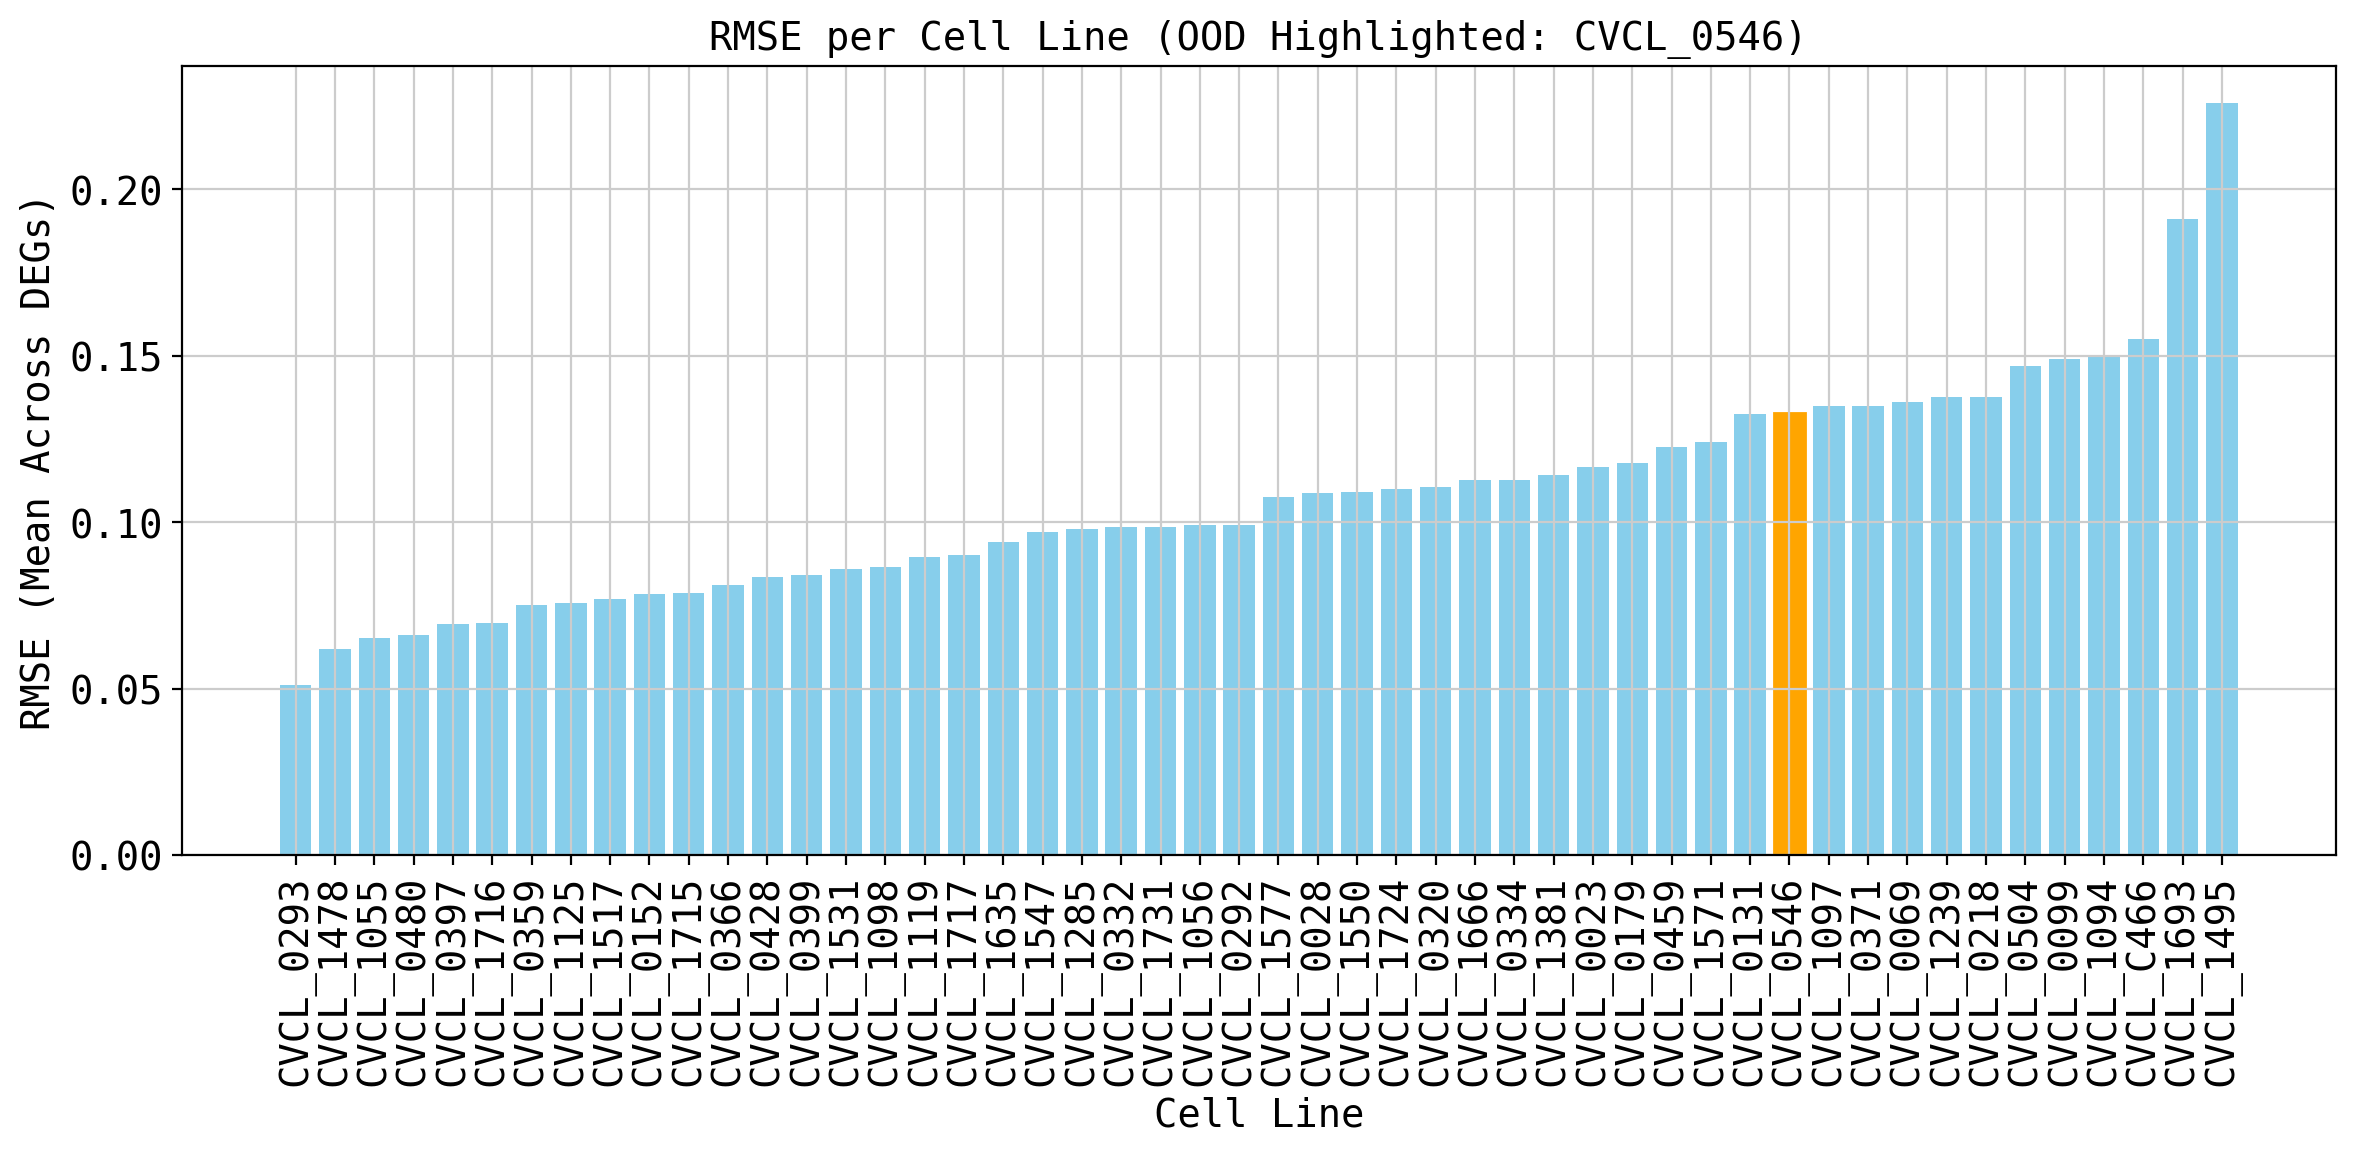

In [23]:

rmse_per_cell = df.groupby('cell_type')['rmse_mean'].mean().sort_values()

plt.figure(figsize=(12, 6))
bars = plt.bar(rmse_per_cell.index, rmse_per_cell.values, color='skyblue')

# Highlight OOD in orange
for bar, cell in zip(bars, rmse_per_cell.index):
    if cell == ood_cell_line:
        bar.set_color('orange')

plt.title(f"RMSE per Cell Line (OOD Highlighted: {ood_cell_line})")
plt.ylabel("RMSE (Mean Across DEGs)")
plt.xlabel("Cell Line")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Cosine similarity 
Measures the angle between two vectors, which compares predicted vs observed log fold-change (LFC) profiles of gene expression. 
-1 ≤ cosine similarity ≤ 1  ( Perfect alignment (predicted and observed profiles have the same direction and shape. )



In [24]:
mean_cosine = df['cosine_sim'].mean()
print("Mean Cosine Similarity across all cell lines:", mean_cosine)


Mean Cosine Similarity across all cell lines: 0.86571866


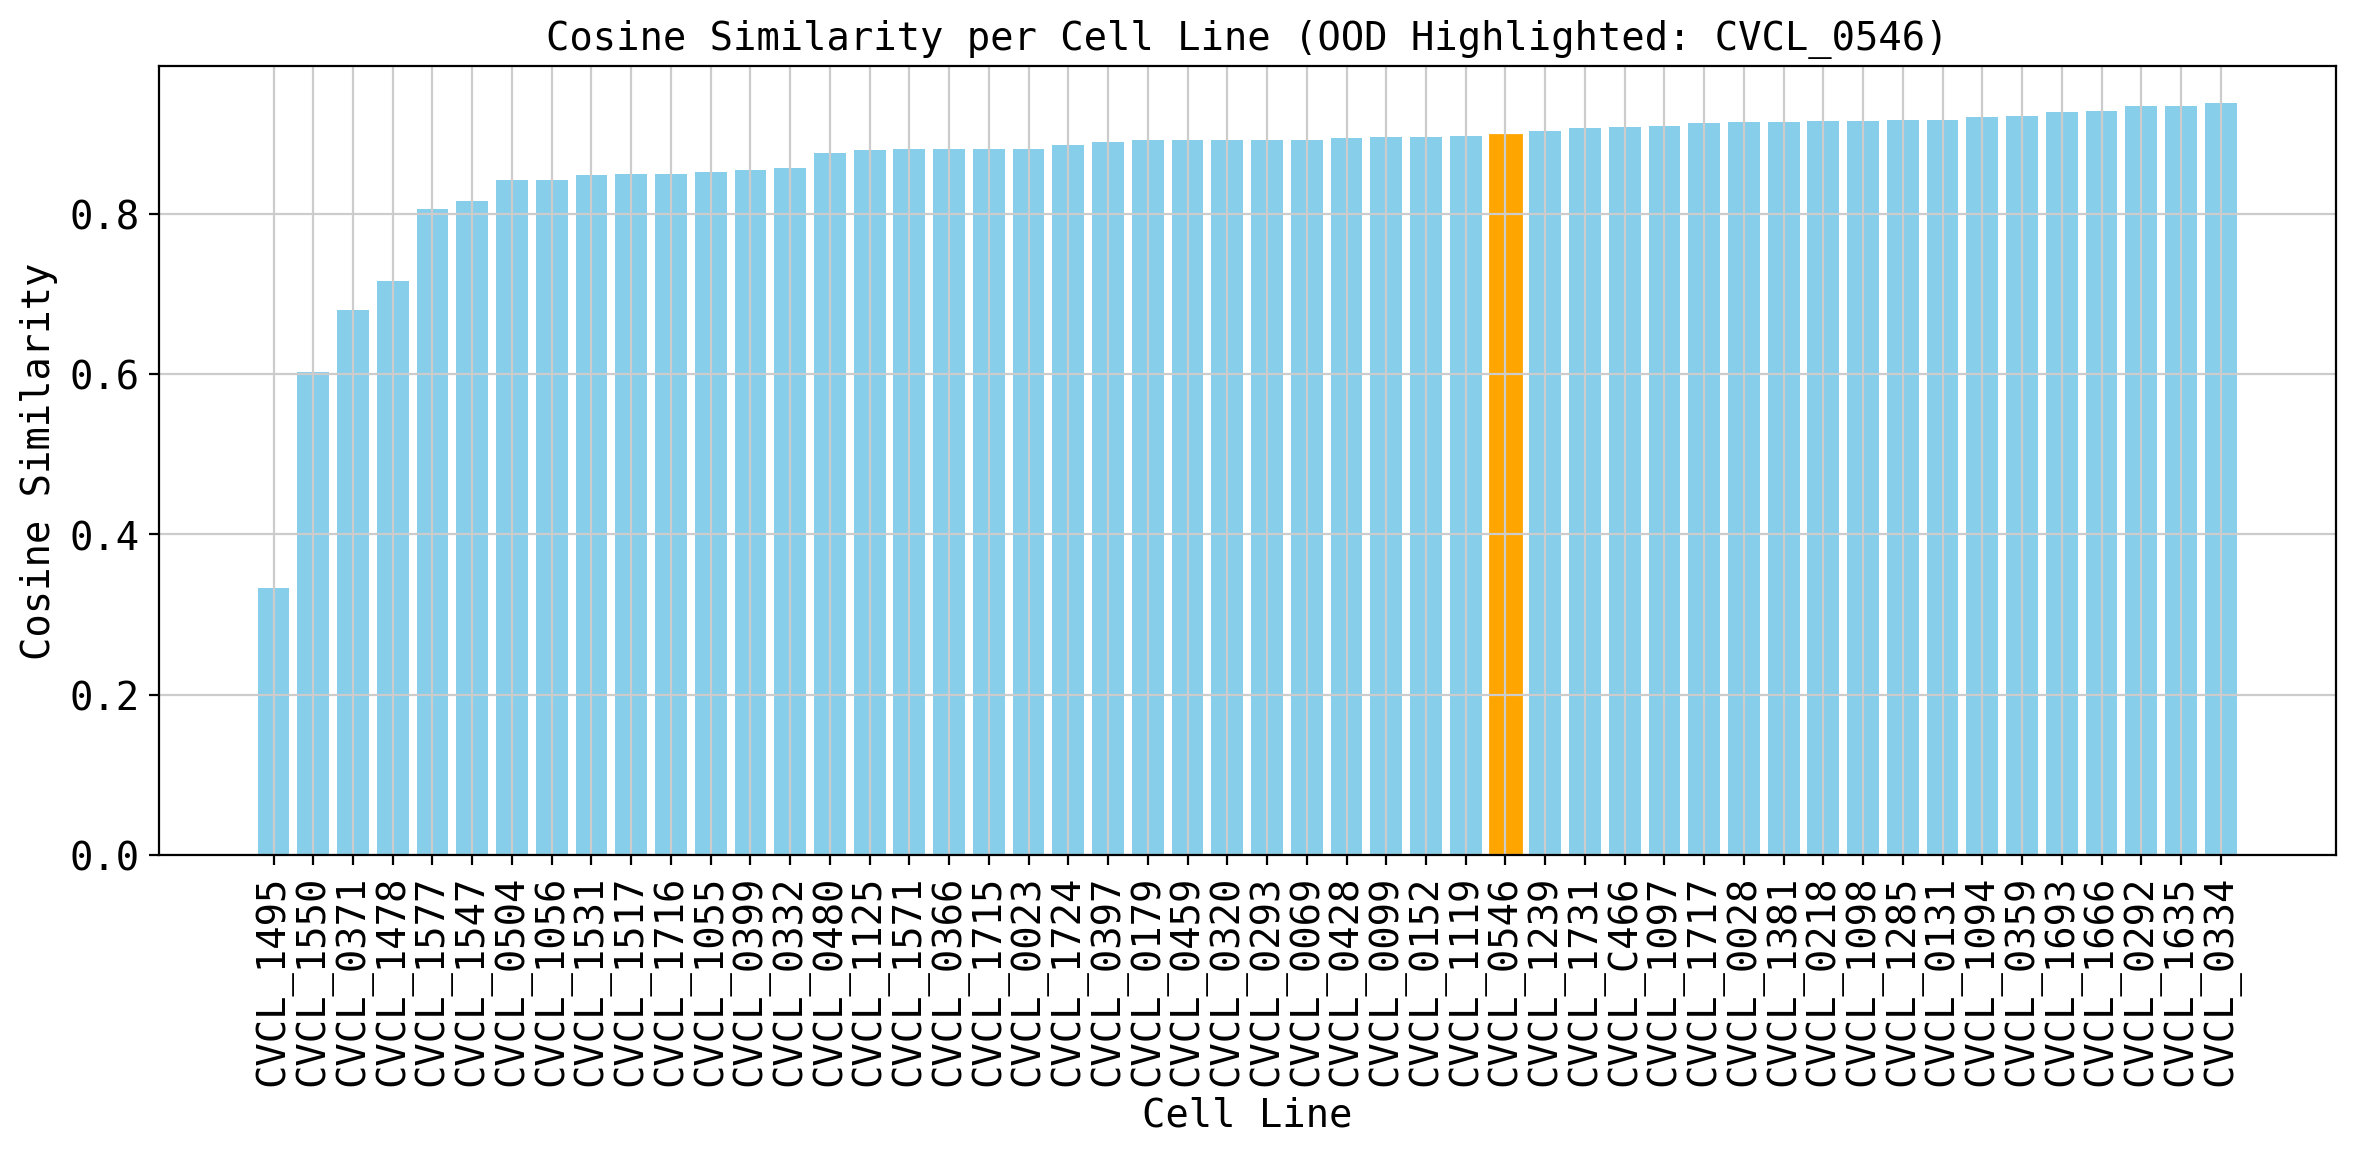

In [25]:
cosine_per_cell = df.groupby('cell_type')['cosine_sim'].mean()
cosine_per_cell = cosine_per_cell.sort_values()

plt.figure(figsize=(12, 6))
bars = plt.bar(cosine_per_cell.index, cosine_per_cell.values, color='skyblue')

# Highlight OOD in orange
for bar, cell in zip(bars, cosine_per_cell.index):
    if cell == ood_cell_line:
        bar.set_color('orange')

plt.title(f"Cosine Similarity per Cell Line (OOD Highlighted: {ood_cell_line})")
plt.ylabel("Cosine Similarity")
plt.xlabel("Cell Line")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### R² score 
(coefficient of determination) measures how much of the variance in the observed data is explained by the predictions.

R² > 0.5: Generally good alignment.

R²=Perfect prediction (predicted values match true values exactly).

Mean R² (mean expression) across all cell lines: 0.3241087067127228


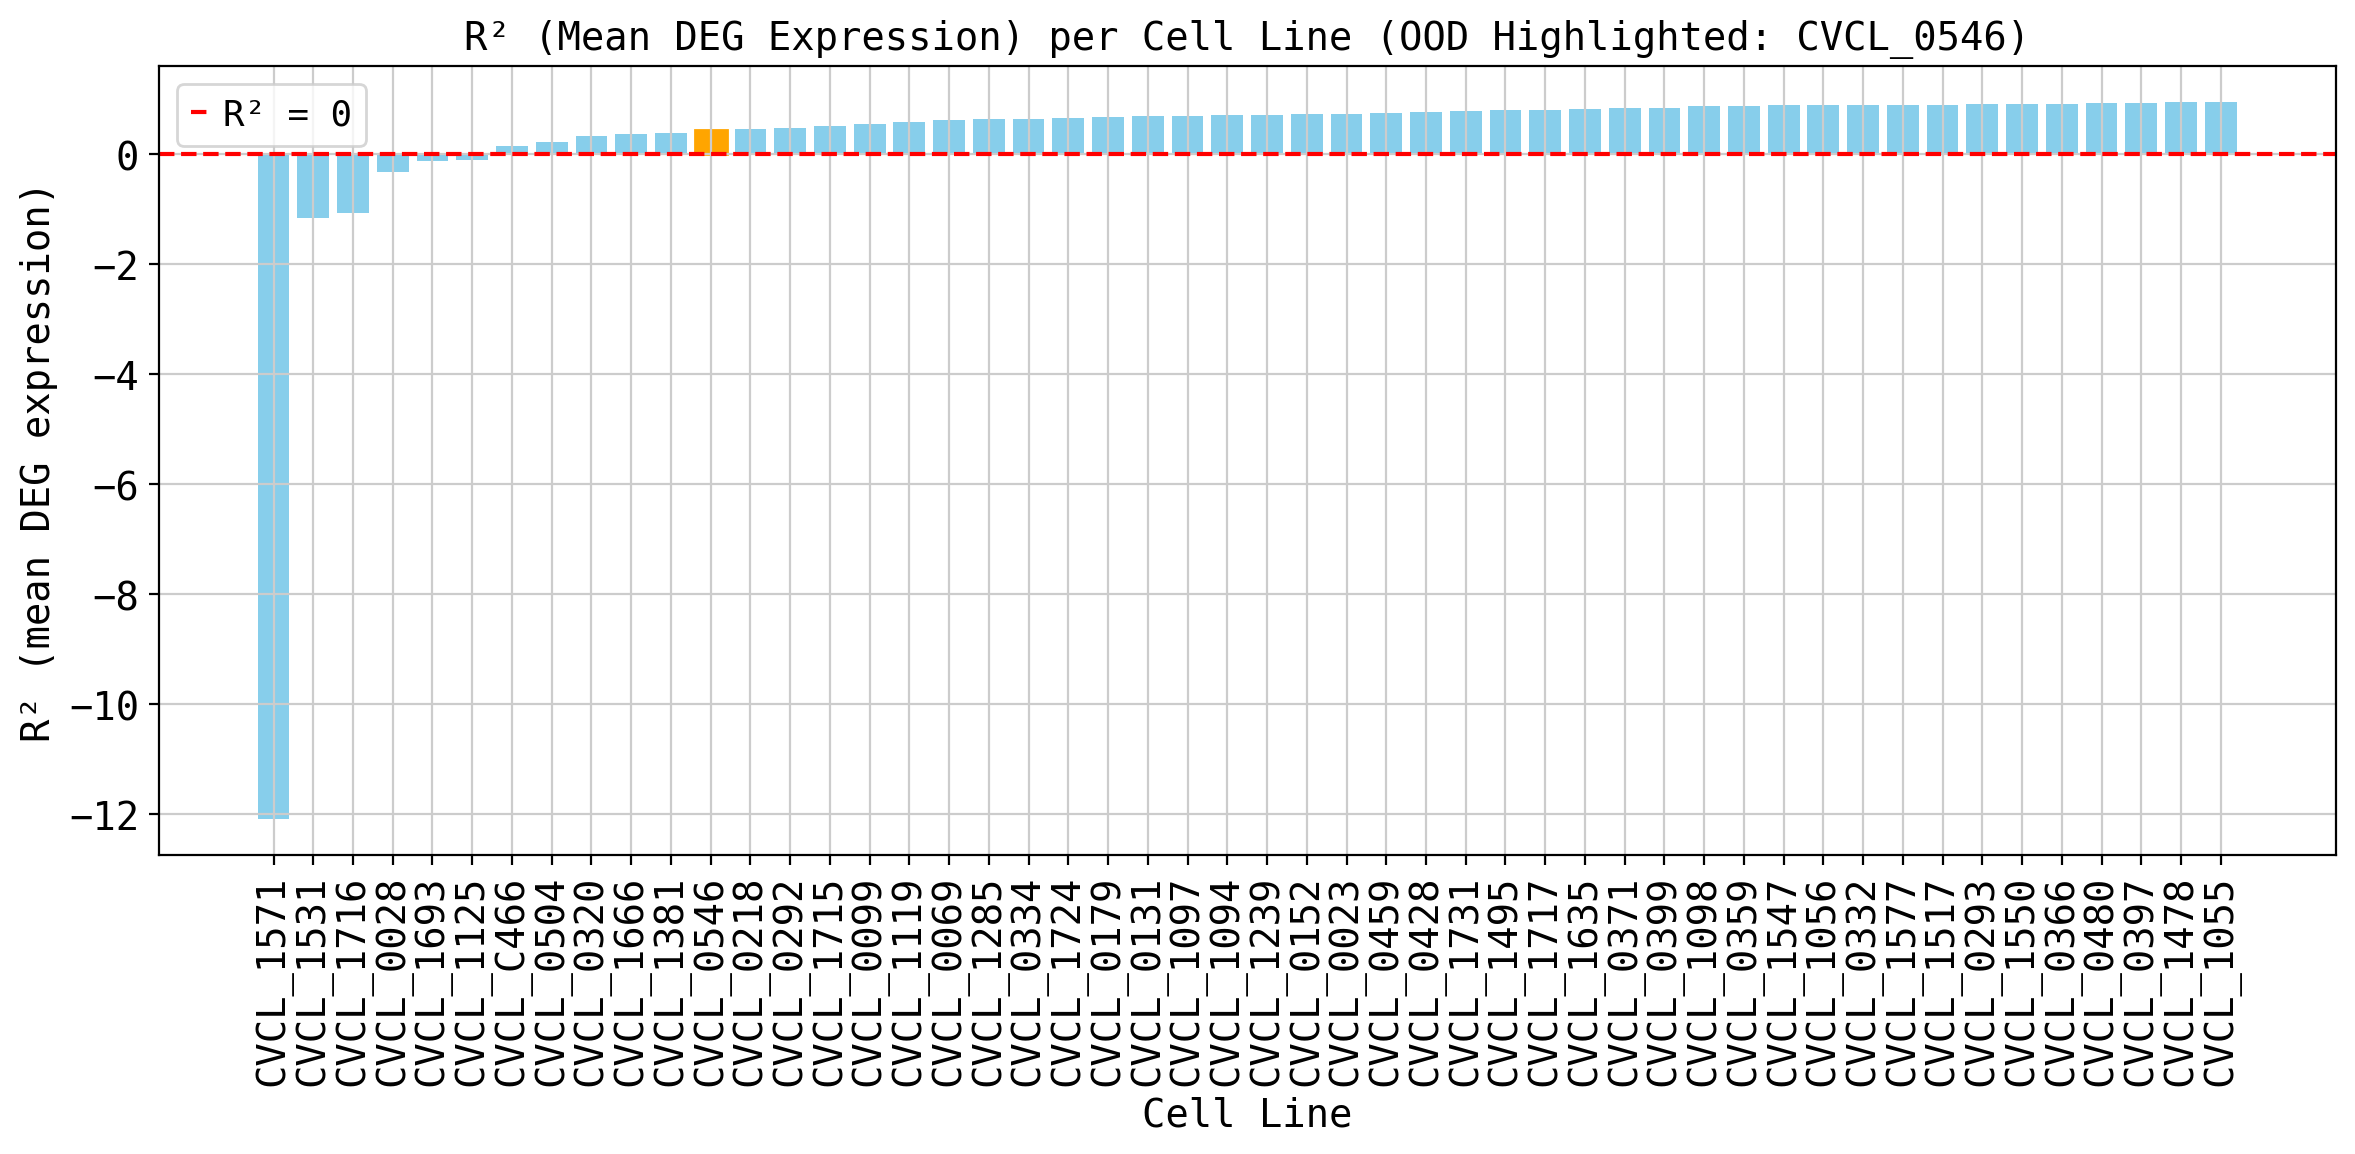

In [26]:
mean_r2_mean_deg = df['r2_mean_deg'].mean()
print("Mean R² (mean expression) across all cell lines:", mean_r2_mean_deg)
r2_mean_per_cell = df.groupby('cell_type')['r2_mean_deg'].mean().sort_values()

plt.figure(figsize=(12, 6))
bars = plt.bar(r2_mean_per_cell.index, r2_mean_per_cell.values, color='skyblue')

# Highlight OOD cell line
ood_cell_line = 'CVCL_0546'
for bar, cell in zip(bars, r2_mean_per_cell.index):
    if cell == ood_cell_line:
        bar.set_color('orange')

plt.axhline(0, color='red', linestyle='--', label='R² = 0')
plt.title(f"R² (Mean DEG Expression) per Cell Line (OOD Highlighted: {ood_cell_line})")
plt.ylabel("R² (mean DEG expression)")
plt.xlabel("Cell Line")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


###  E-distance (energy distance)

Distance between two probability distributions (e.g., predicted vs observed gene expression distributions).

Smaller values close to 0 indicate good alighnment.

Mean E-Distance across all cell lines: 0.14798394006627105


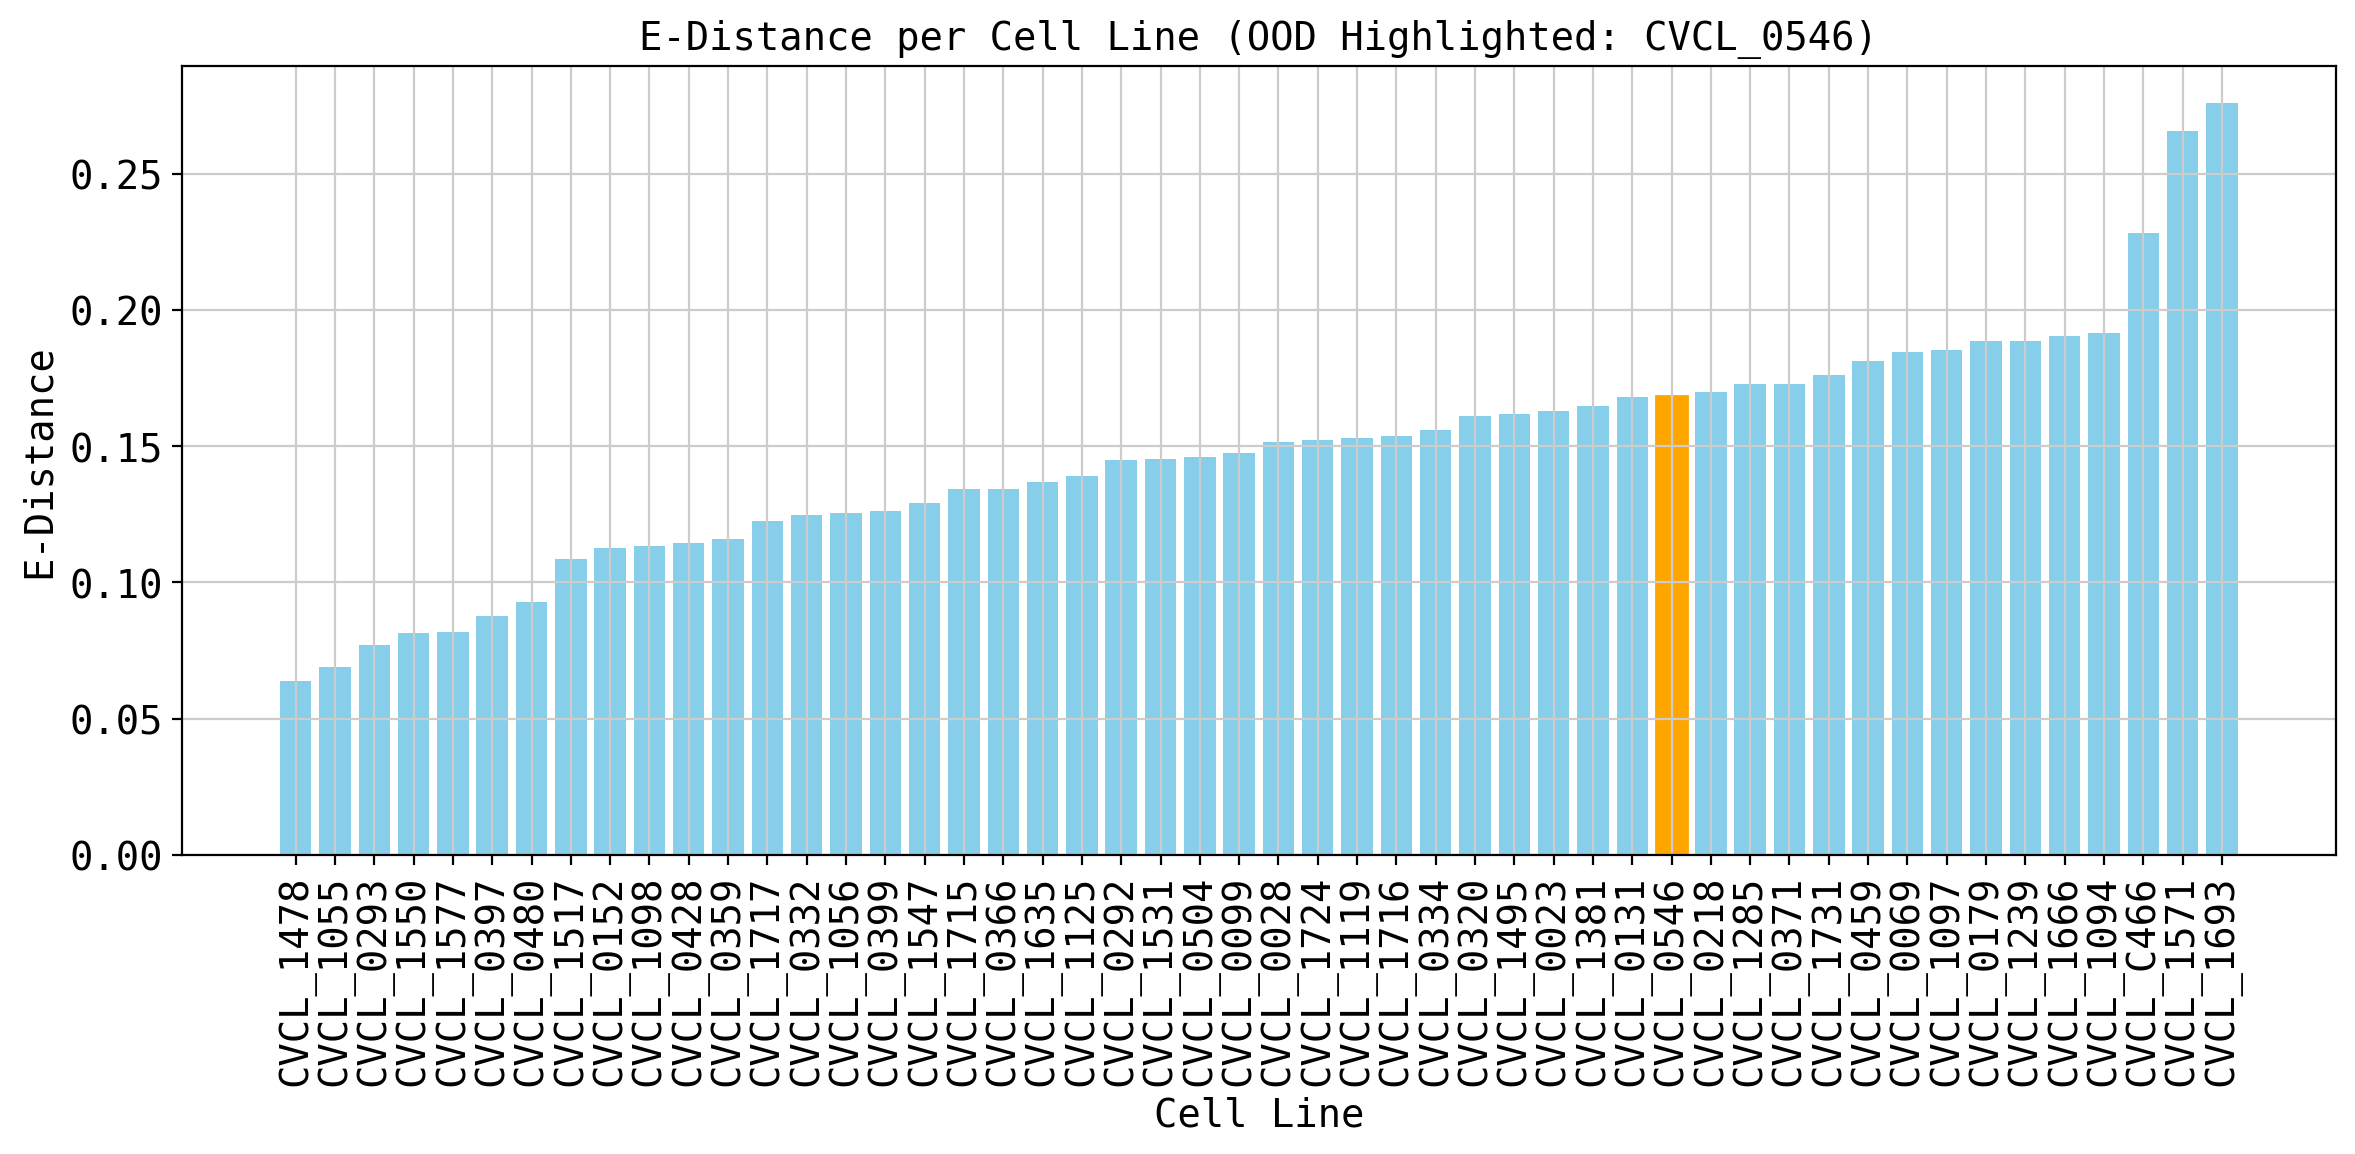

In [27]:
mean_e_dist = df['e_distance'].mean()
print("Mean E-Distance across all cell lines:", mean_e_dist)
e_dist_per_cell = df.groupby('cell_type')['e_distance'].mean()
e_dist_per_cell = e_dist_per_cell.sort_values()

plt.figure(figsize=(12, 6))
bars = plt.bar(e_dist_per_cell.index, e_dist_per_cell.values, color='skyblue')

# Highlight OOD cell line
for bar, cell in zip(bars, e_dist_per_cell.index):
    if cell == ood_cell_line:
        bar.set_color('orange')

plt.title(f"E-Distance per Cell Line (OOD Highlighted: {ood_cell_line})")
plt.ylabel("E-Distance")
plt.xlabel("Cell Line")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Visialization of results

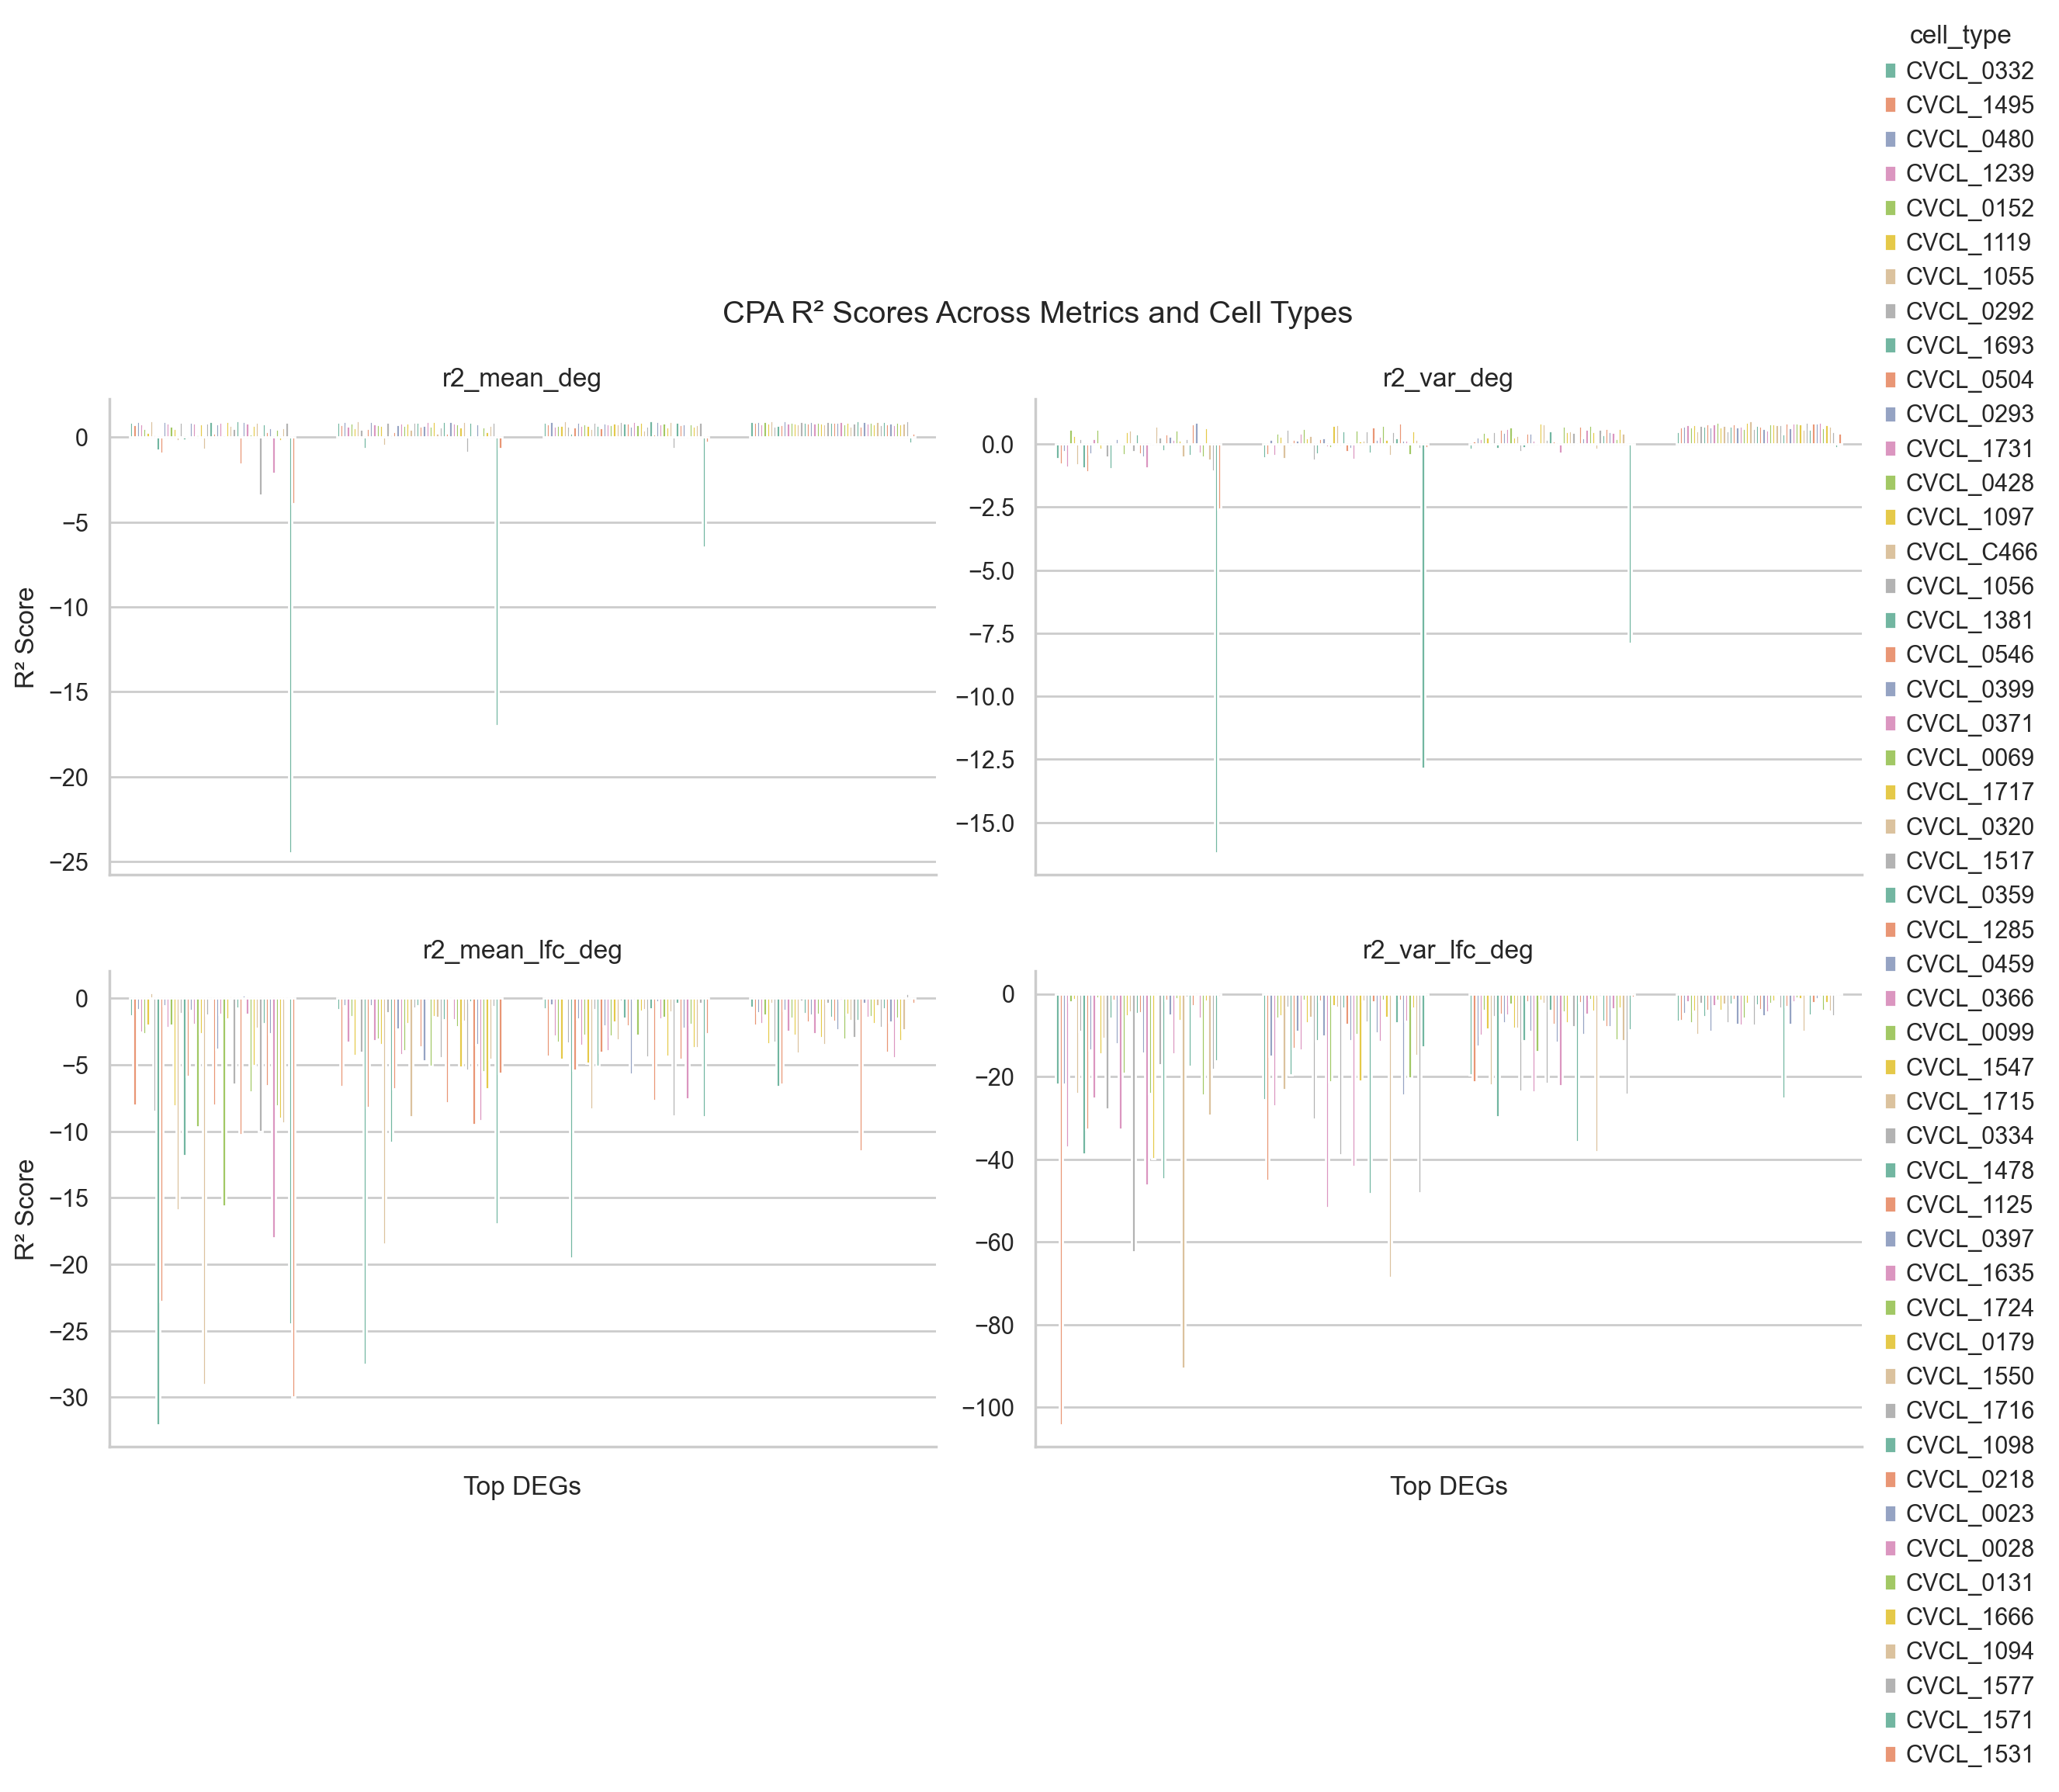

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named `df`

# Convert to long format
df_melted = df.melt(
    id_vars=["condition", "cell_type", "n_top_deg"],
    value_vars=[
        "r2_mean_deg", "r2_var_deg",
        "r2_mean_lfc_deg", "r2_var_lfc_deg"
    ],
    var_name="metric",
    value_name="R2_score"
)

# Plot
sns.set(style="whitegrid", context="notebook")
g = sns.catplot(
    data=df_melted,
    x="n_top_deg", y="R2_score",
    hue="cell_type",
    col="metric",
    kind="bar",
    col_wrap=2,
    height=4, aspect=1.5,
    palette="Set2",
    sharey=False
)

g.set_titles("{col_name}")
g.set_axis_labels("Top DEGs", "R² Score")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("CPA R² Scores Across Metrics and Cell Types")
plt.show()


## Plotting: Compare OOD vs ID performance

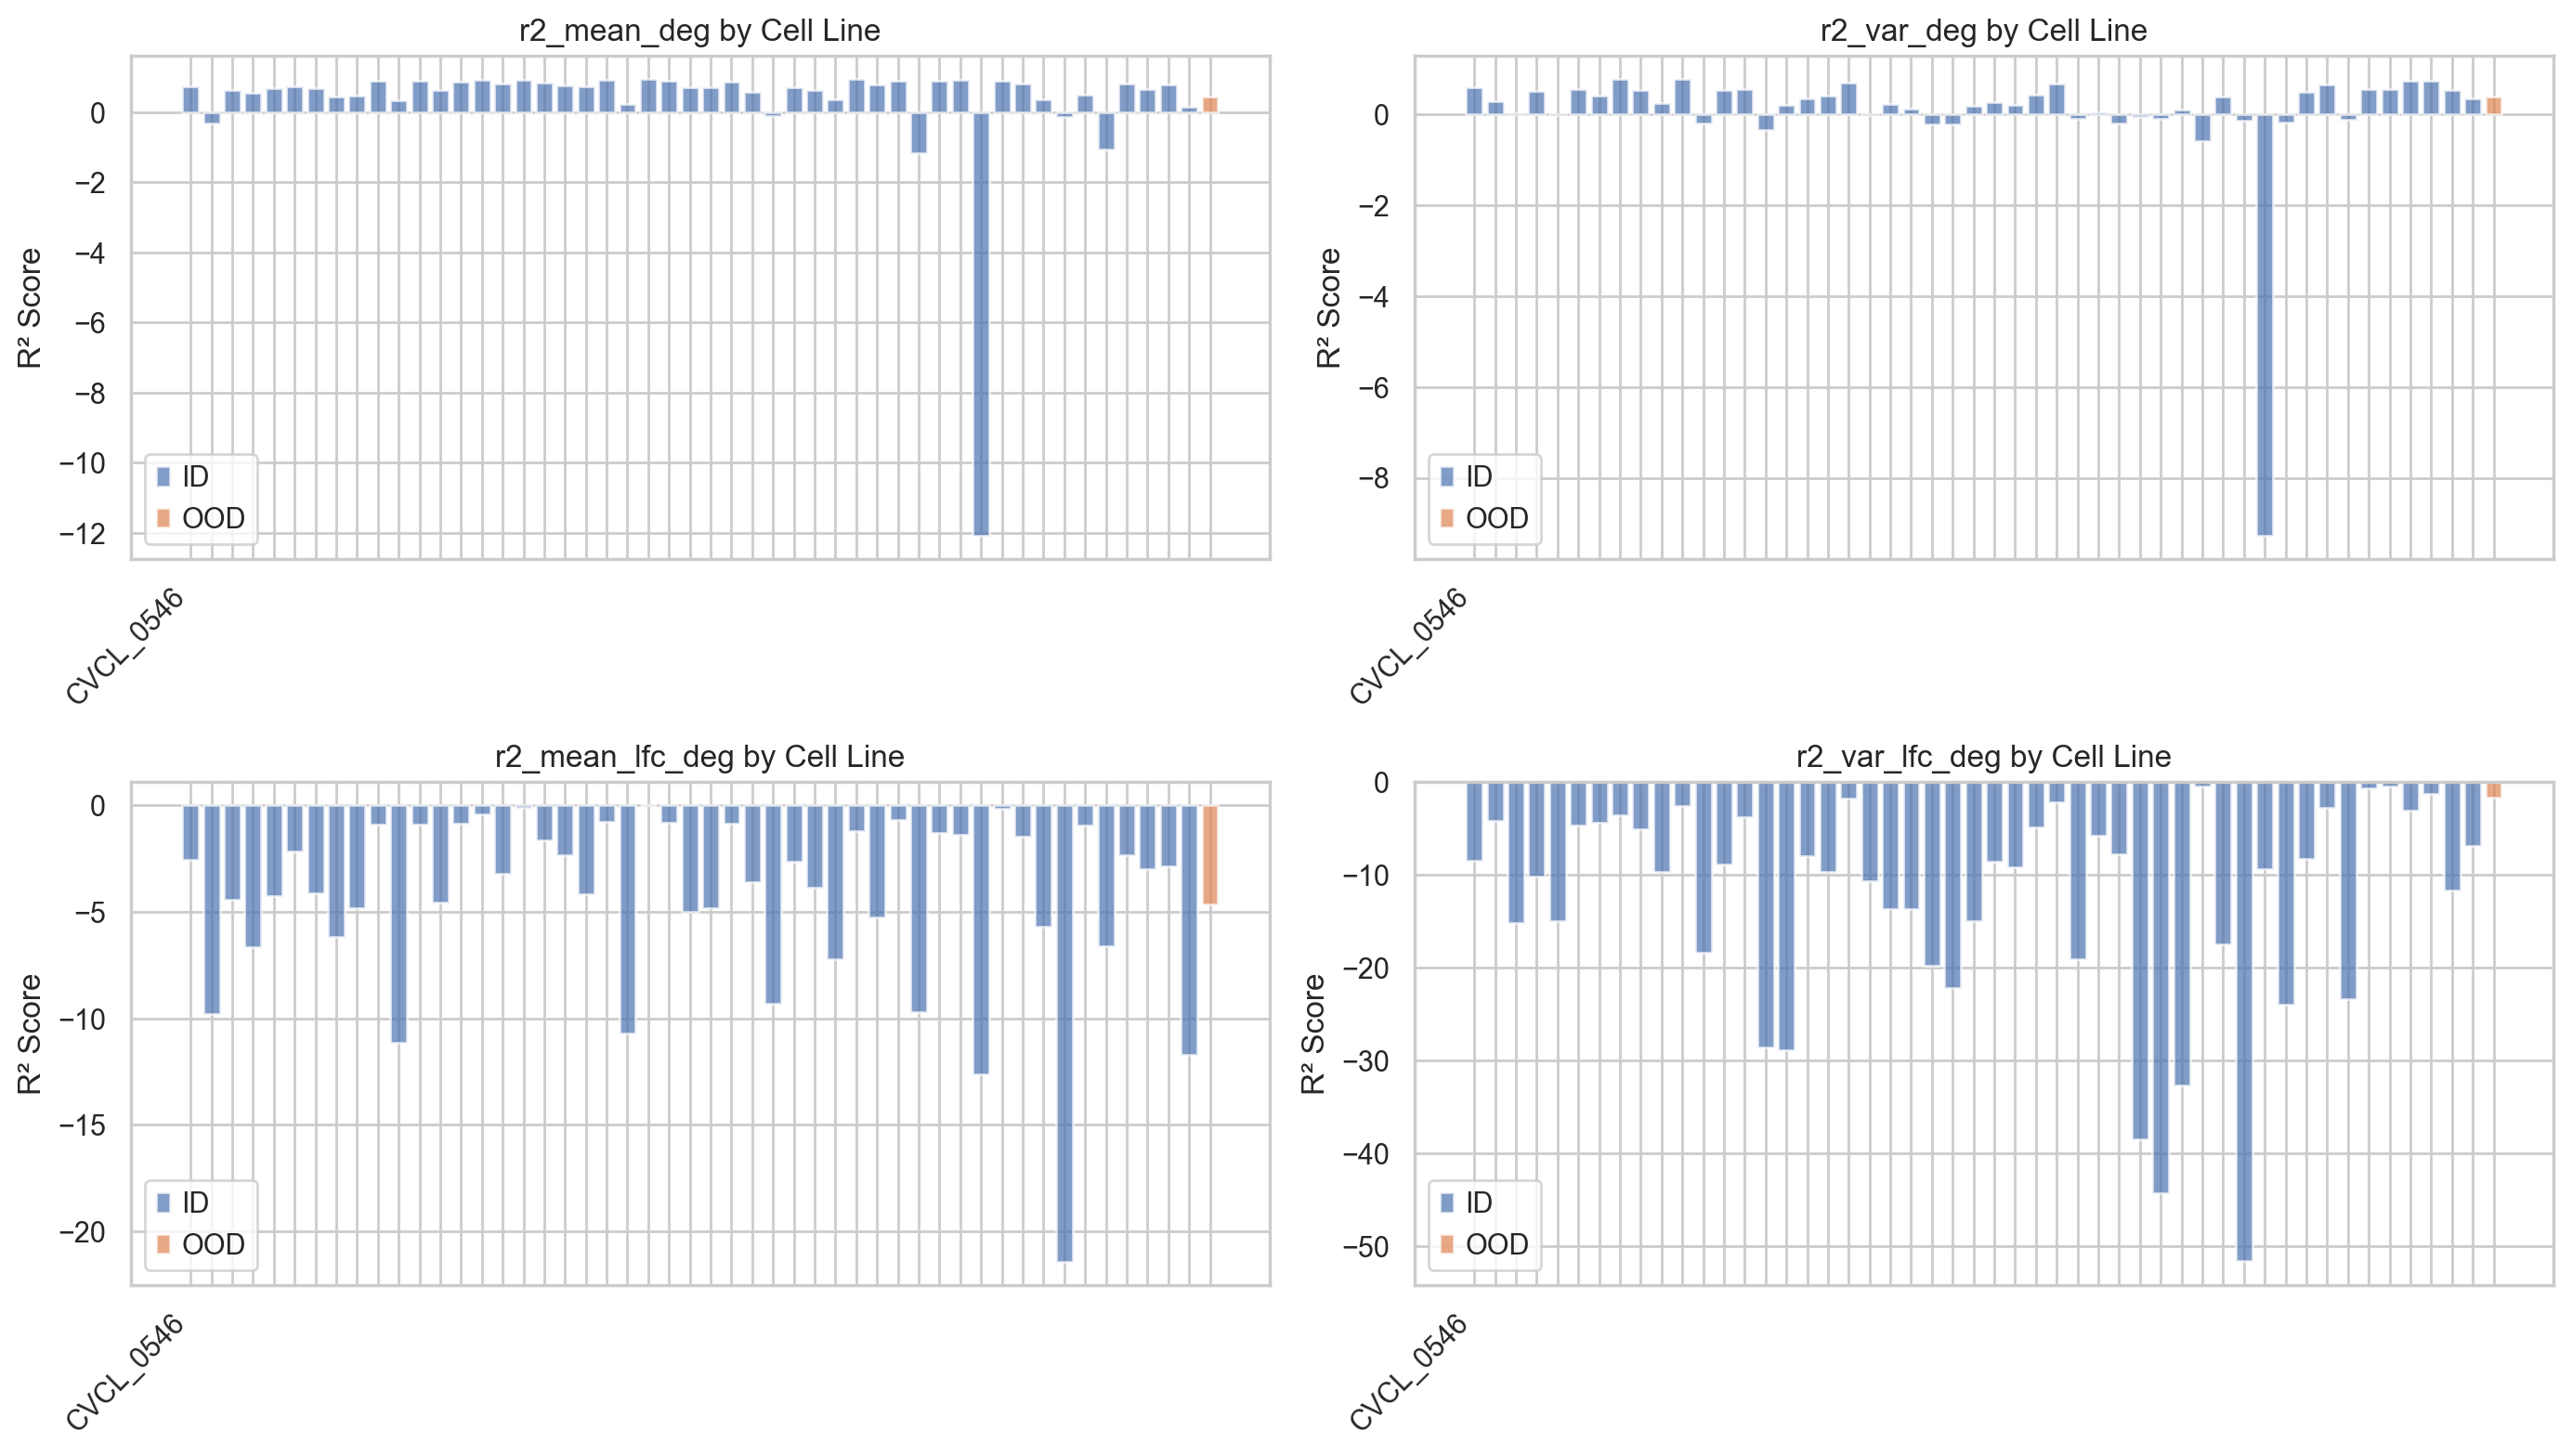

In [29]:
# Assume df already exists and contains R² results
# Define OOD cell line
ood_cell_line = "CVCL_0546"

# Mark whether each row is OOD or not
df['is_ood'] = df['cell_type'] == ood_cell_line

# Define metrics to visualize
metrics = ['r2_mean_deg', 'r2_var_deg', 'r2_mean_lfc_deg', 'r2_var_lfc_deg']
ncols = 2
nrows = (len(metrics) + 1) // ncols

# Create subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
axs = axs.flatten()

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axs[i]
    summary = df.groupby(['is_ood', 'cell_type'])[metric].mean().reset_index()
    summary['OOD status'] = summary['is_ood'].map({True: 'OOD', False: 'ID'})
    
    for ood_status, group in summary.groupby('OOD status'):
        ax.bar(group['cell_type'], group[metric], label=ood_status, alpha=0.7)

    ax.set_title(f"{metric} by Cell Line")
    ax.set_ylabel("R² Score")
    ax.set_xticklabels(group['cell_type'], rotation=45, ha='right')
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


### CPA Prediction vs True for Stimulated per Cell Line
Diagonal alignment → Good agreement between CPA predictions and true data.

Points above the line → CPA overestimates gene expression.

Points below the line → CPA underestimates gene expression.

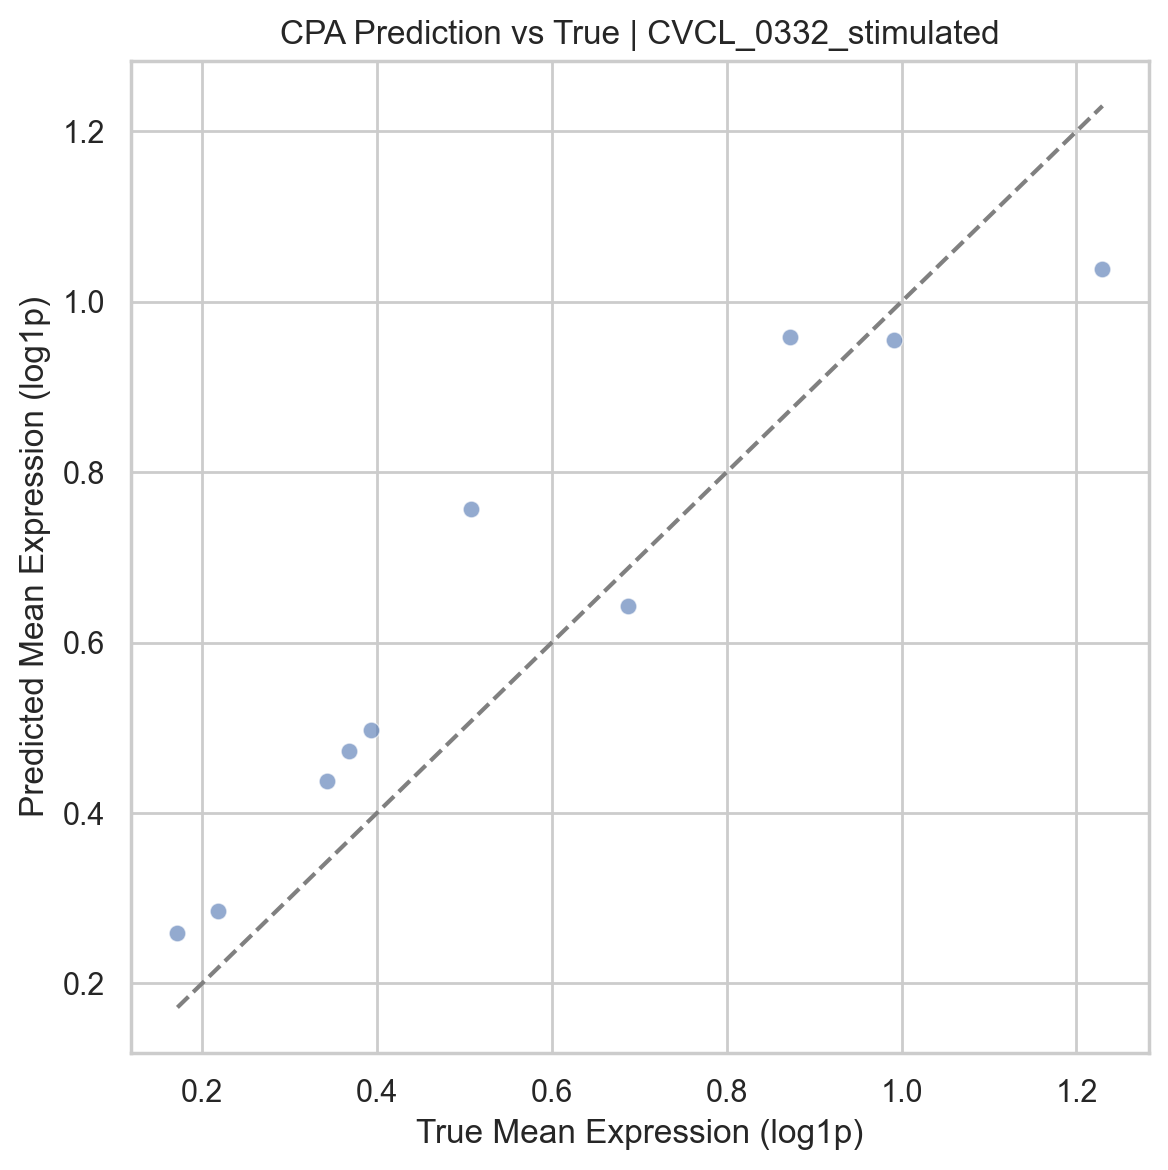

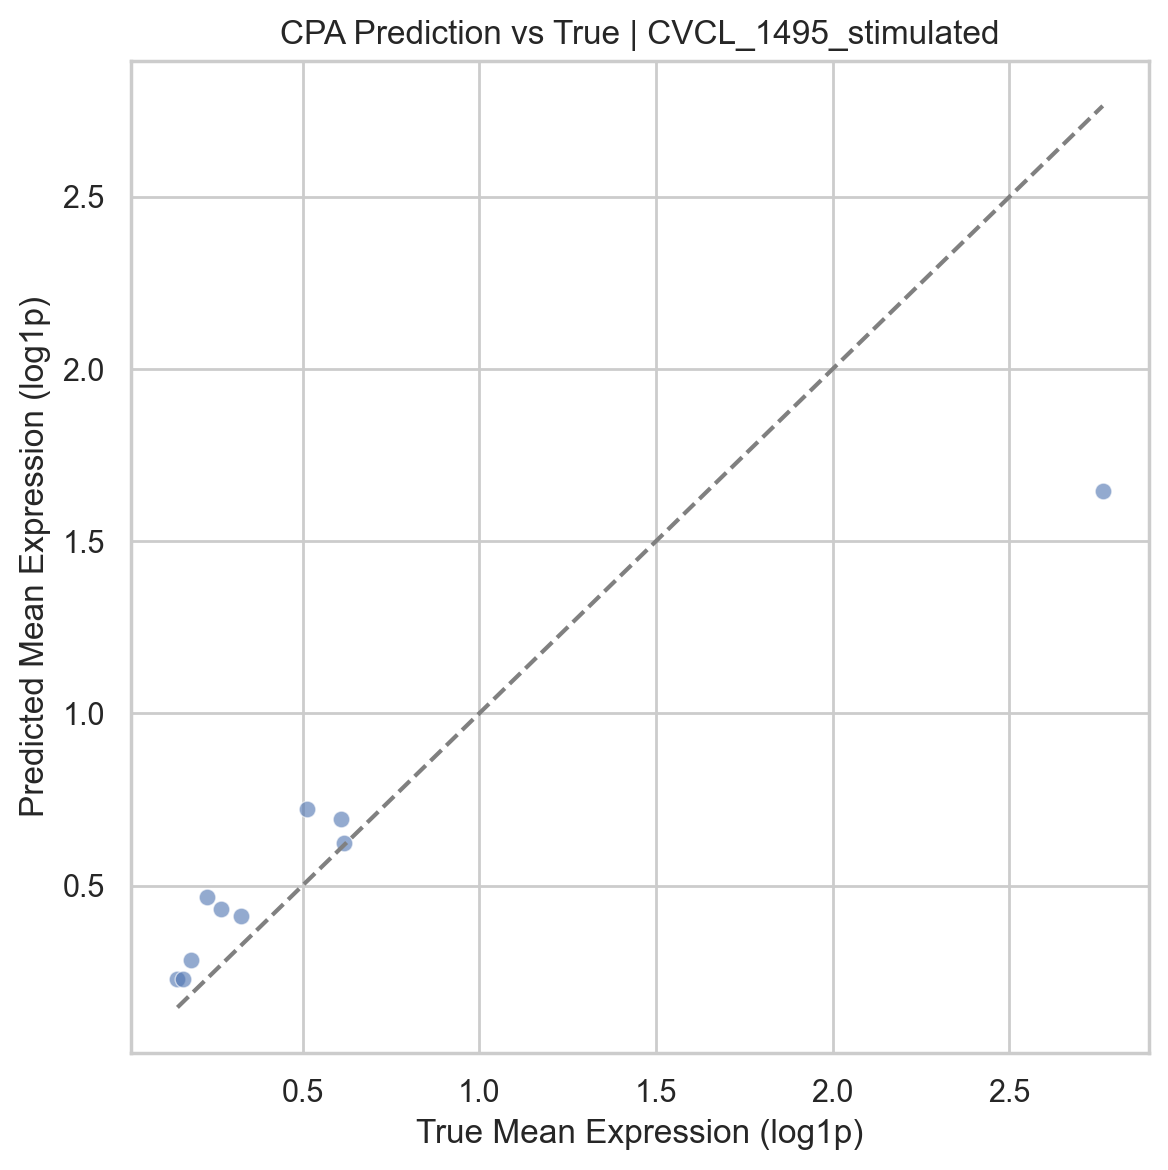

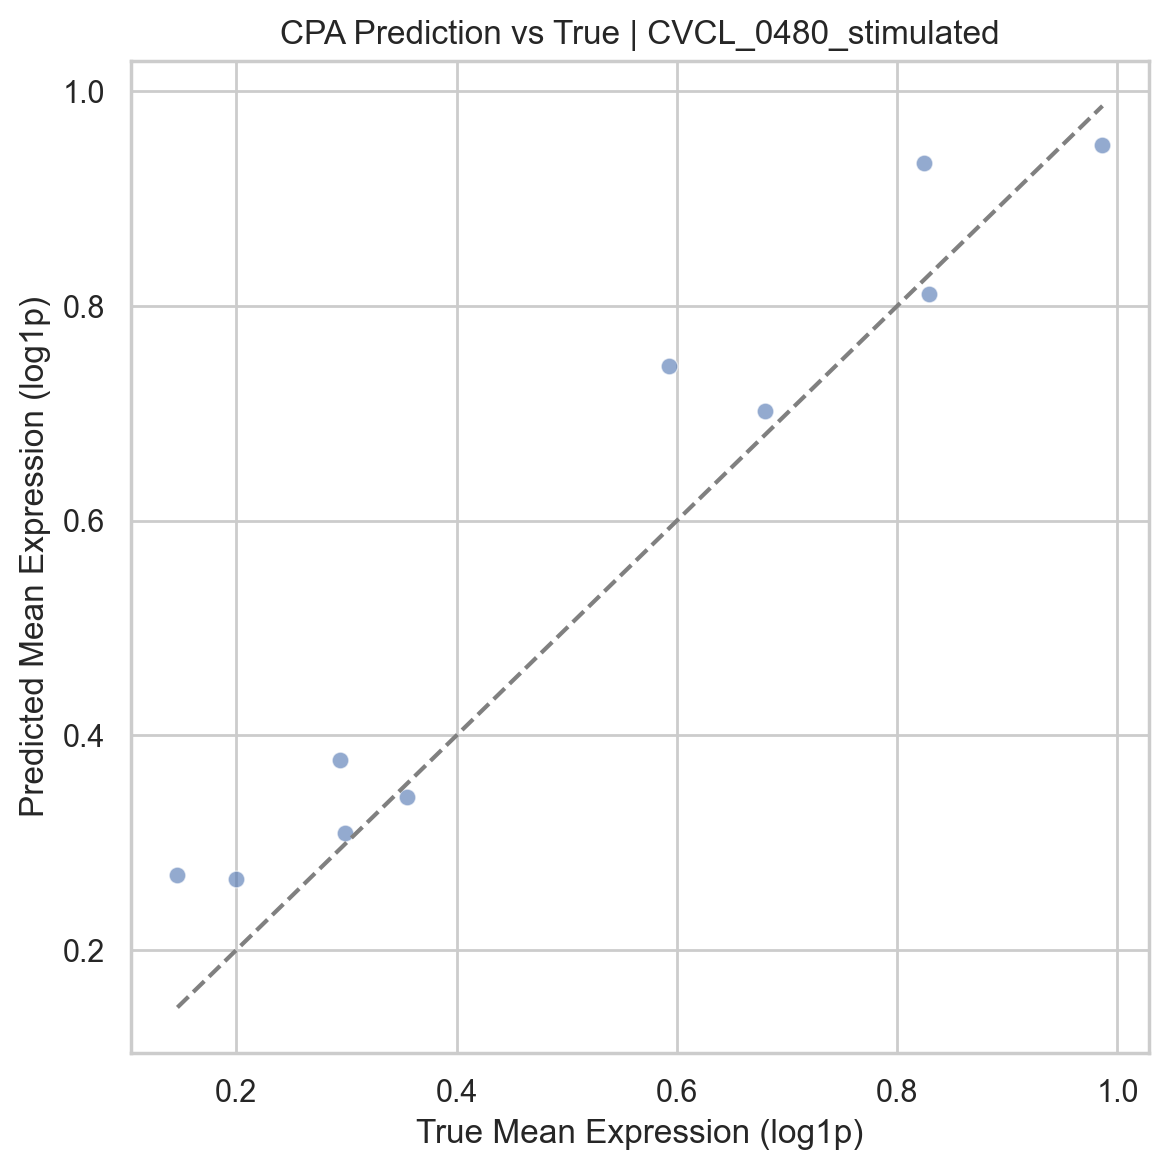

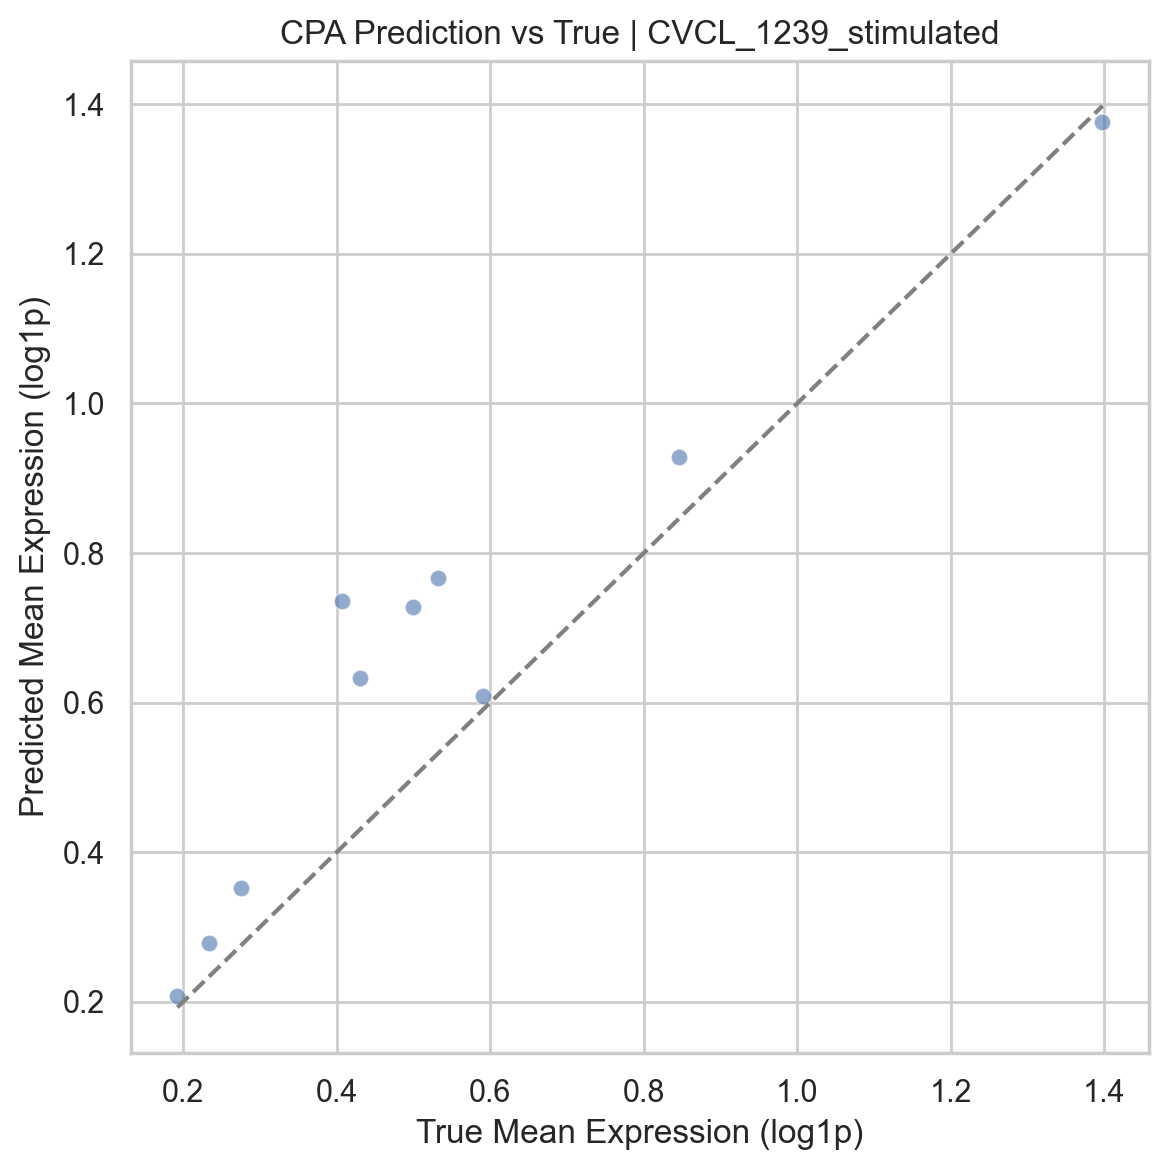

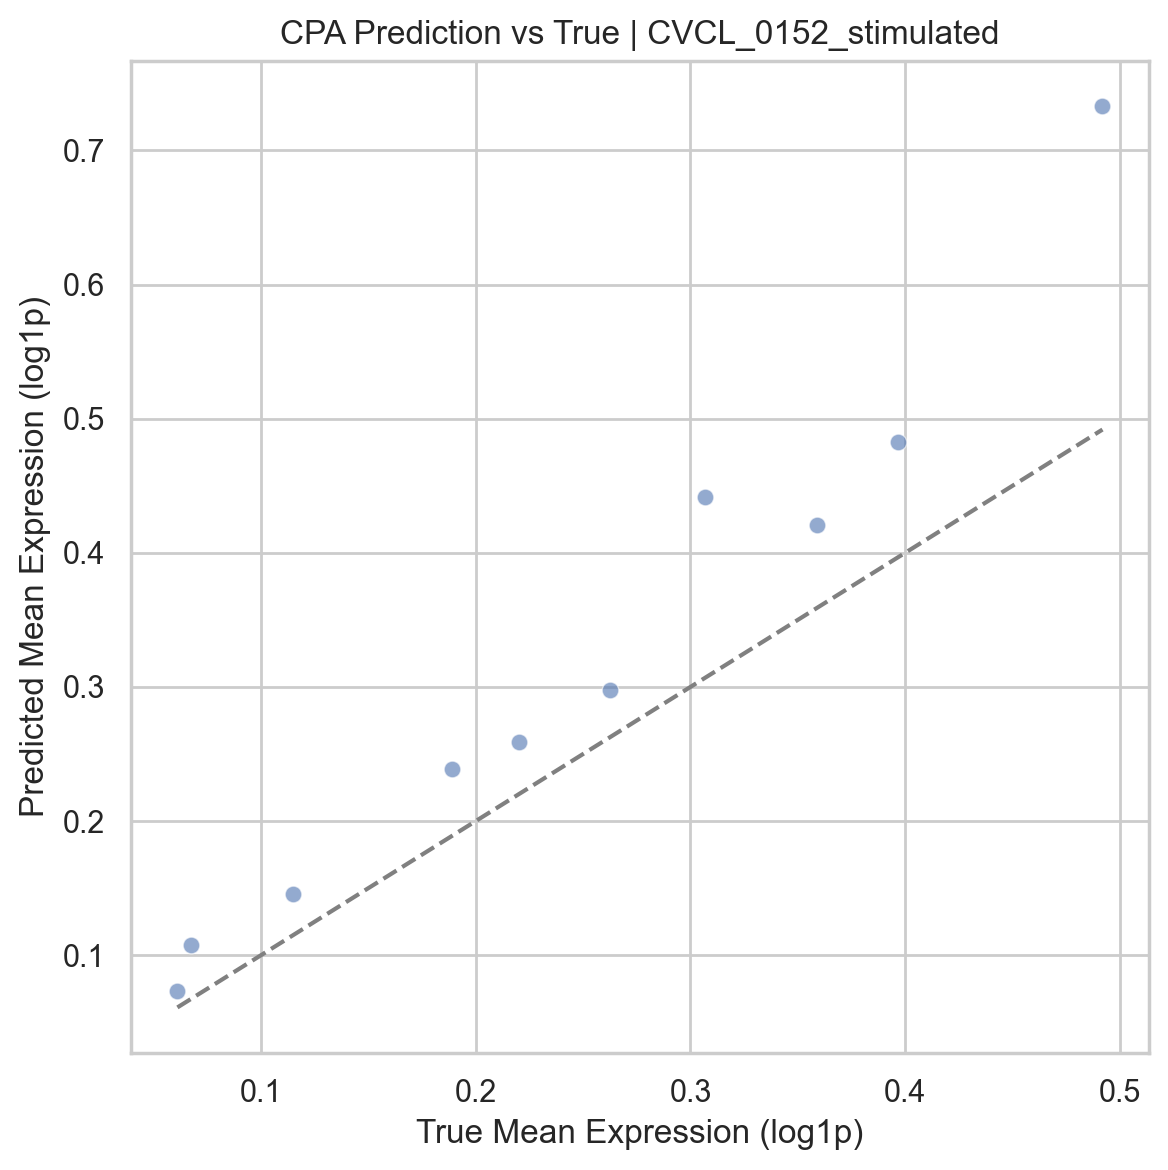

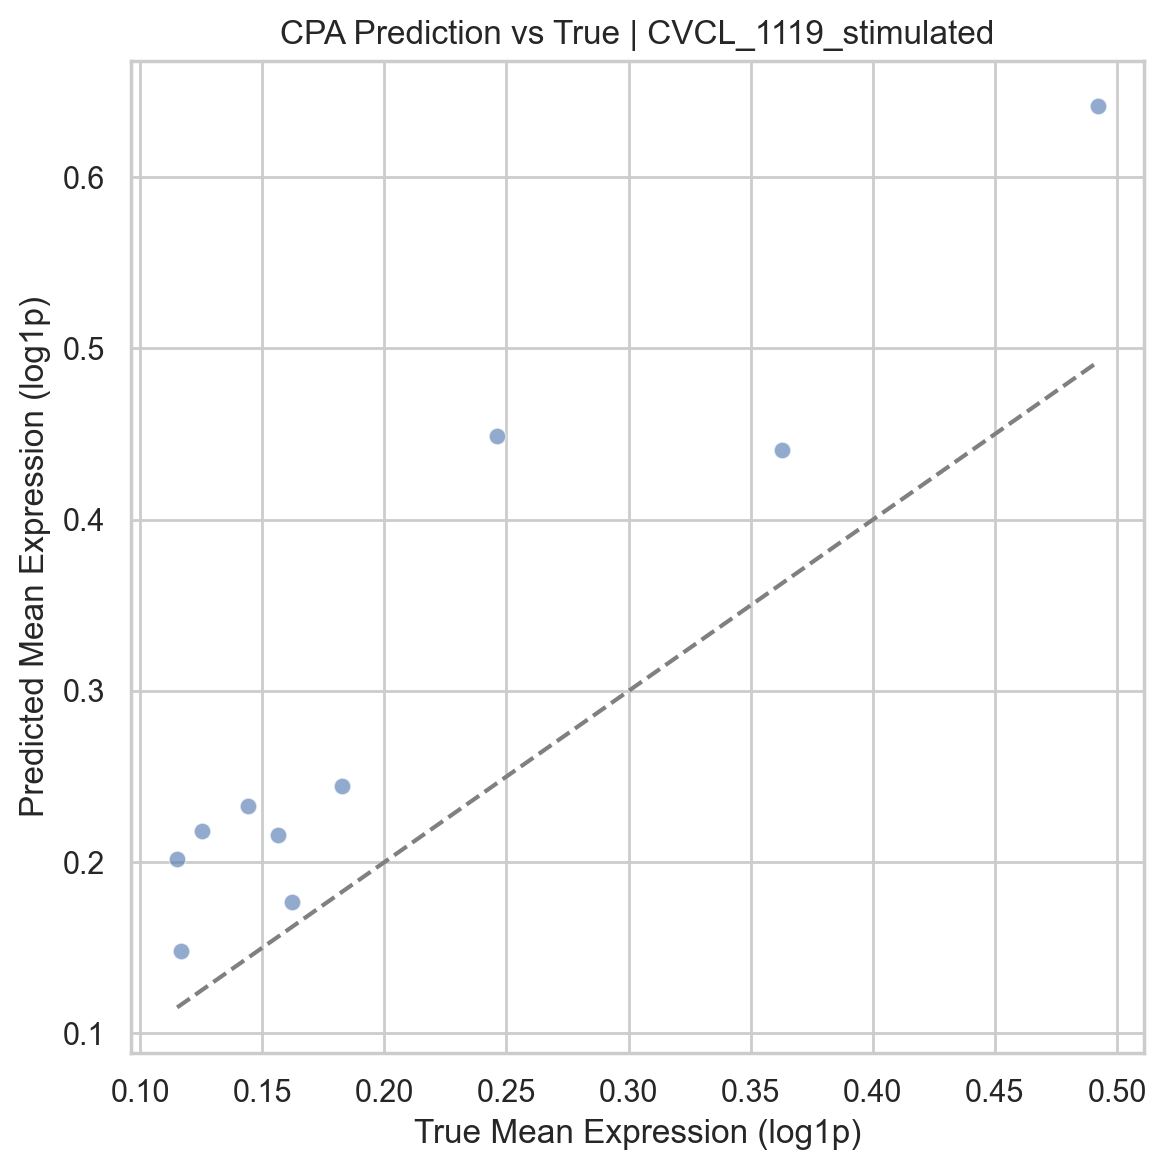

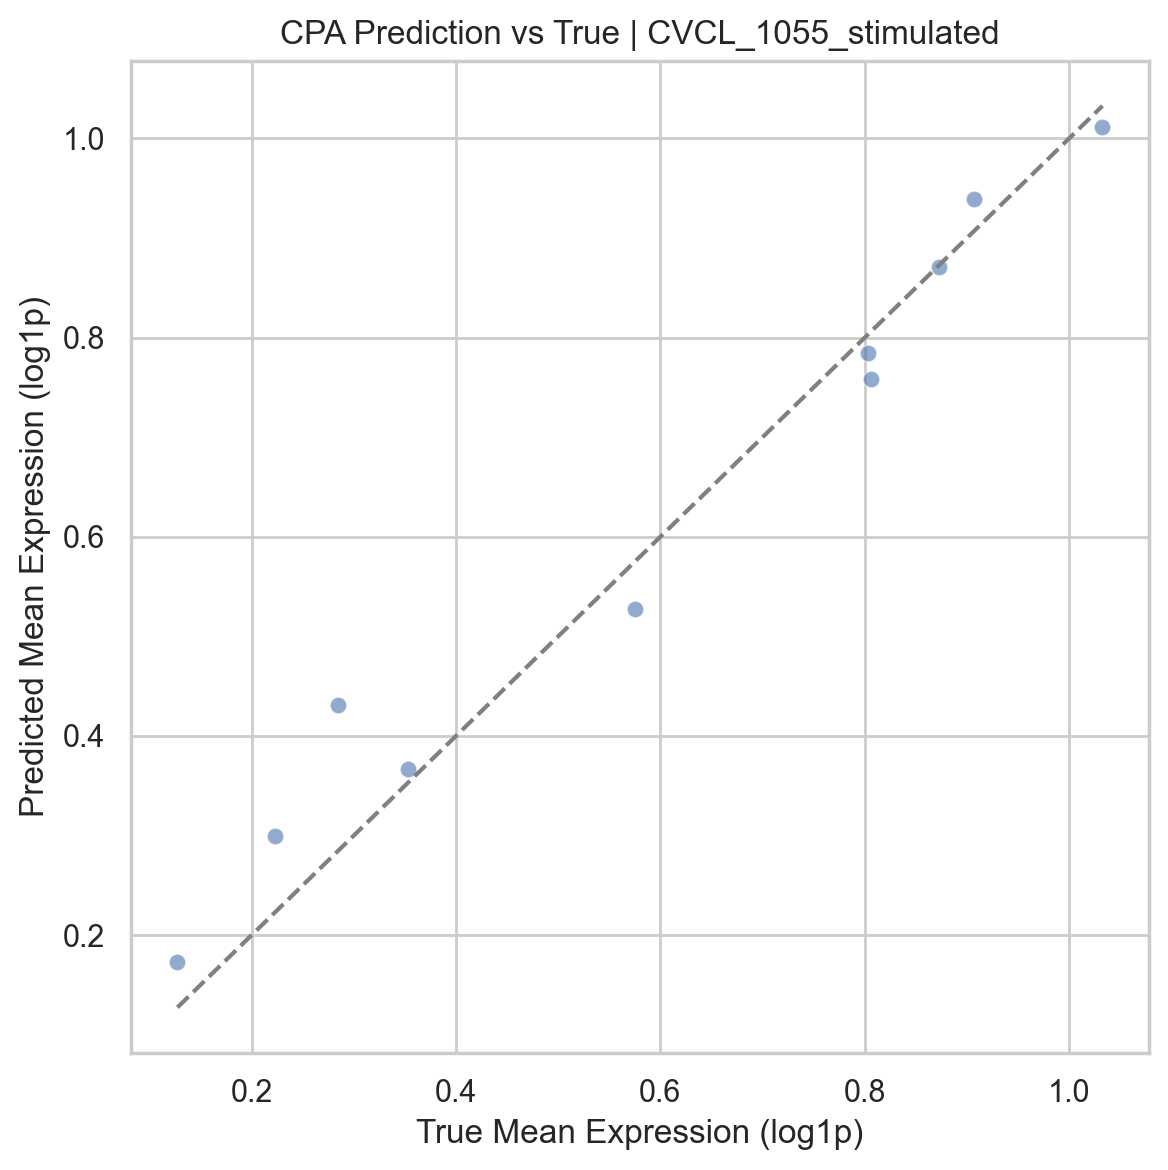

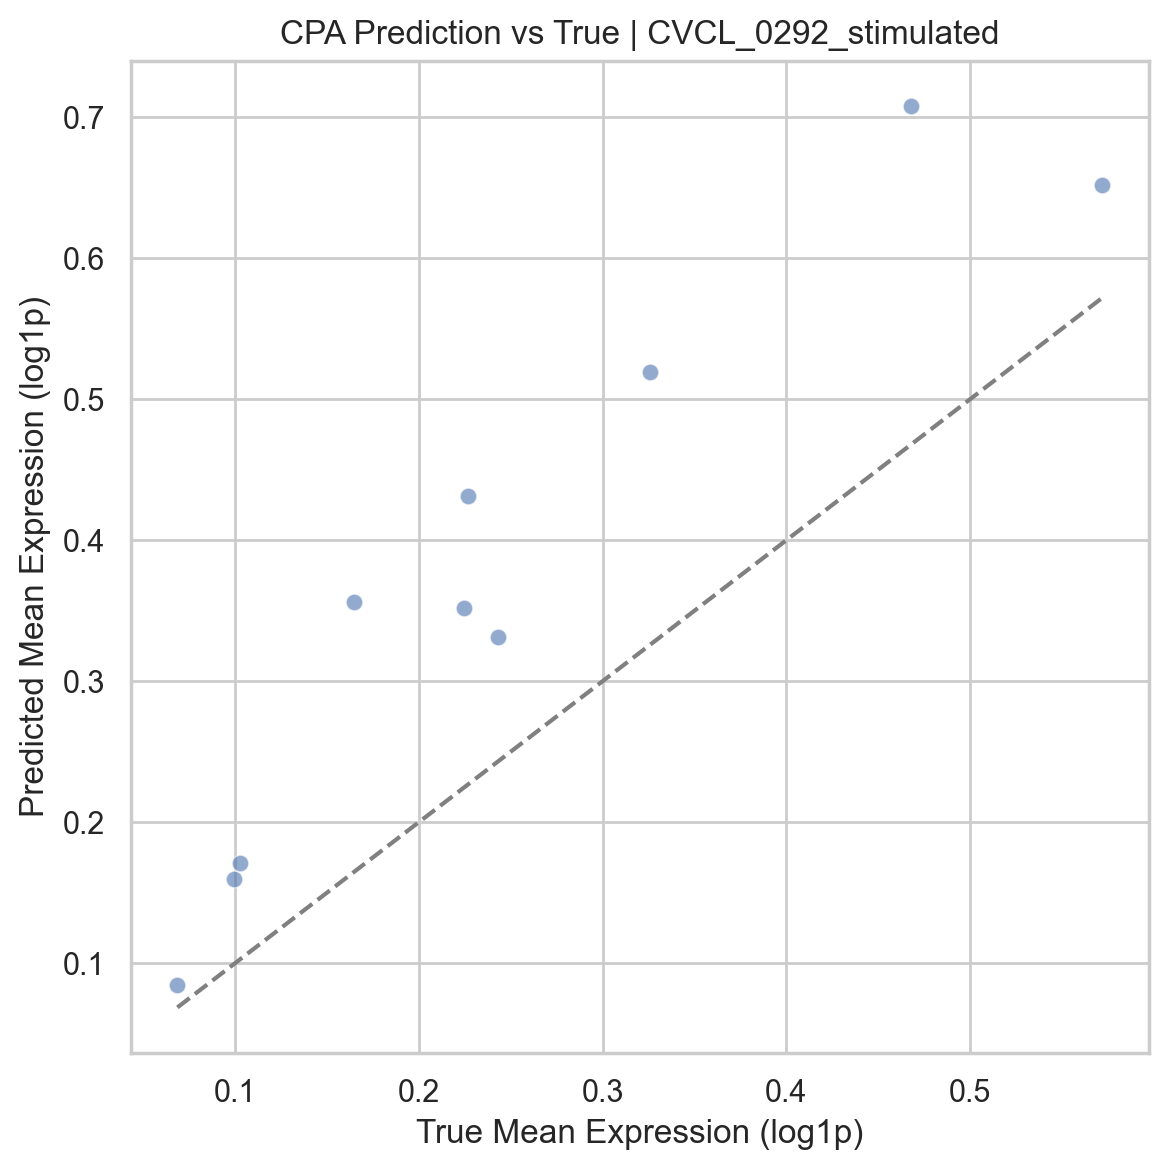

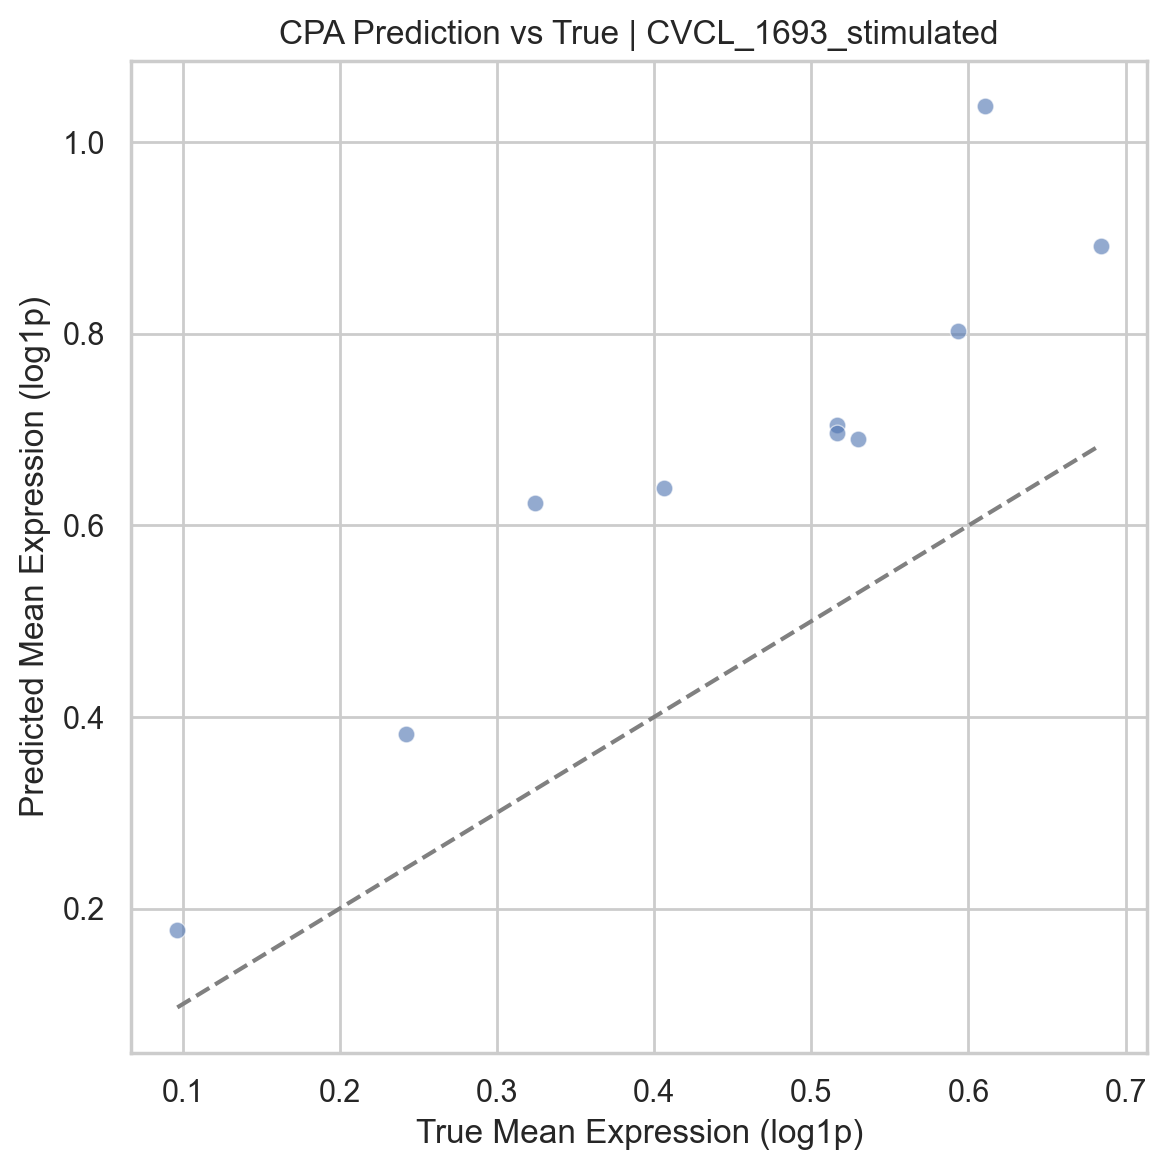

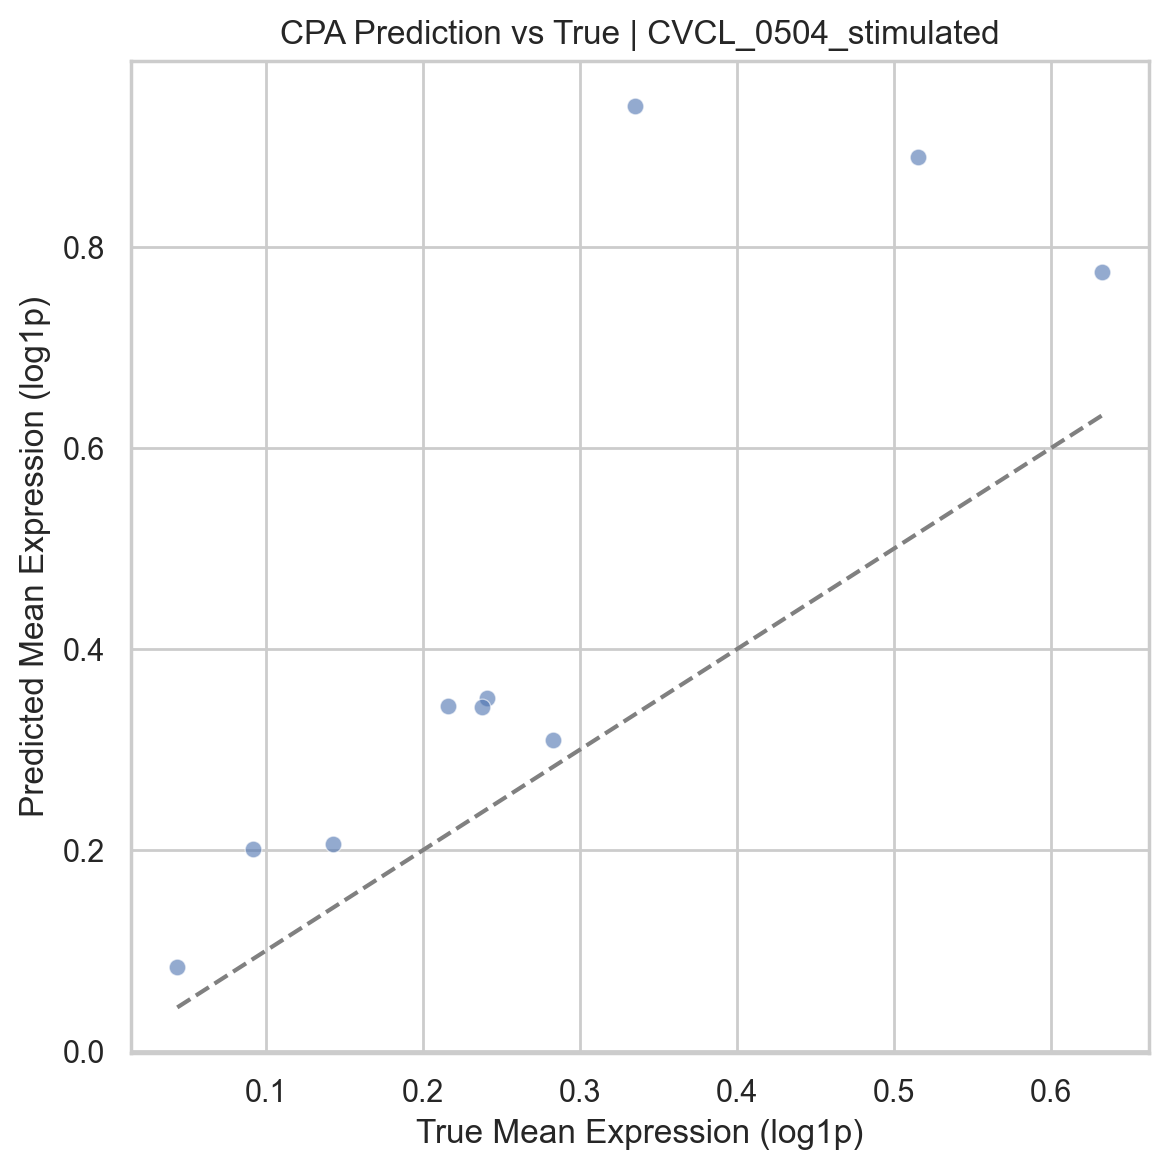

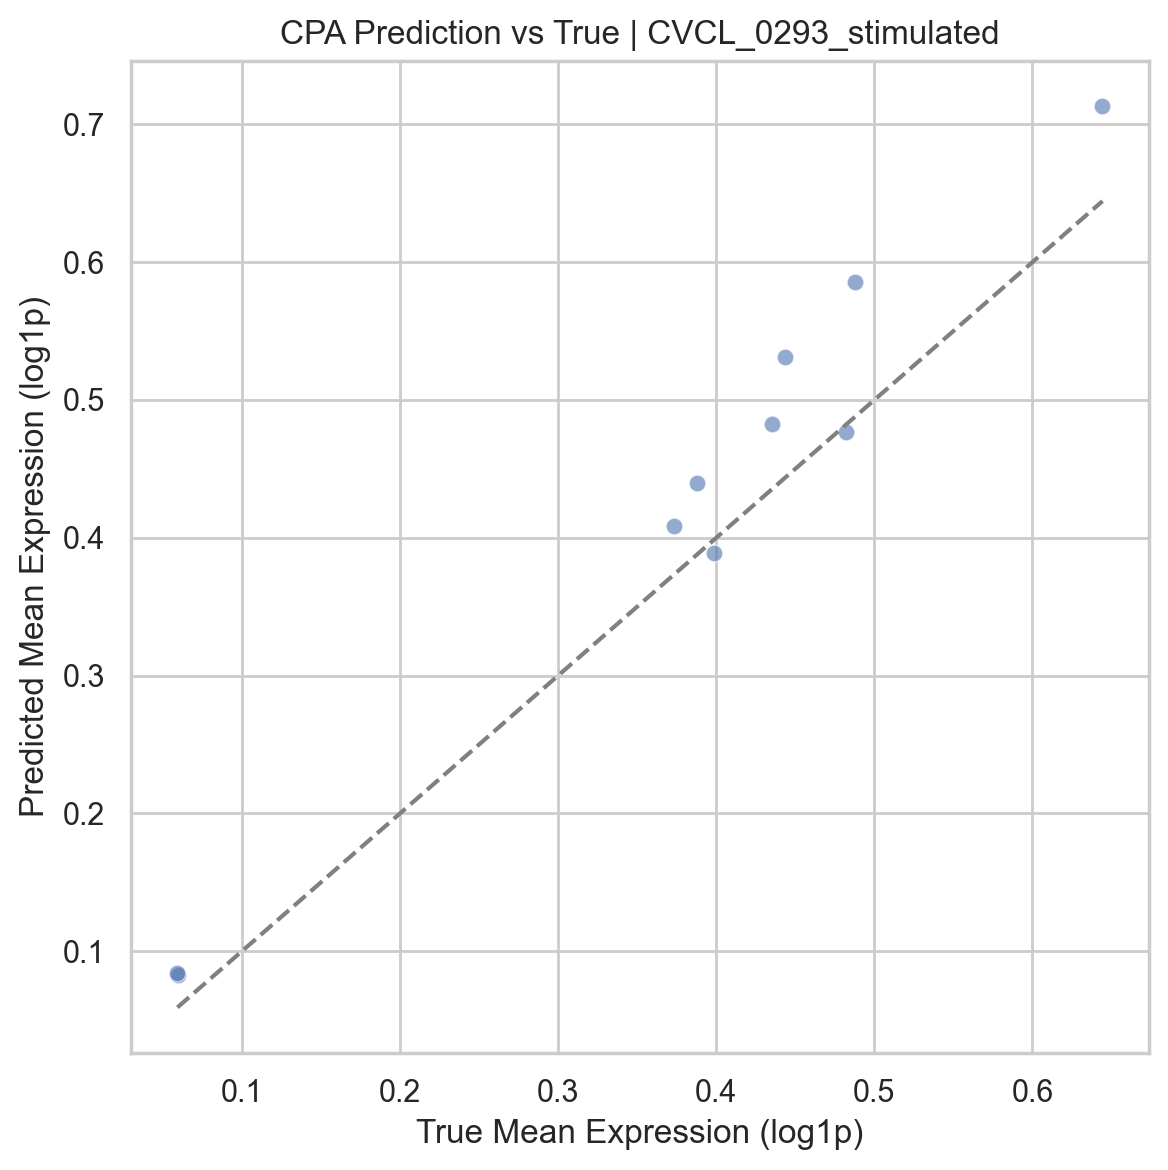

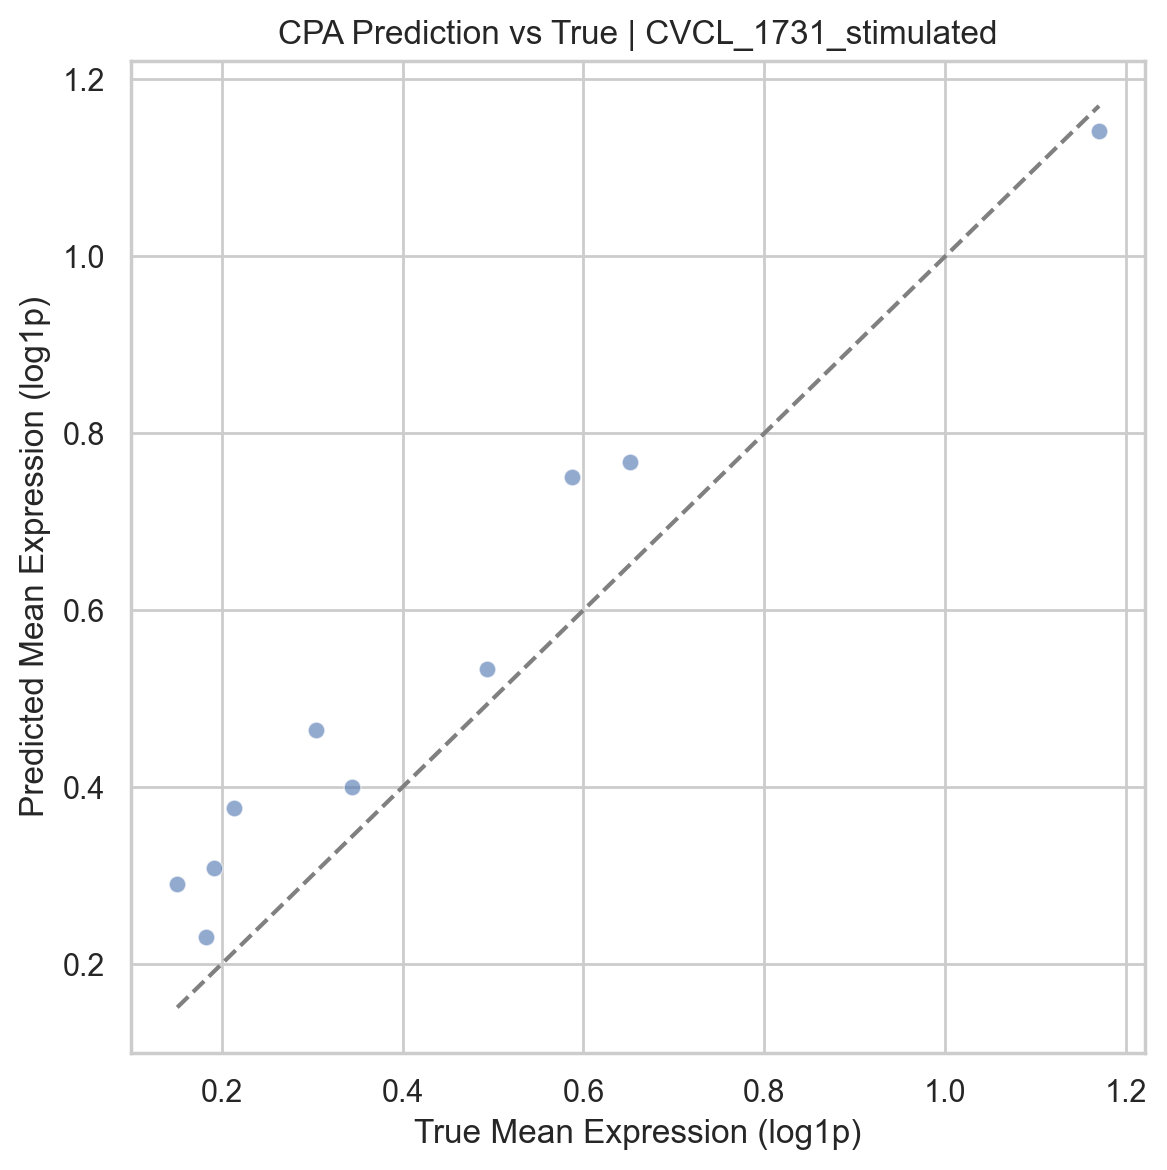

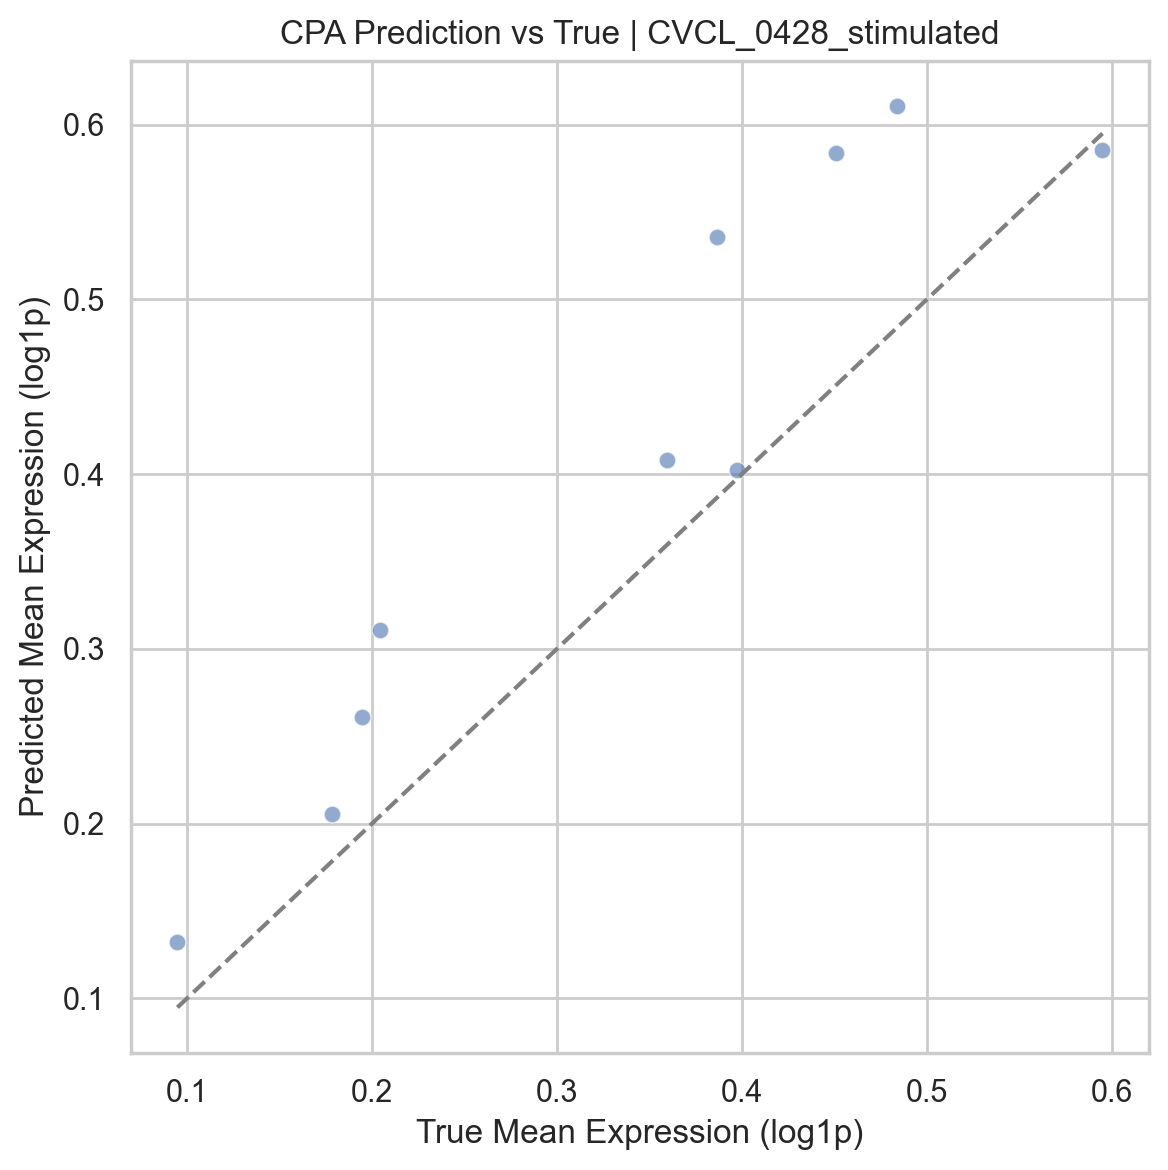

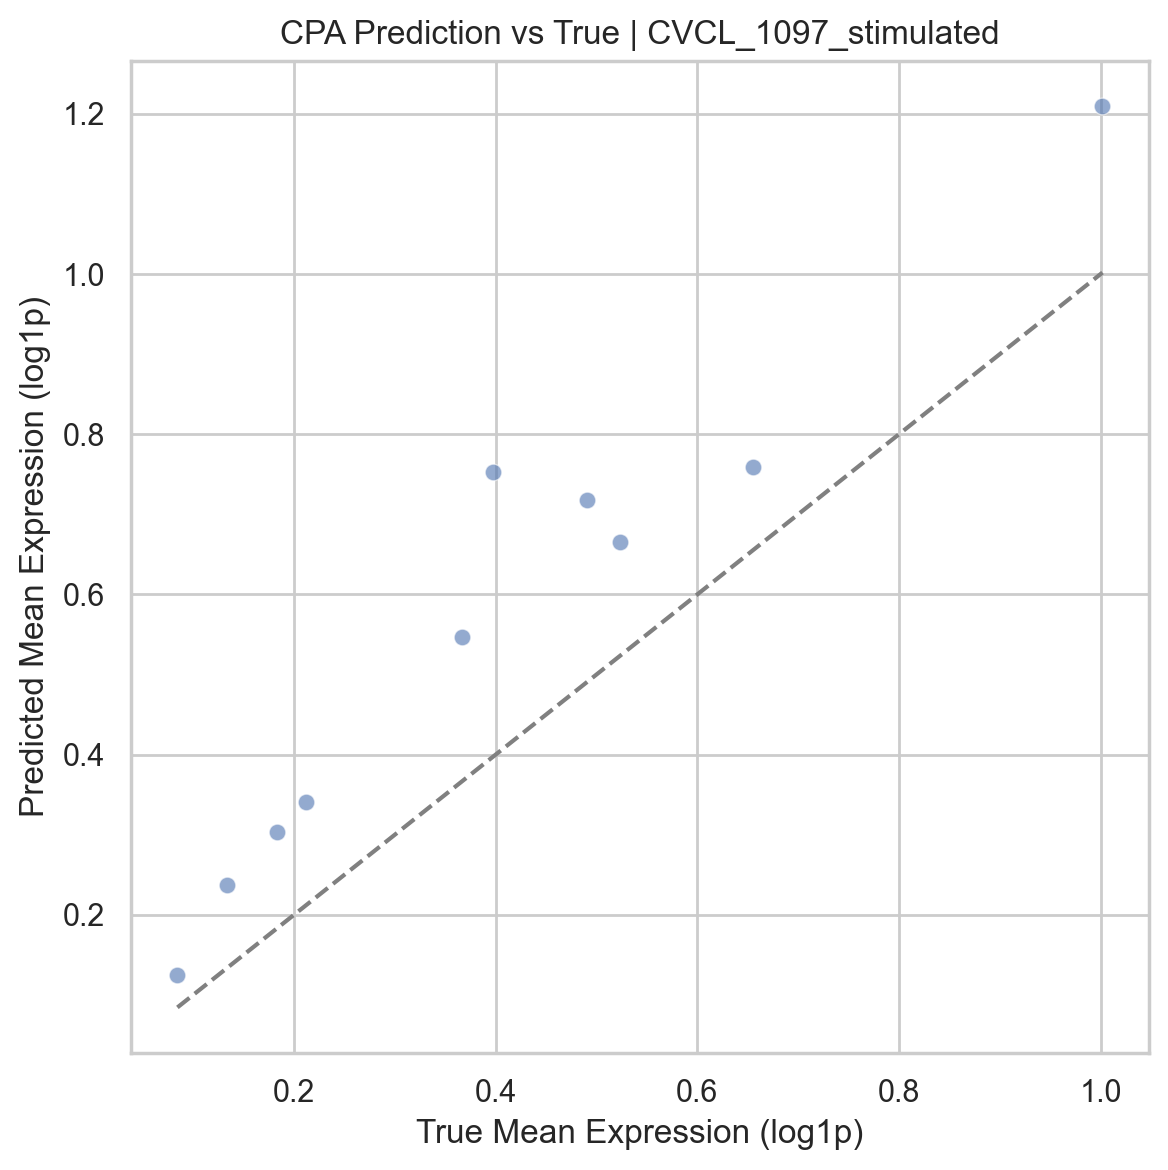

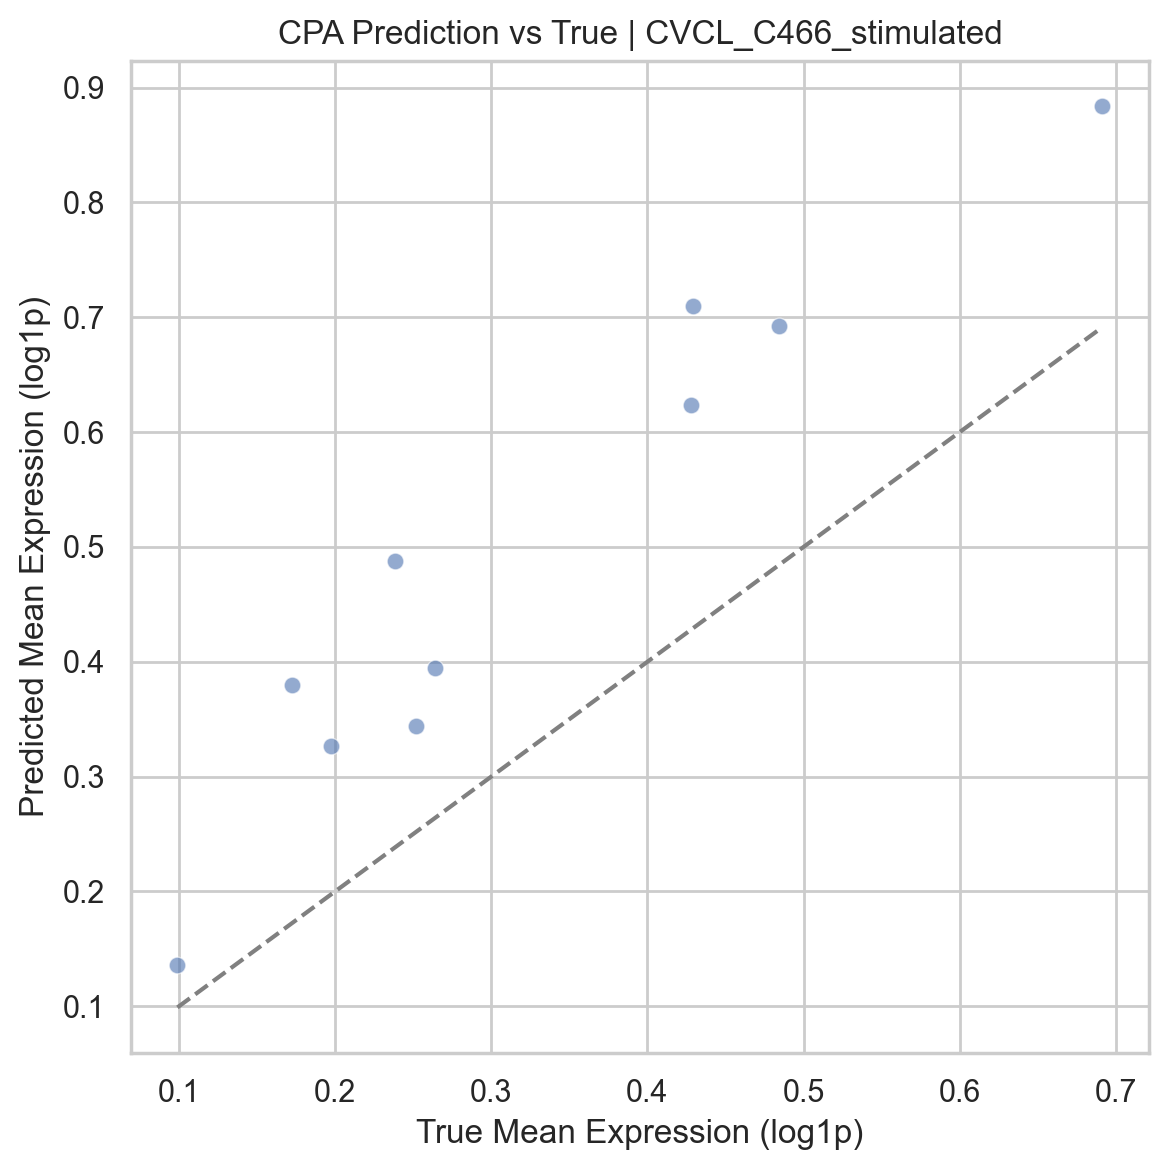

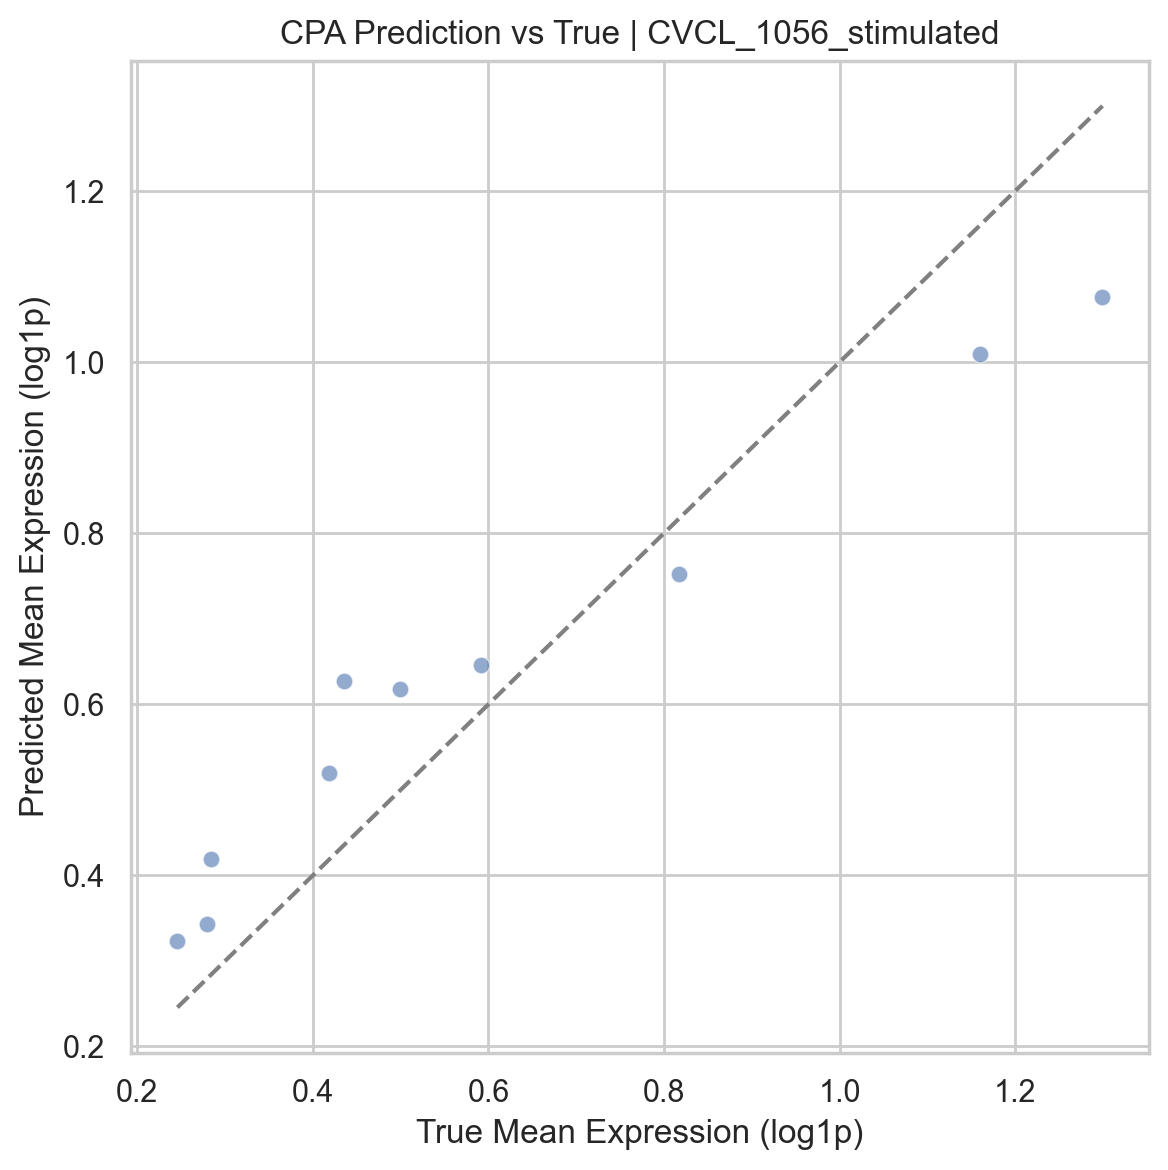

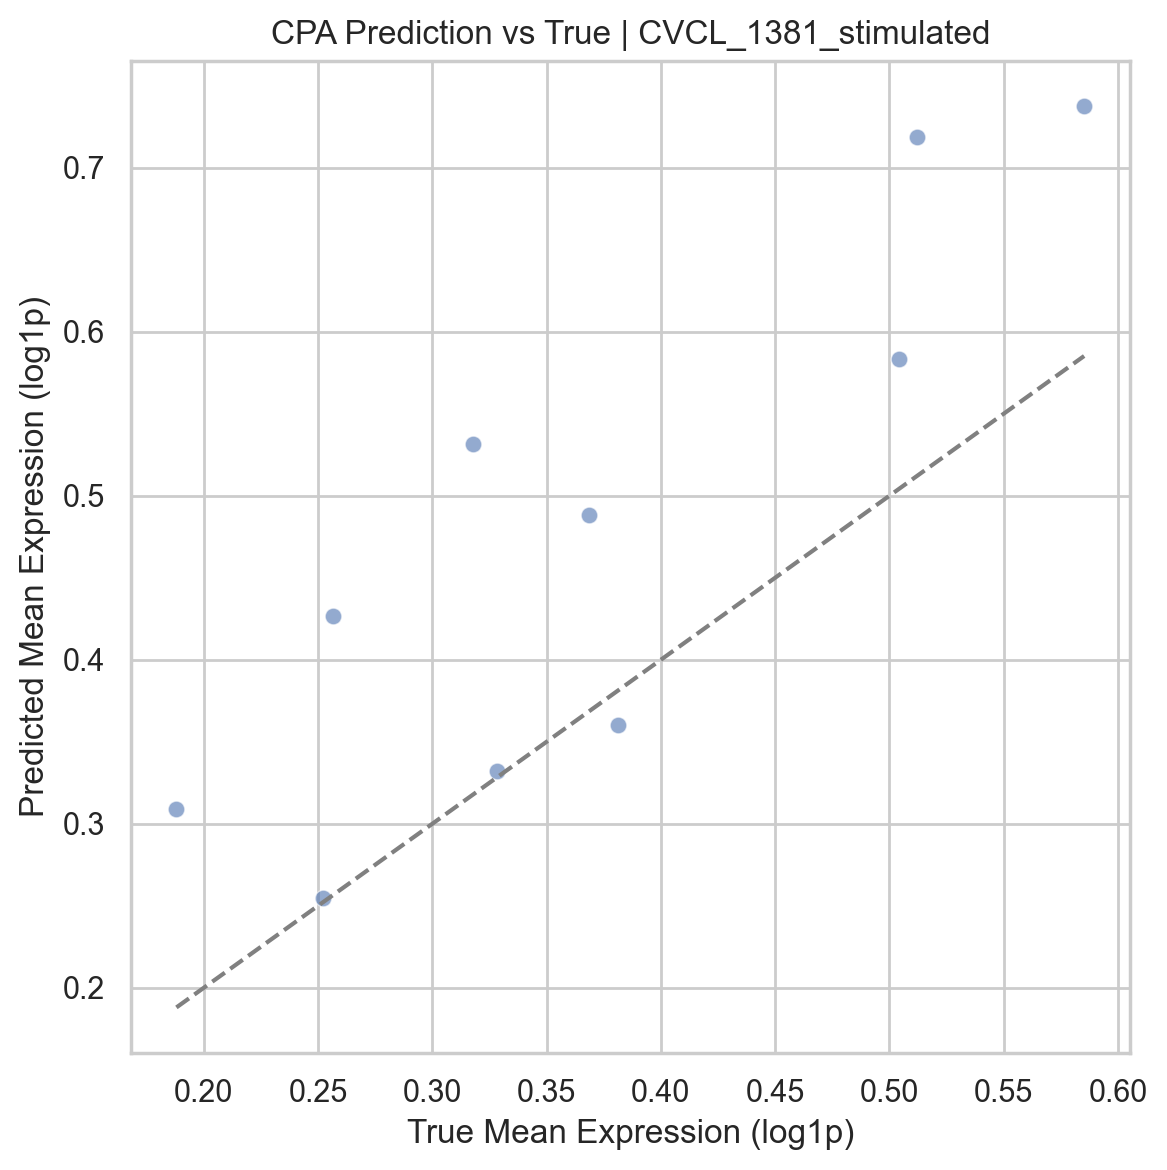

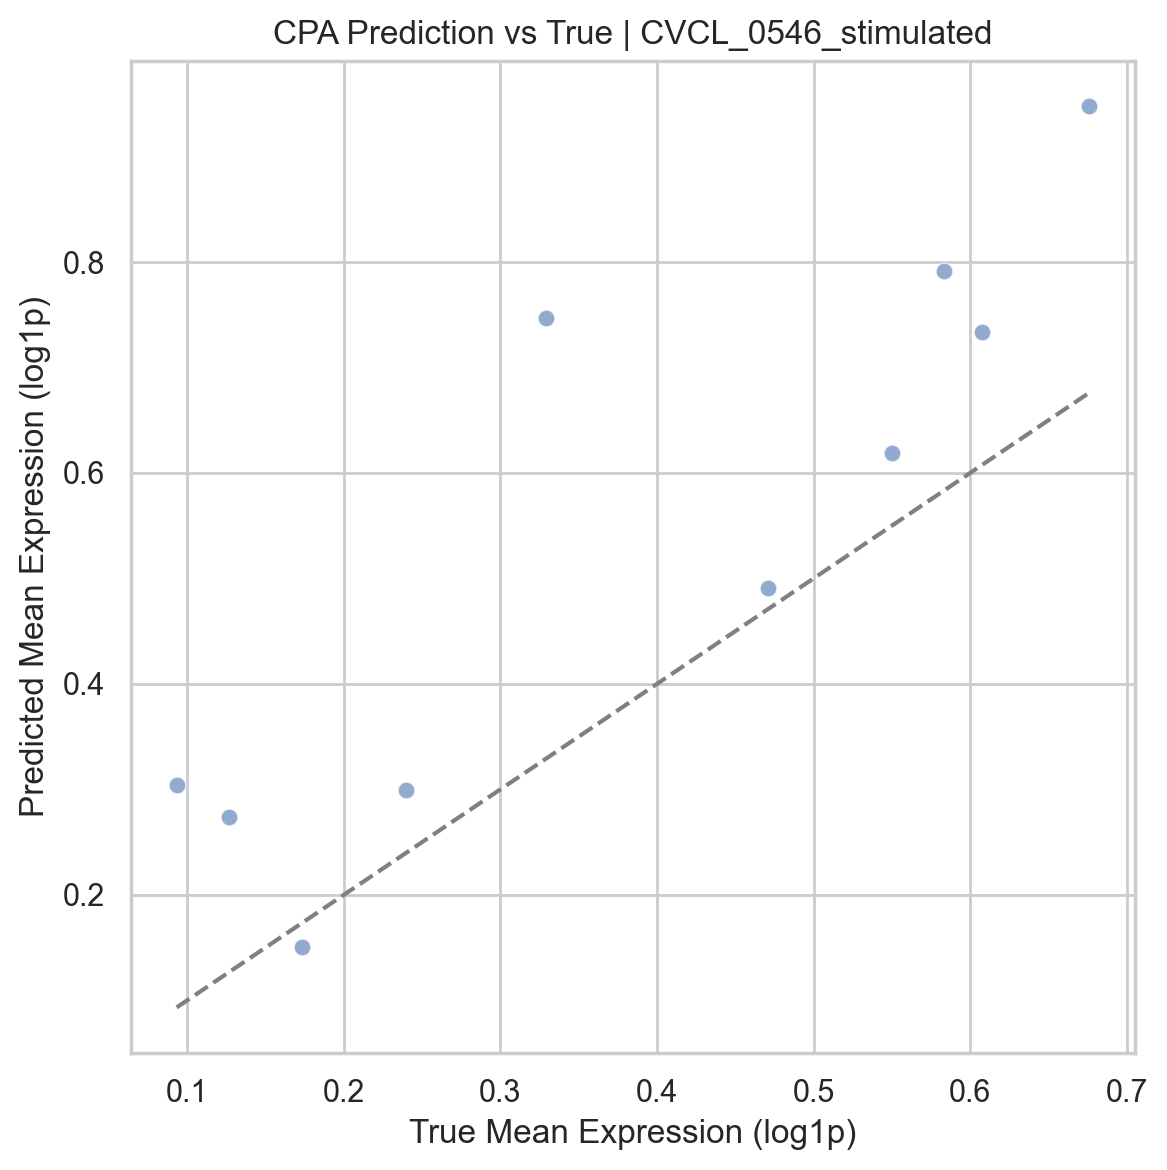

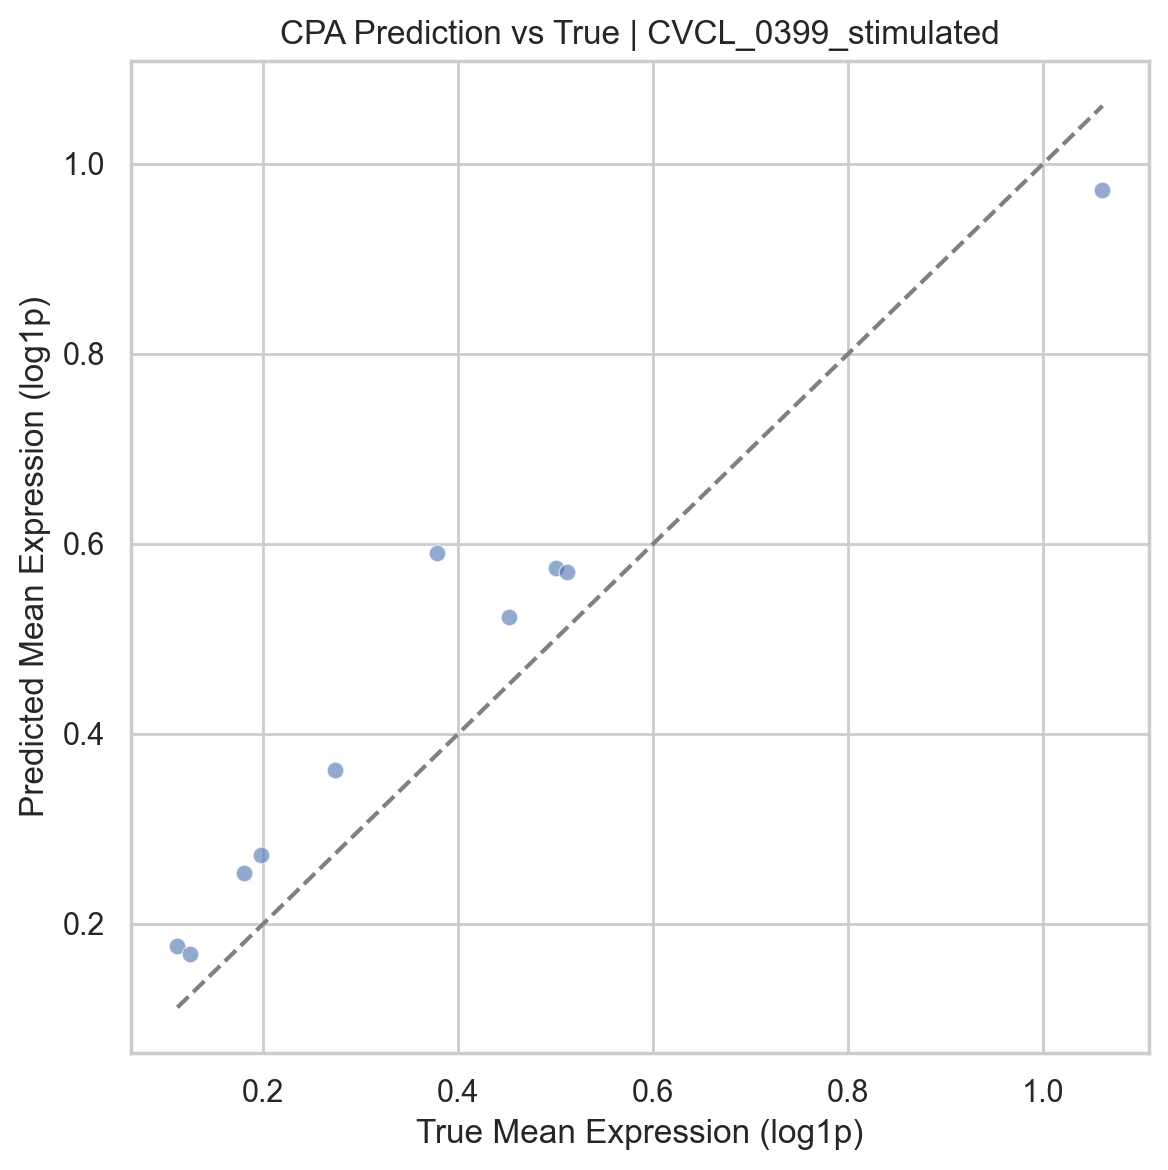

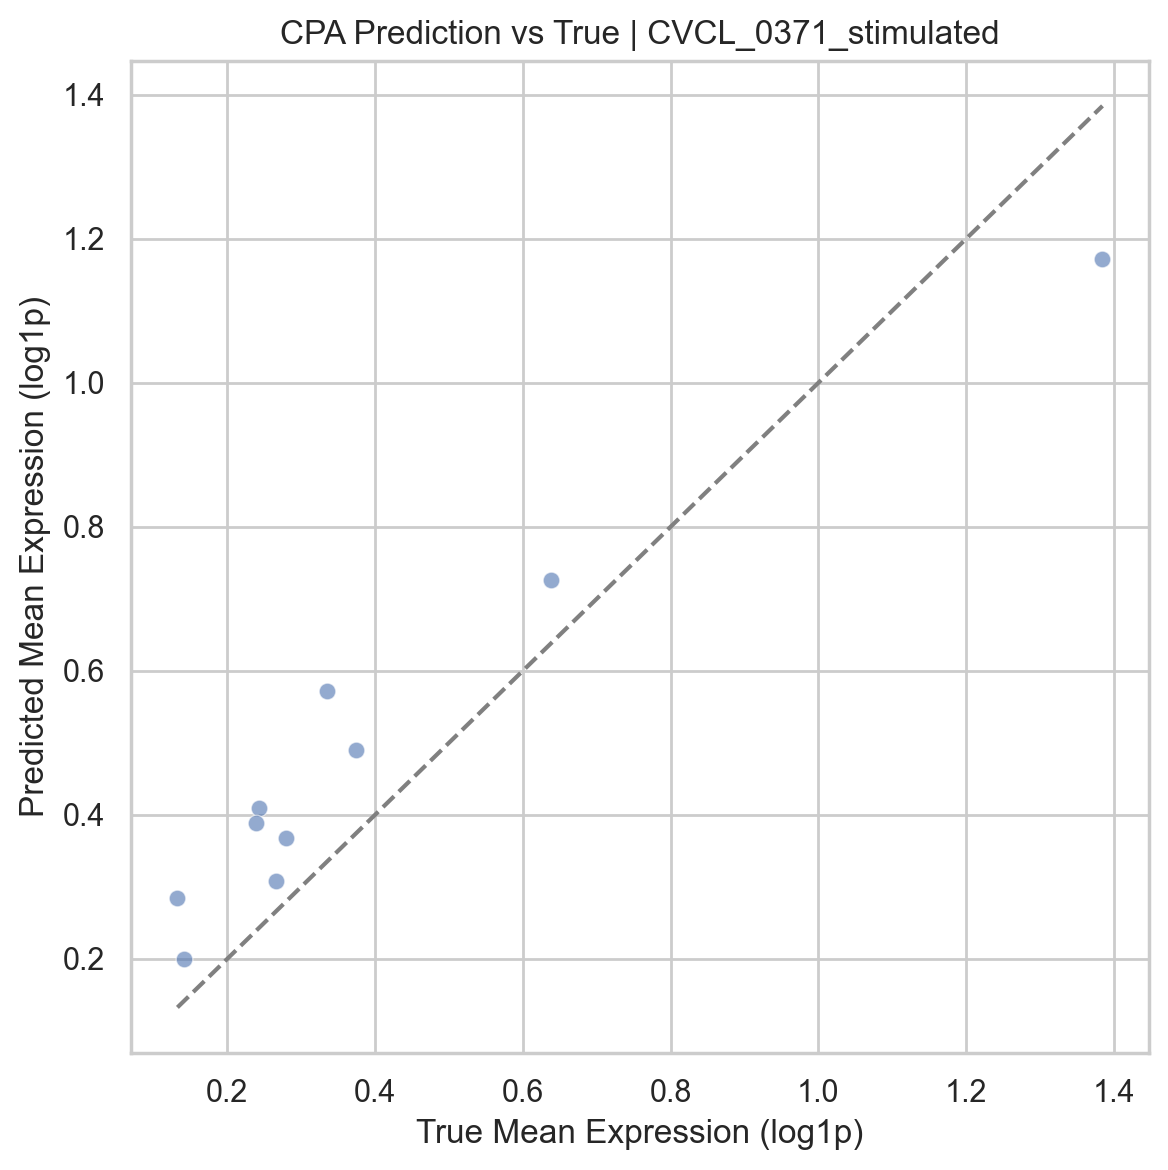

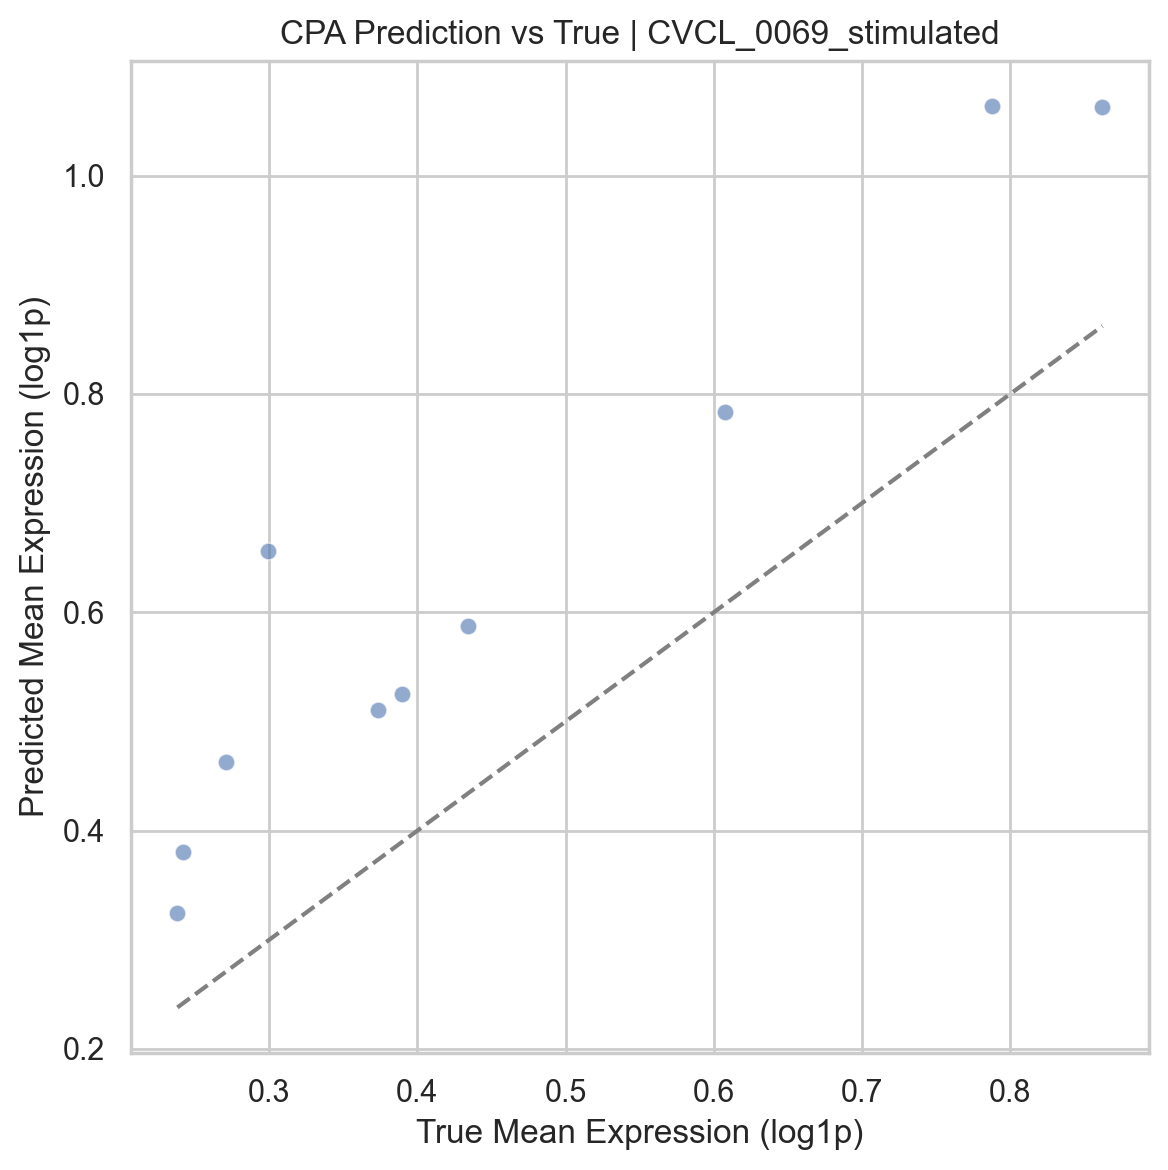

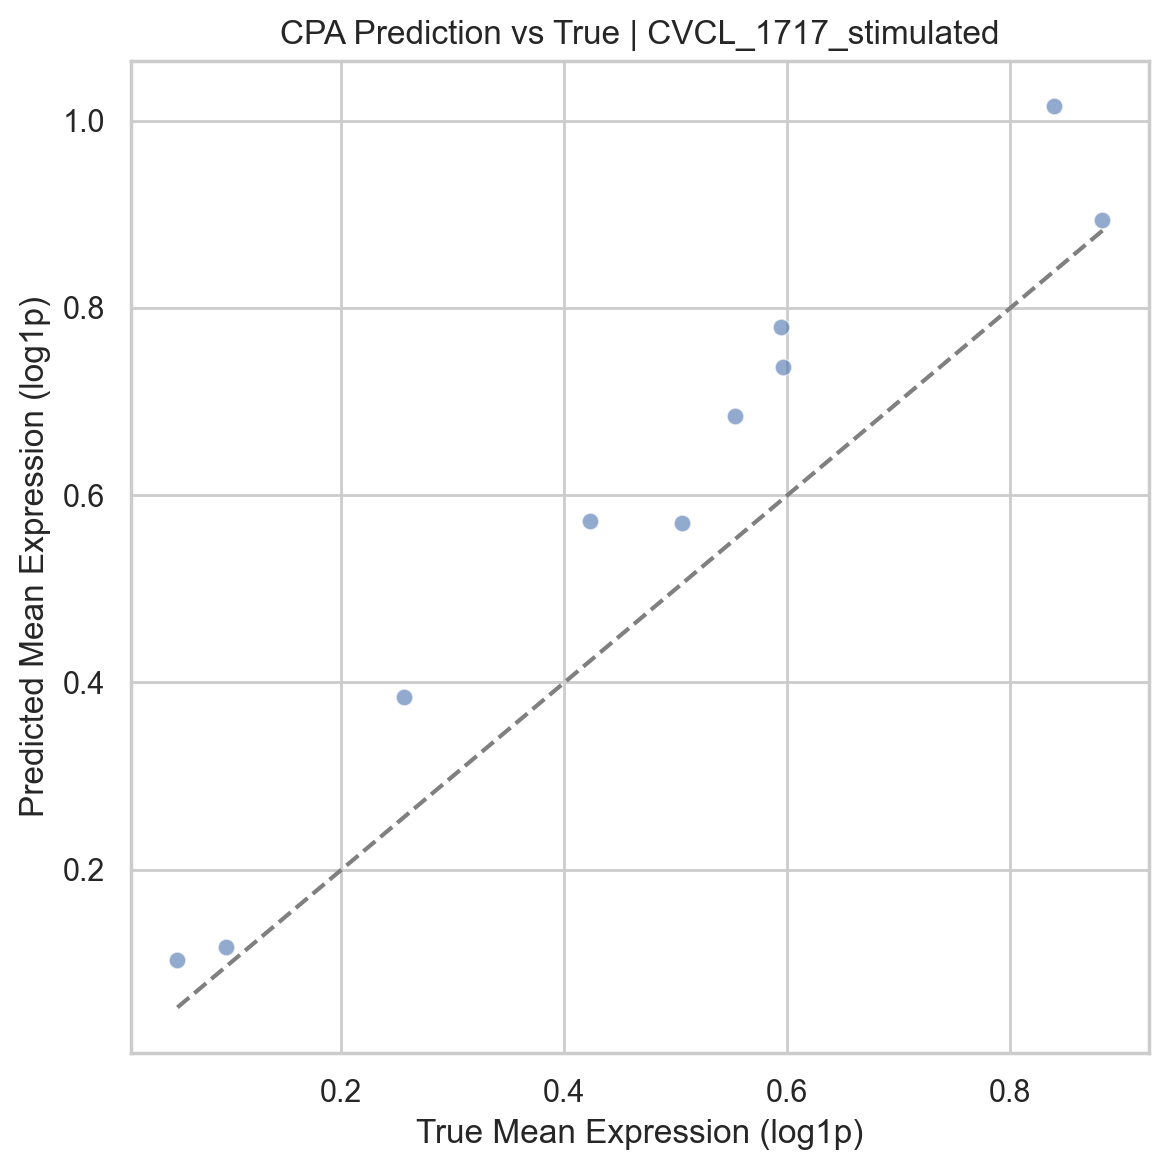

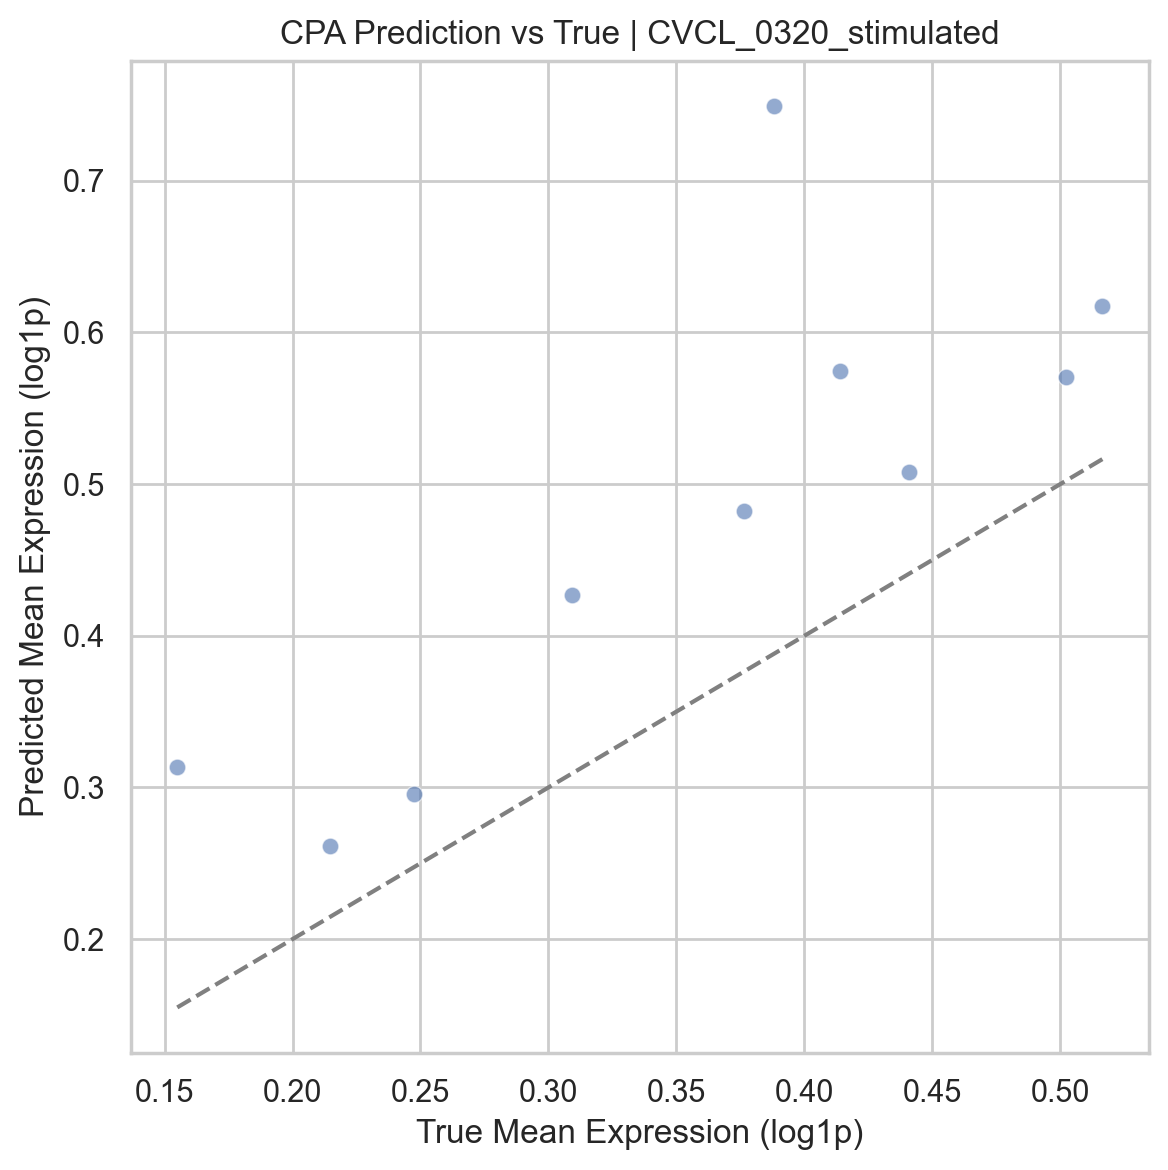

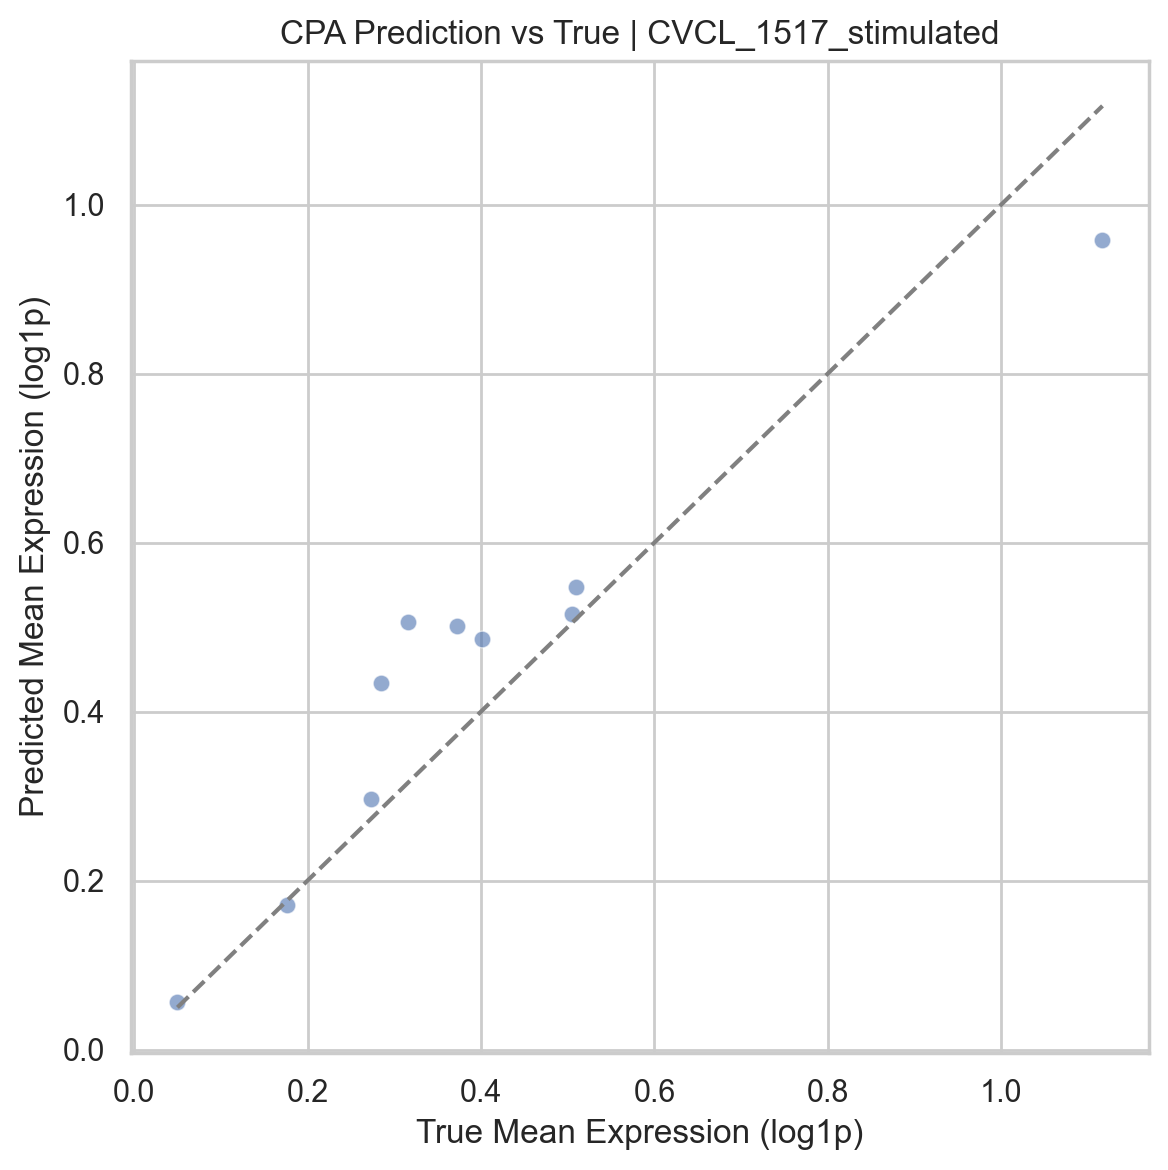

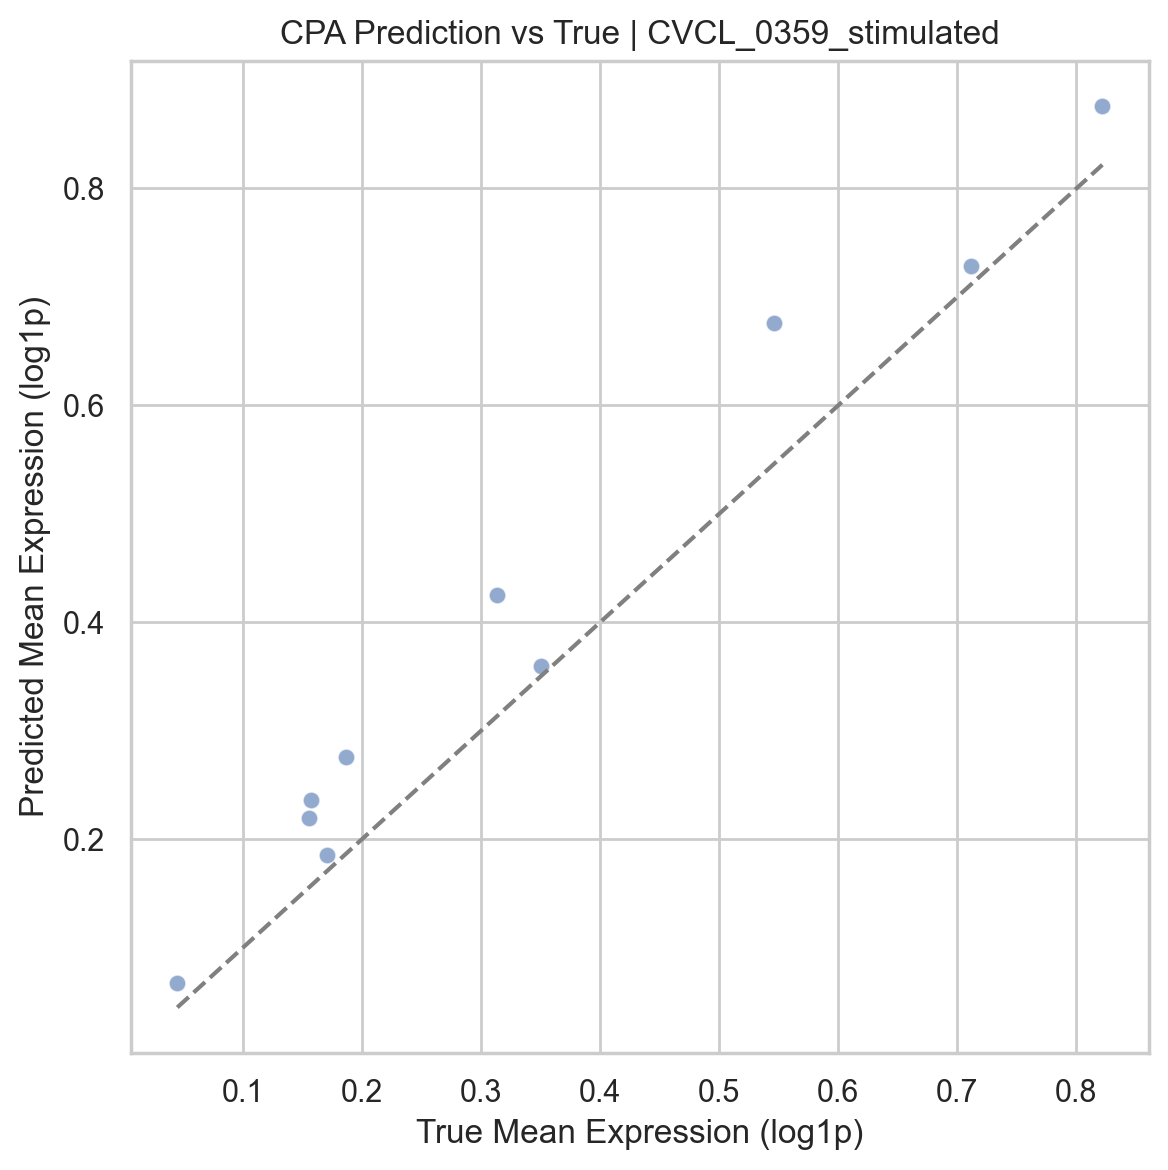

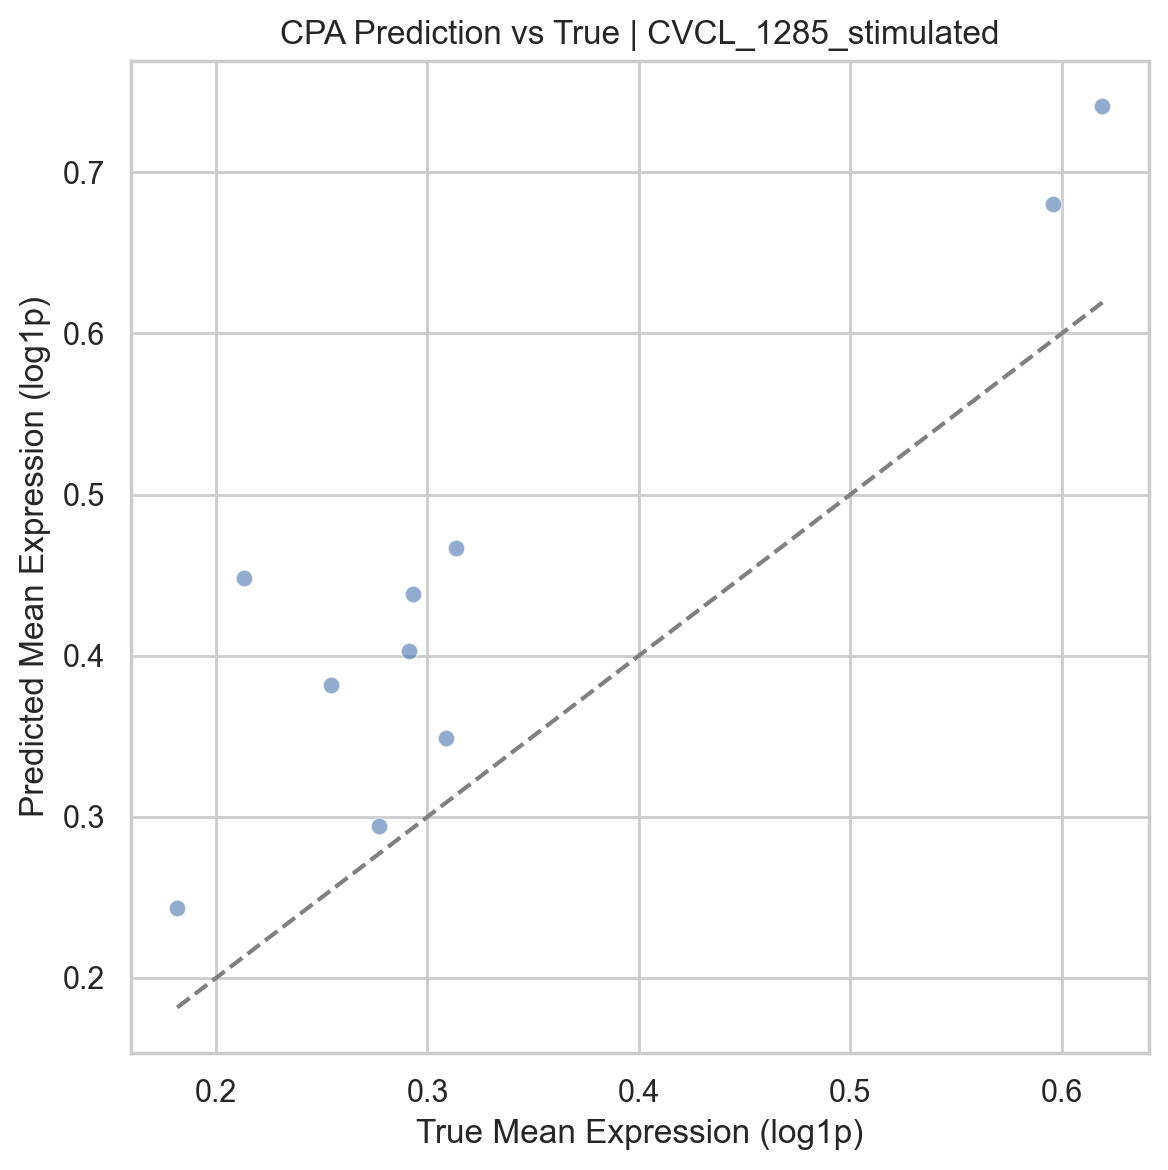

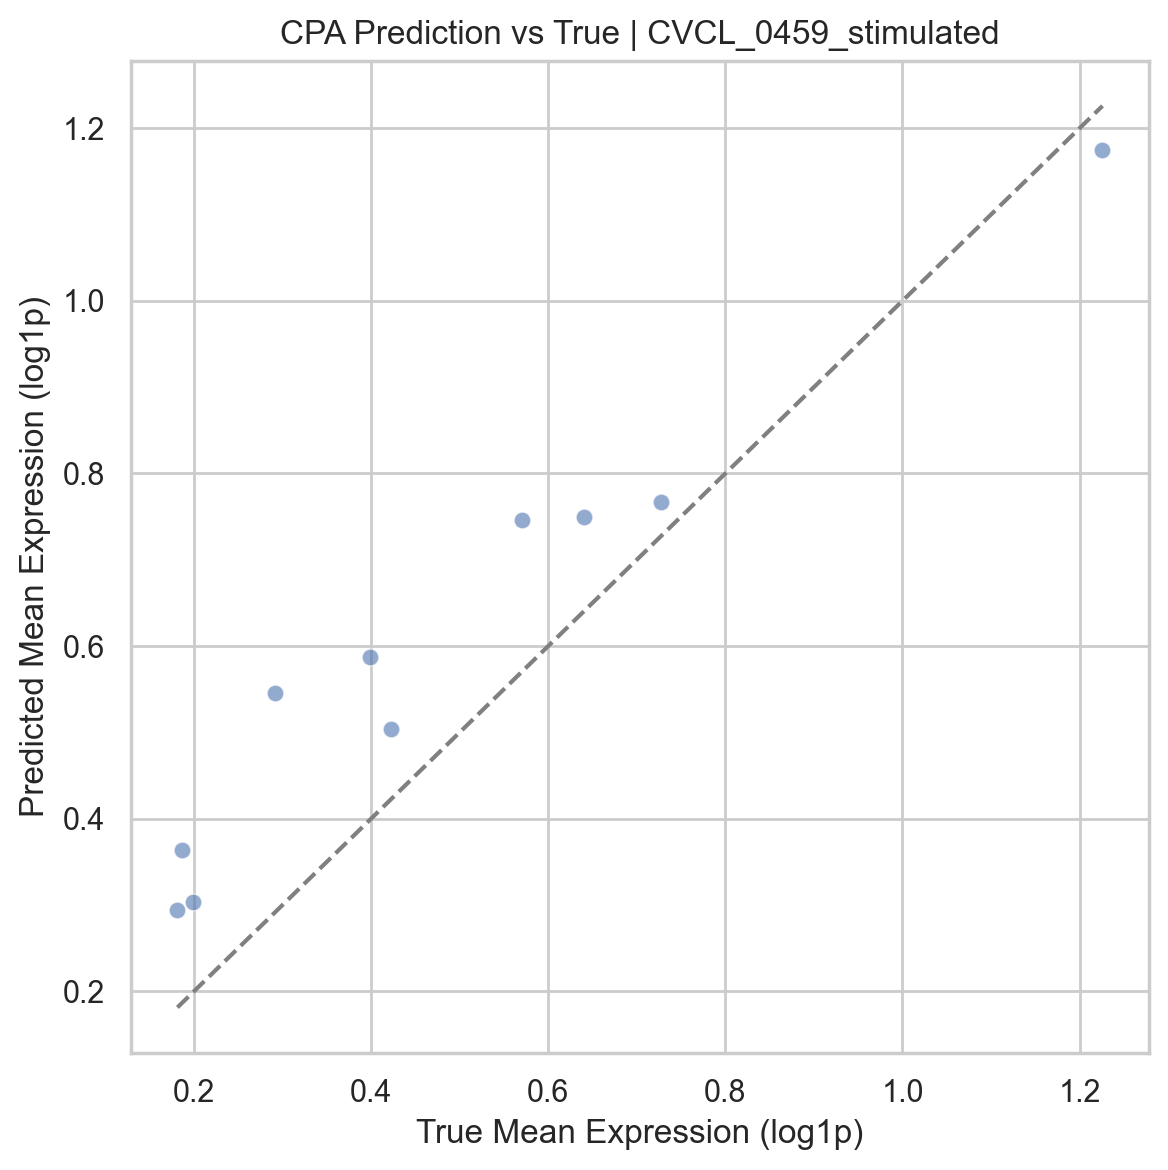

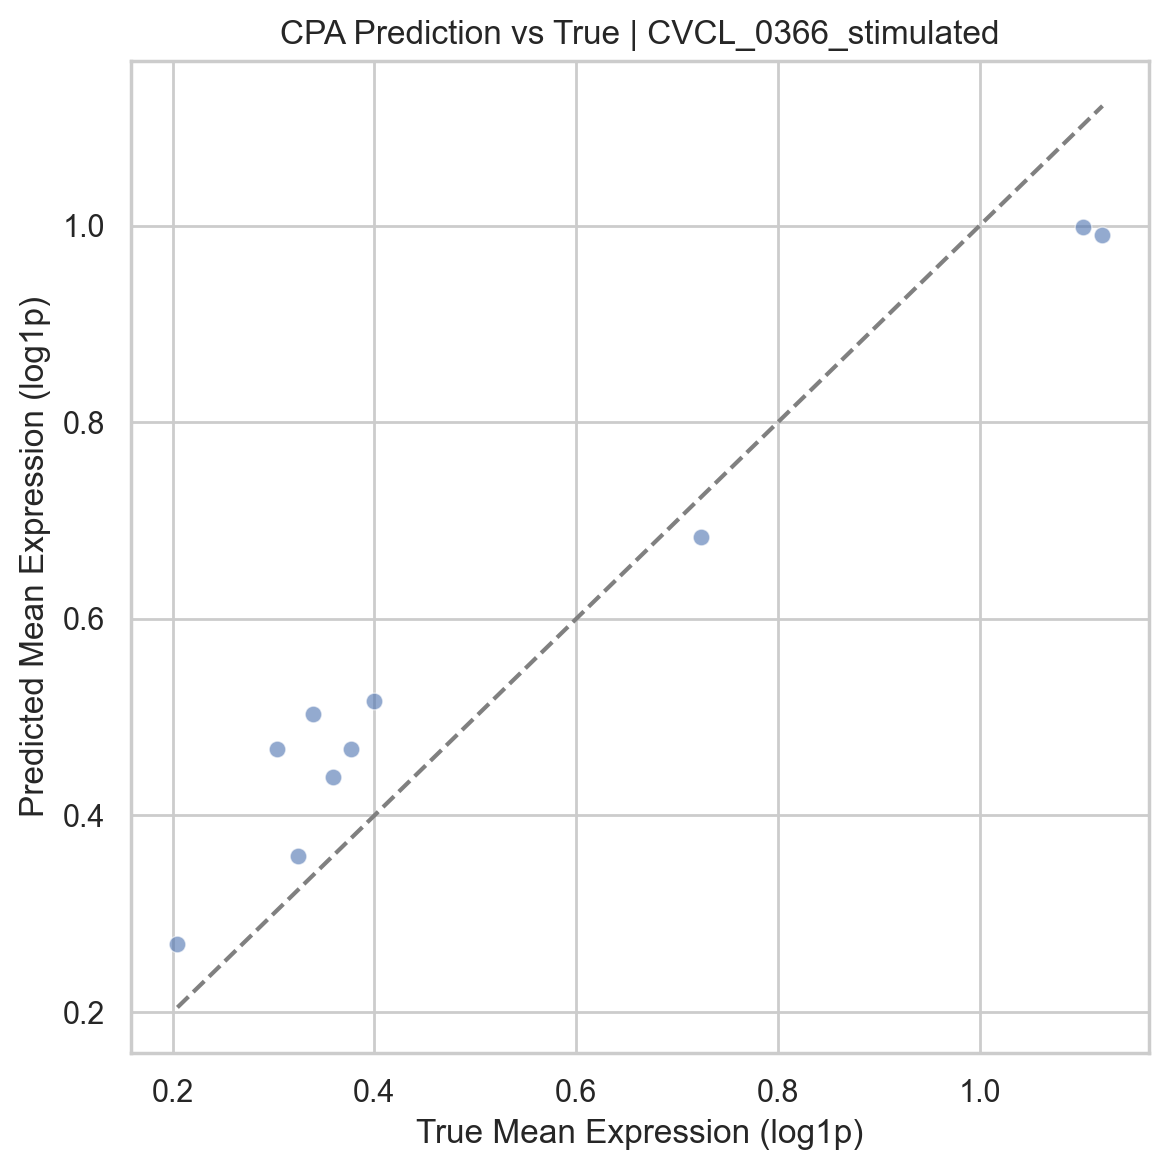

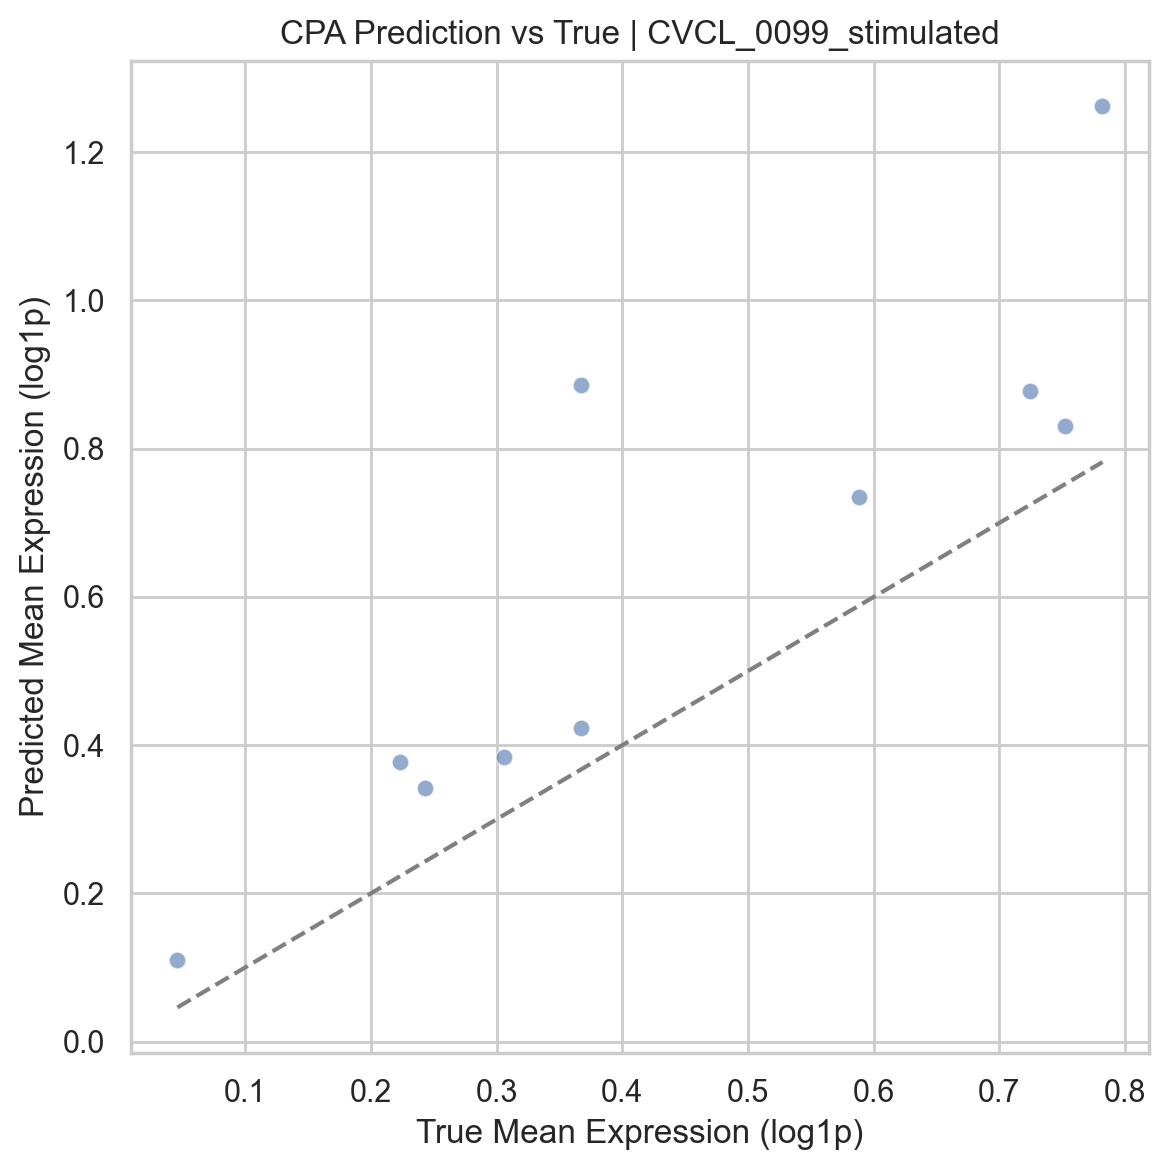

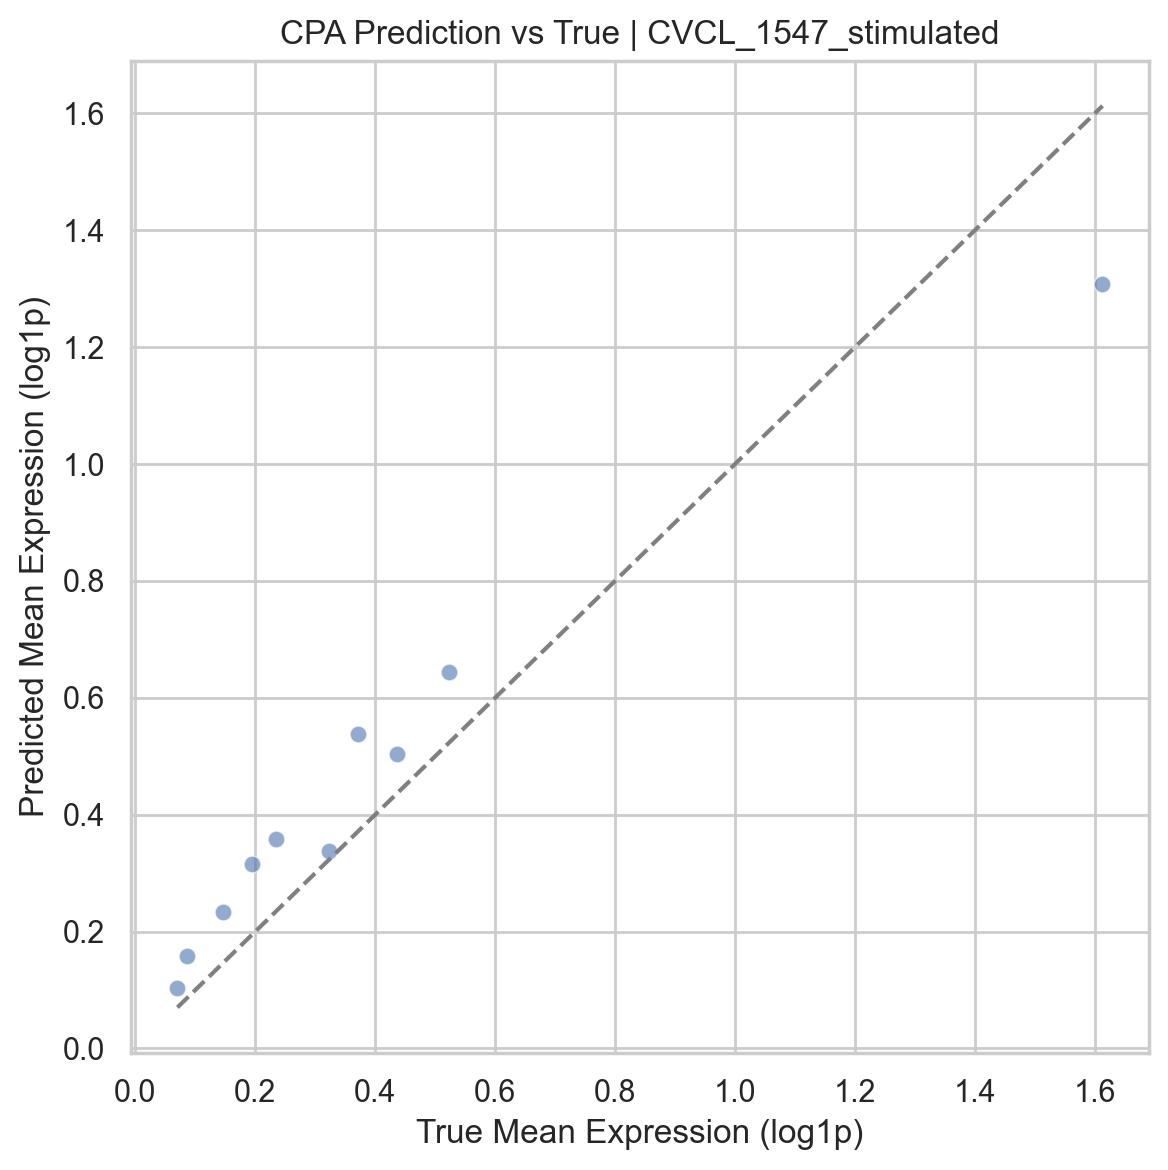

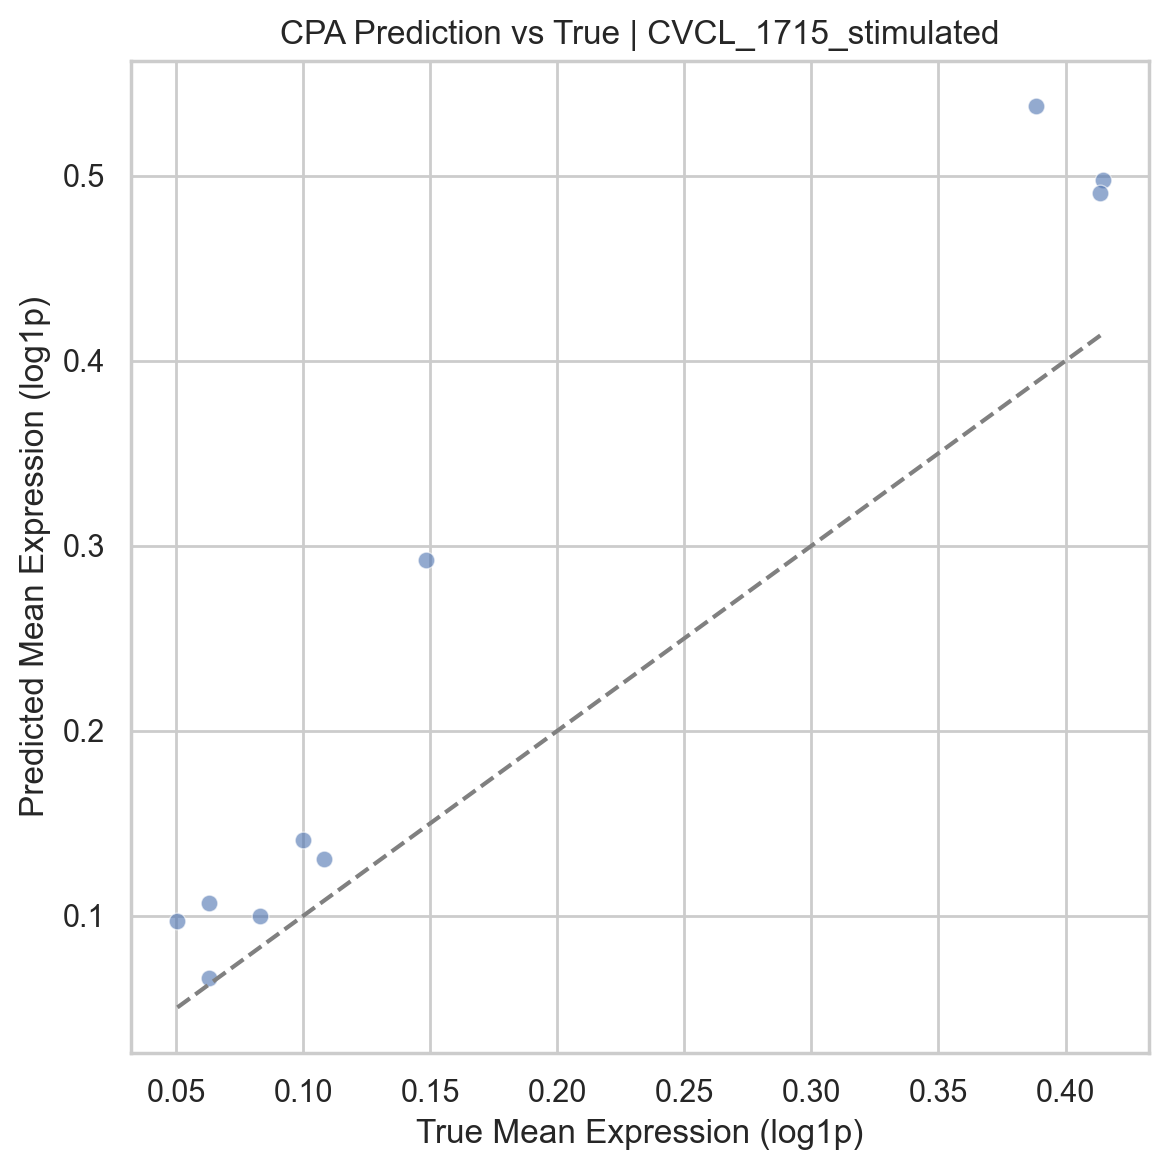

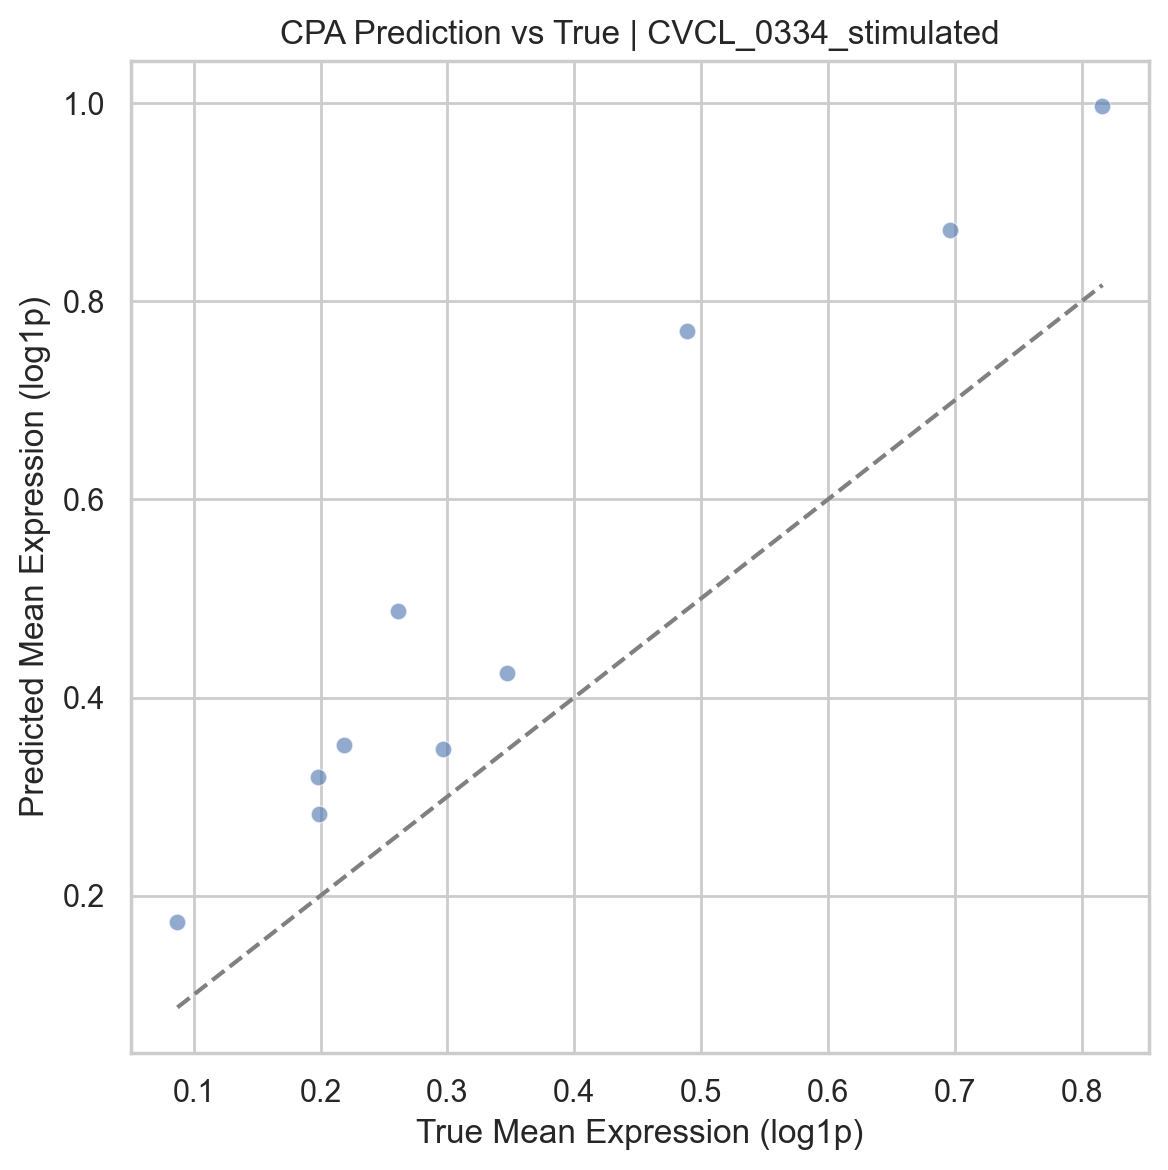

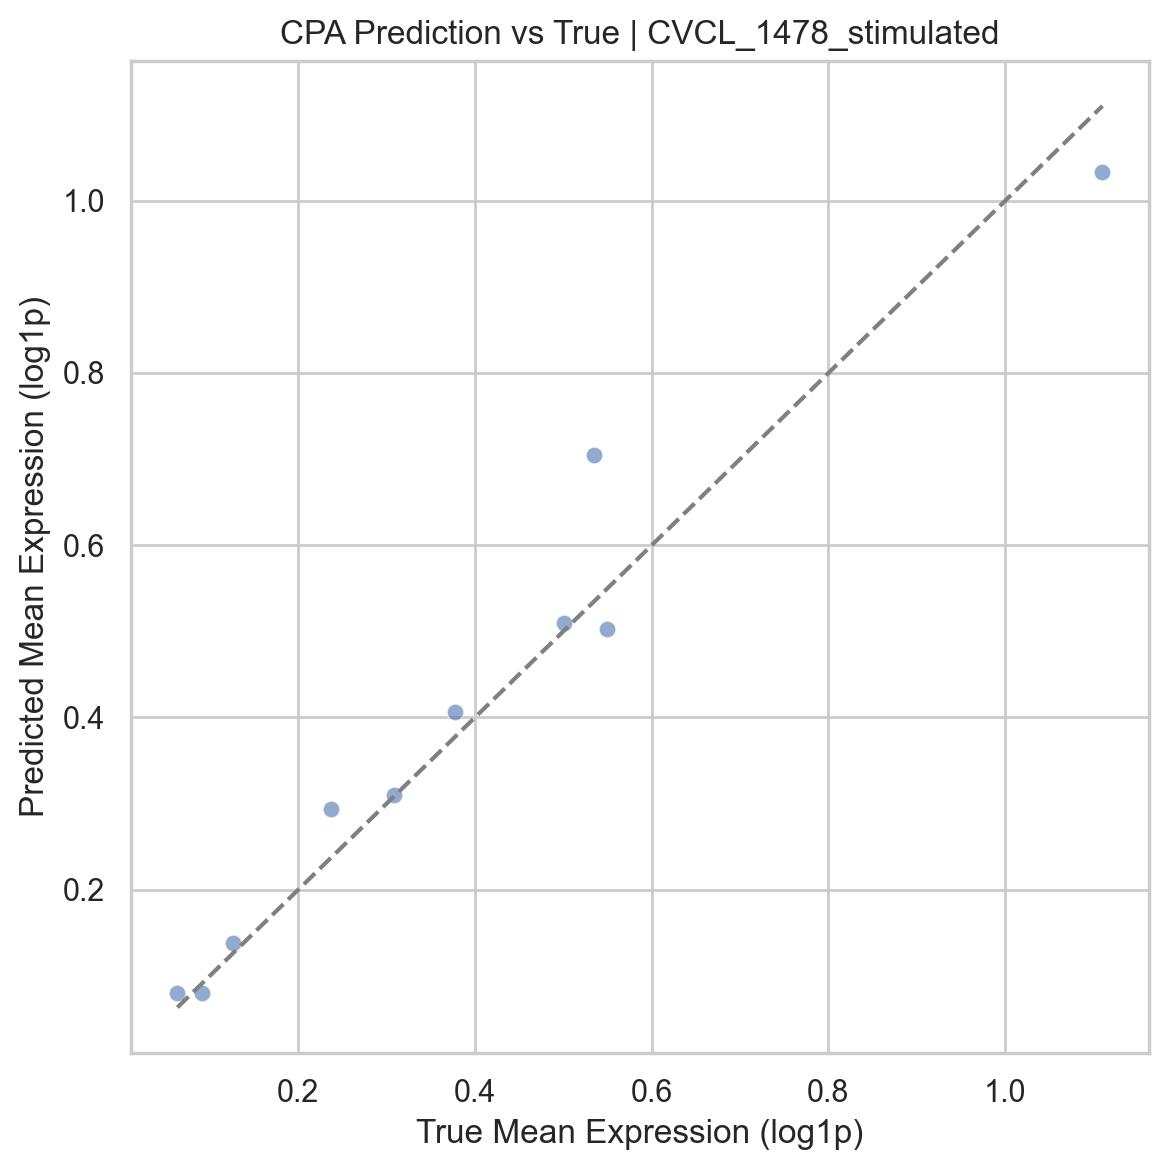

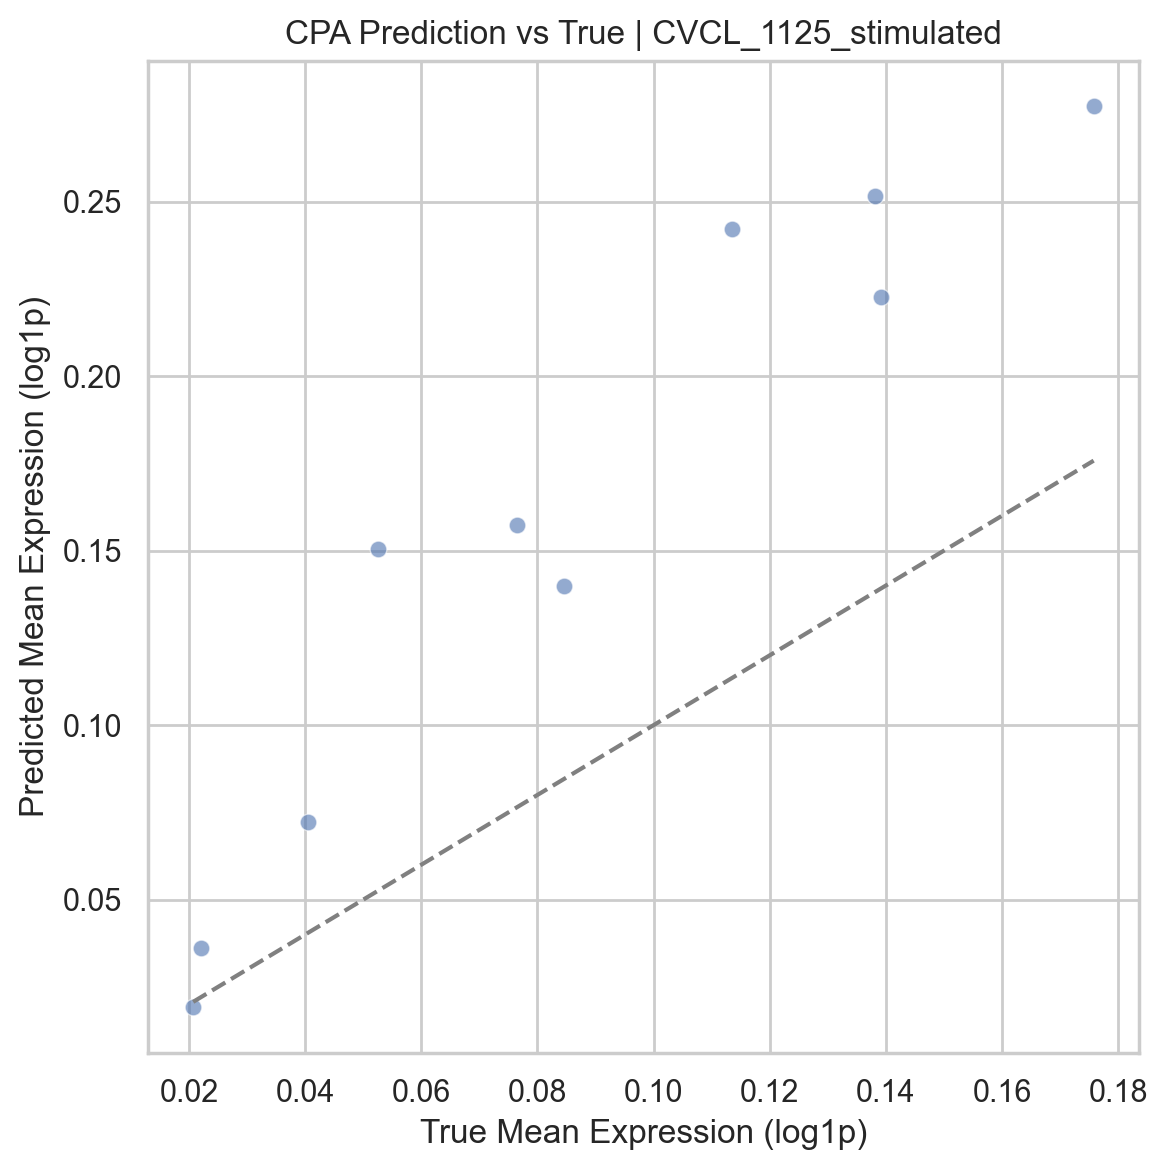

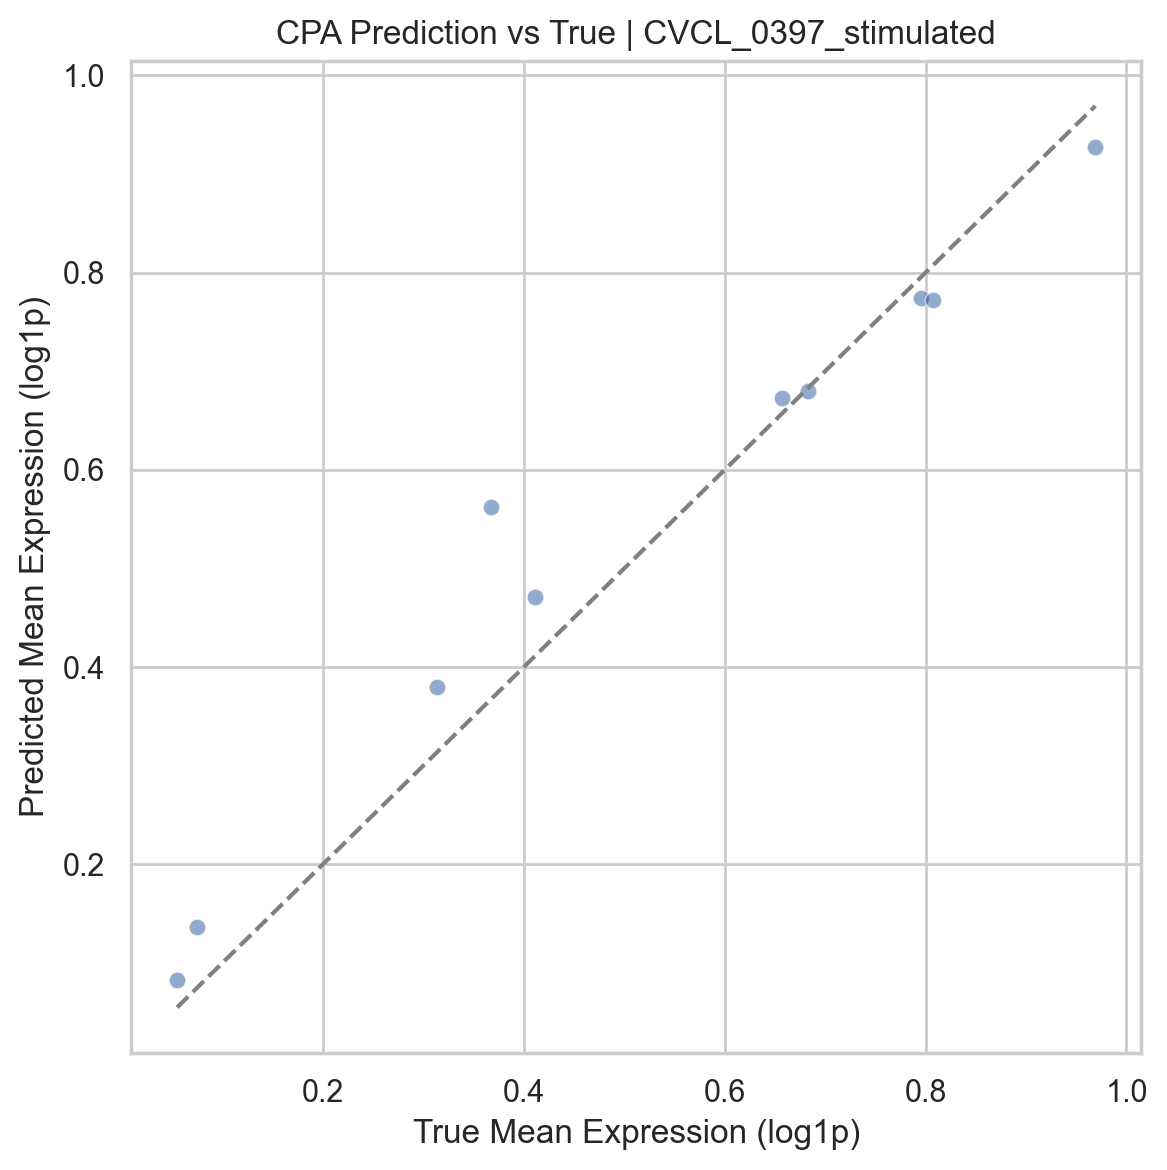

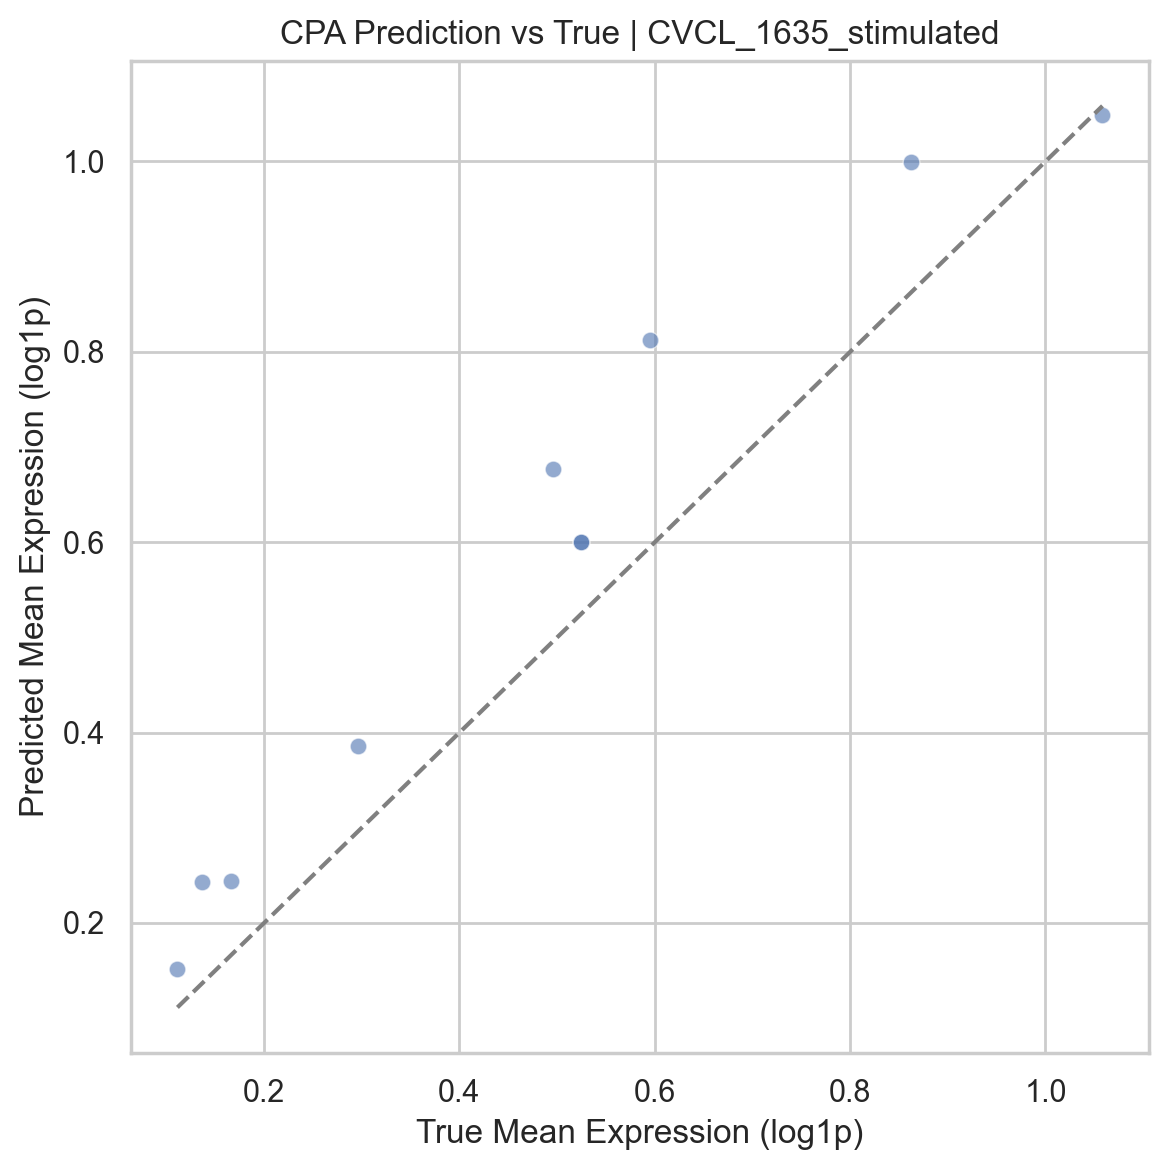

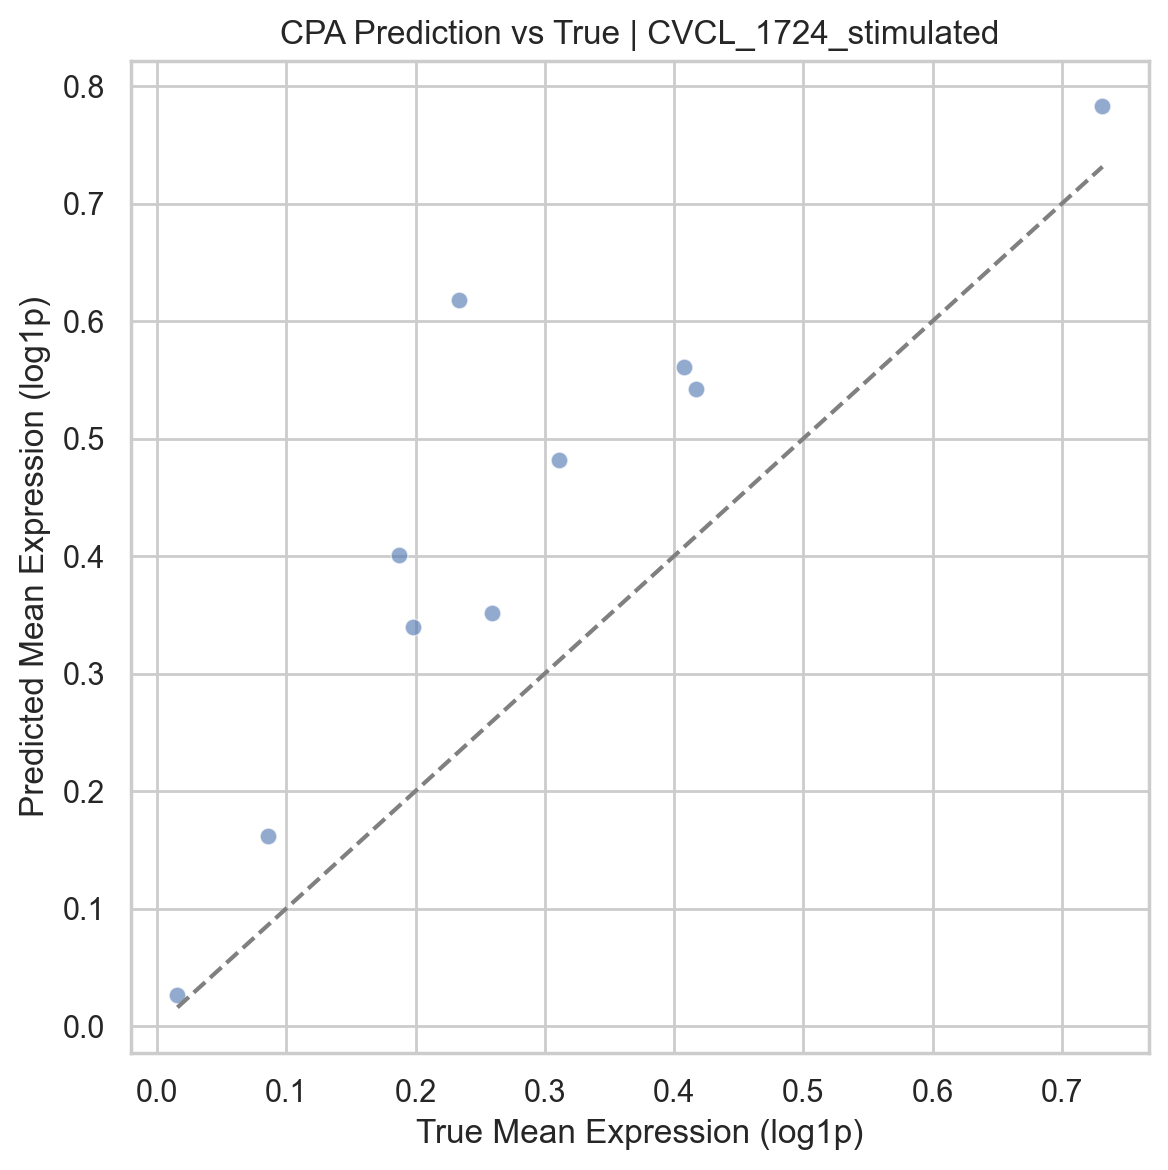

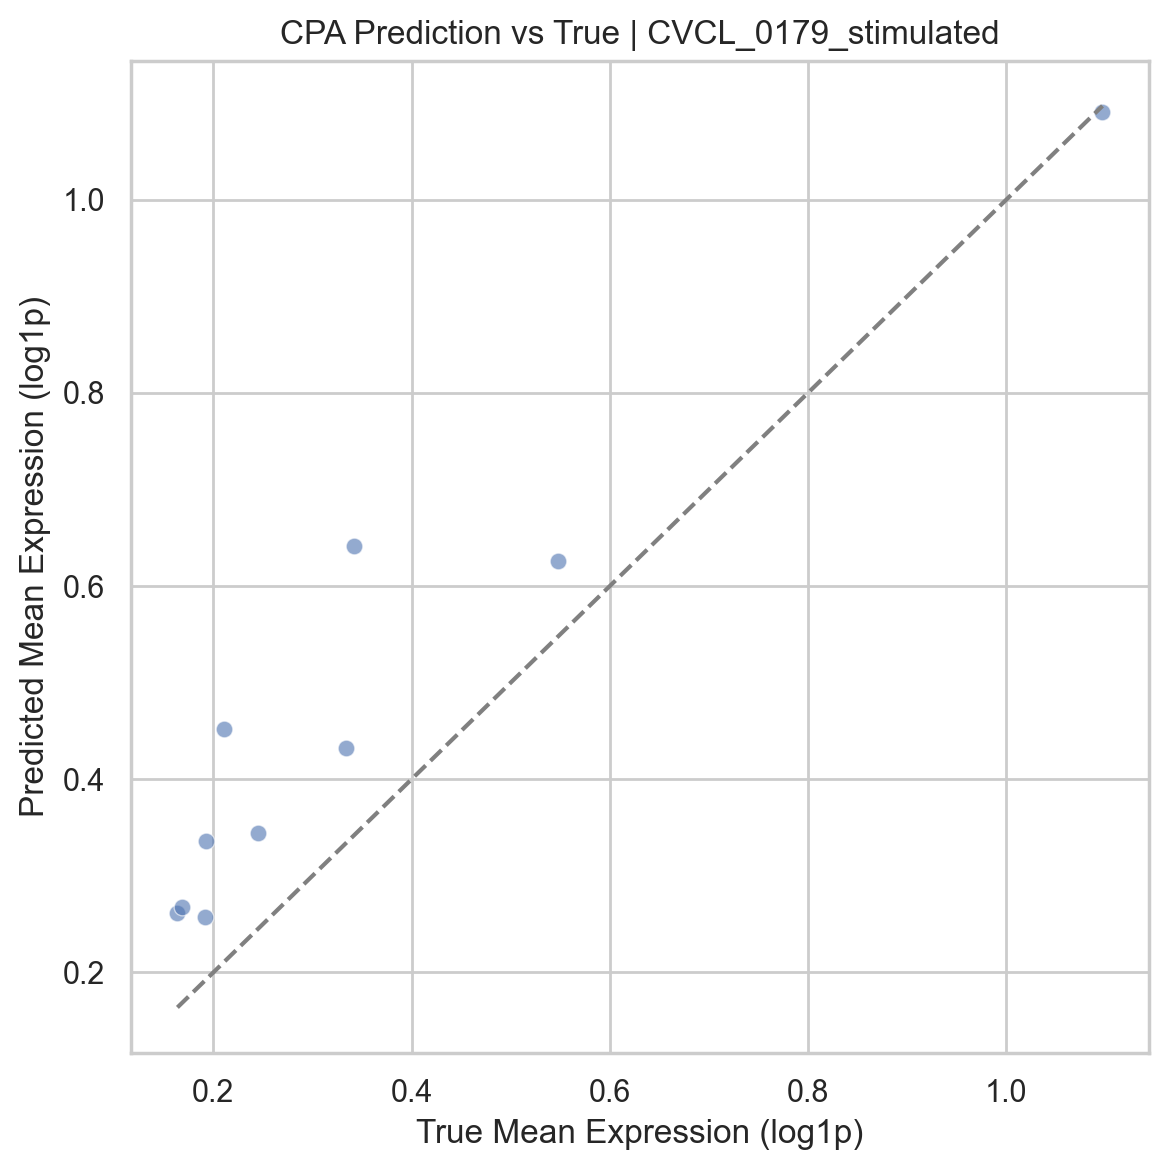

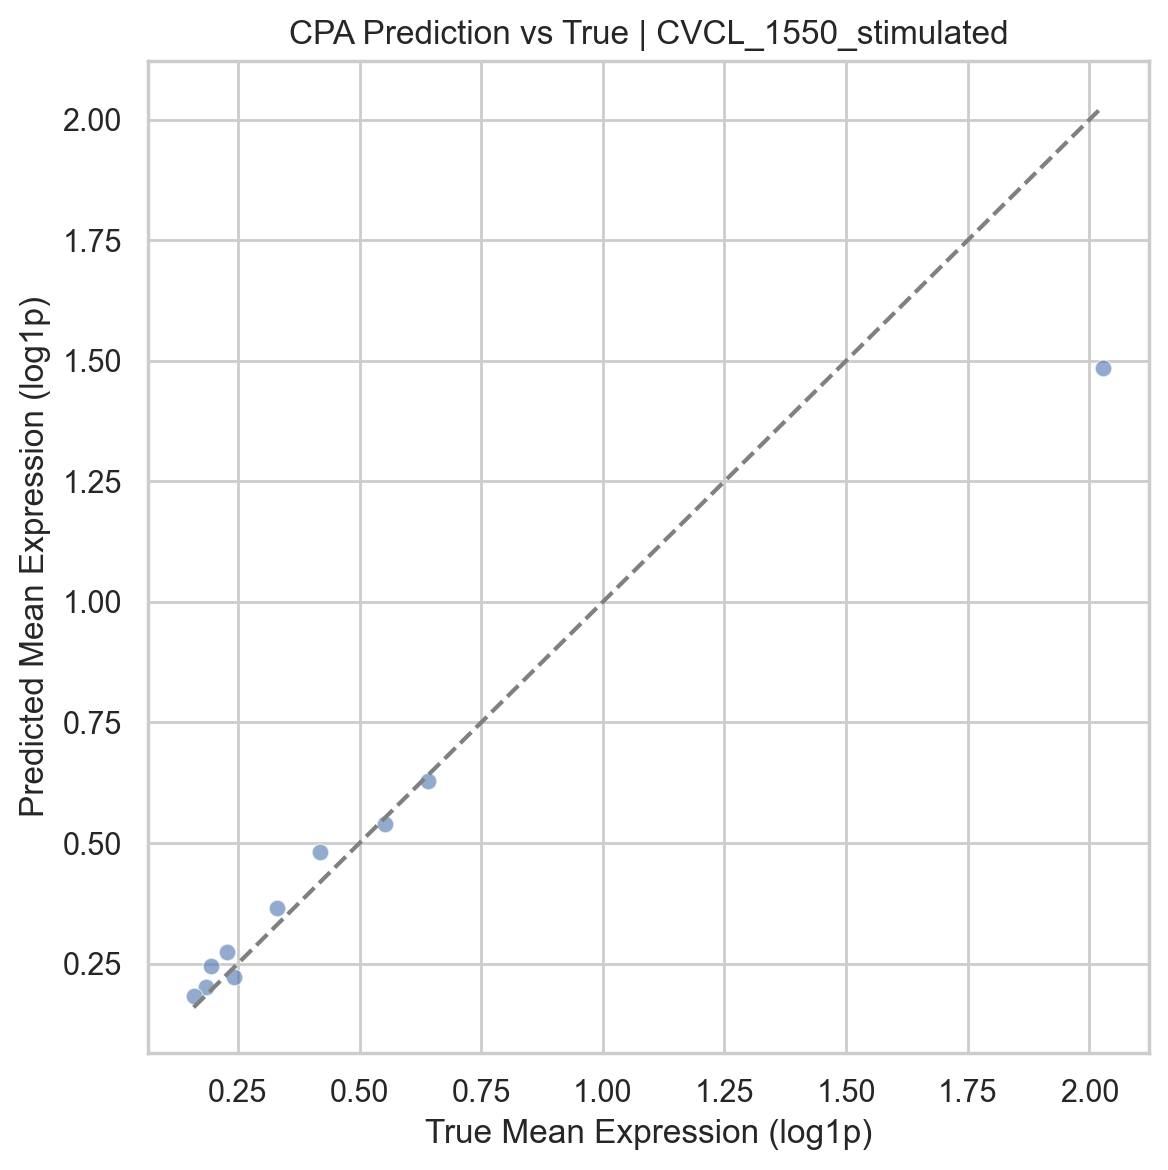

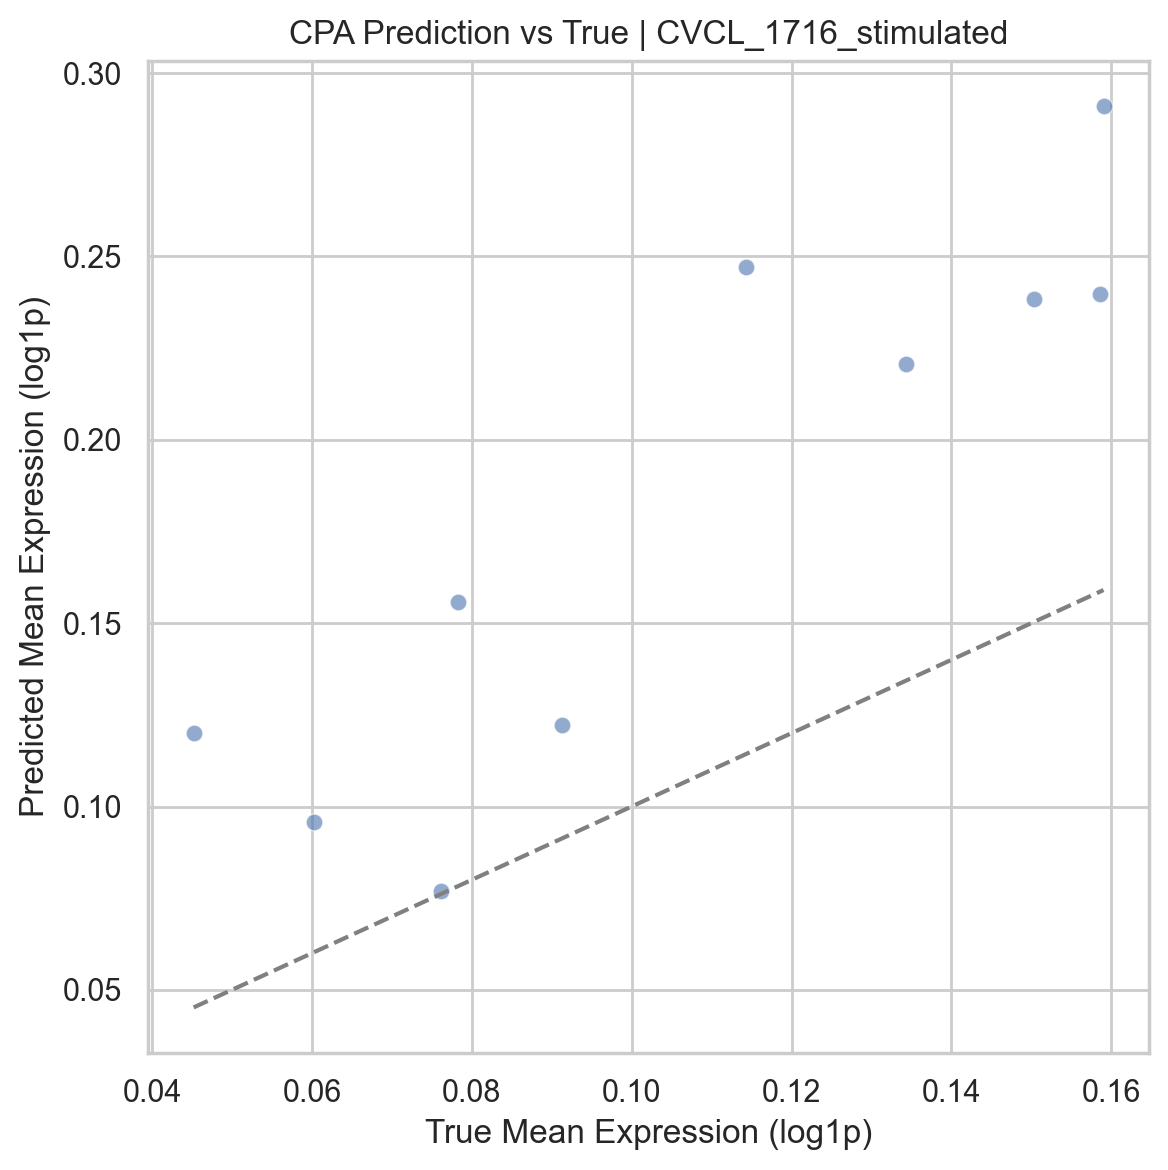

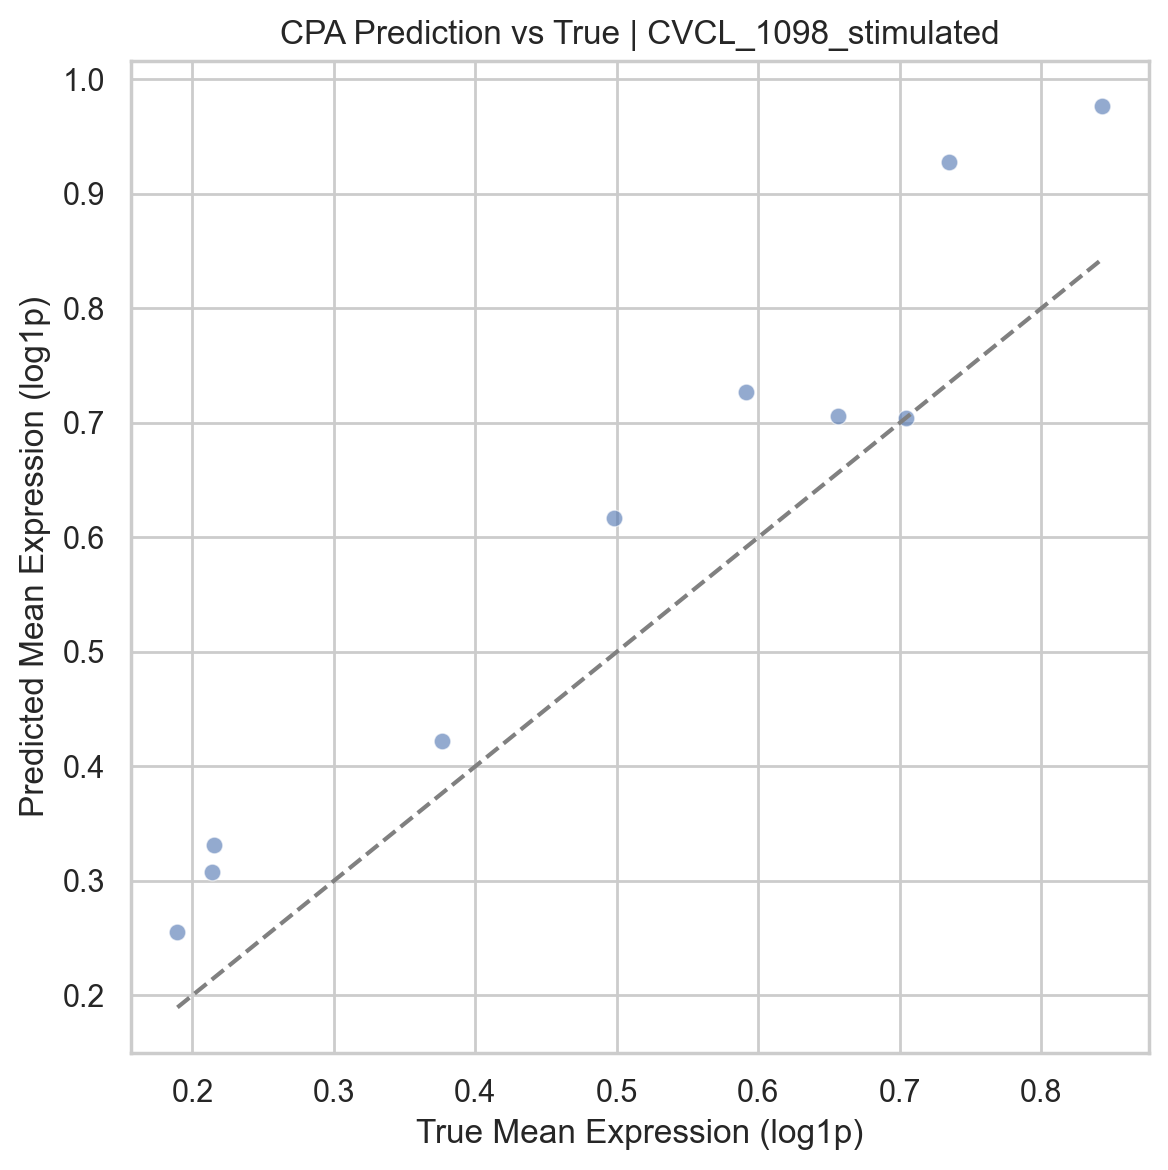

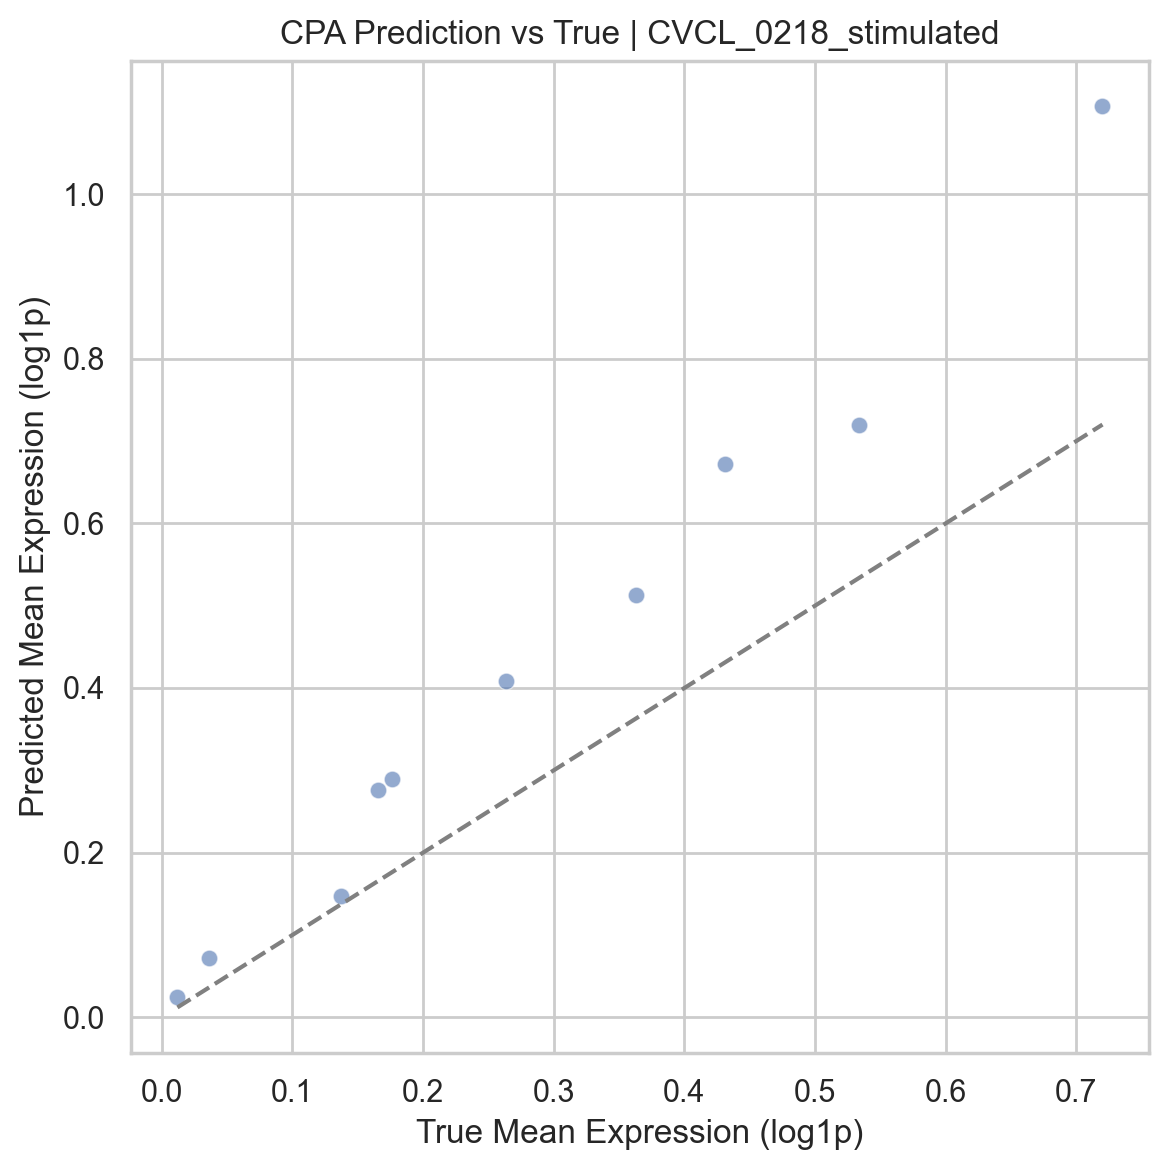

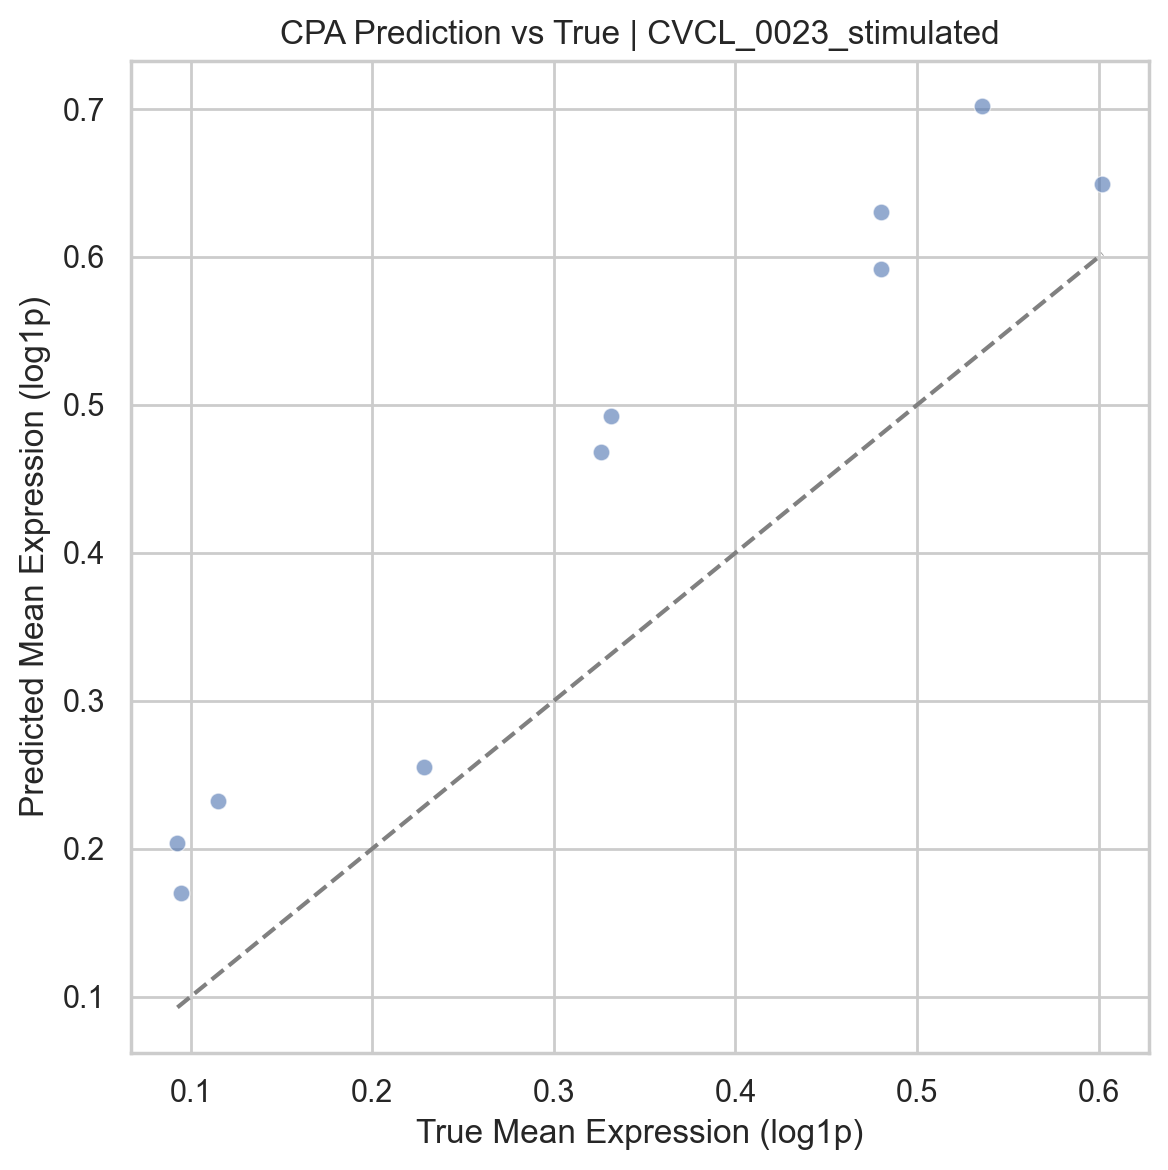

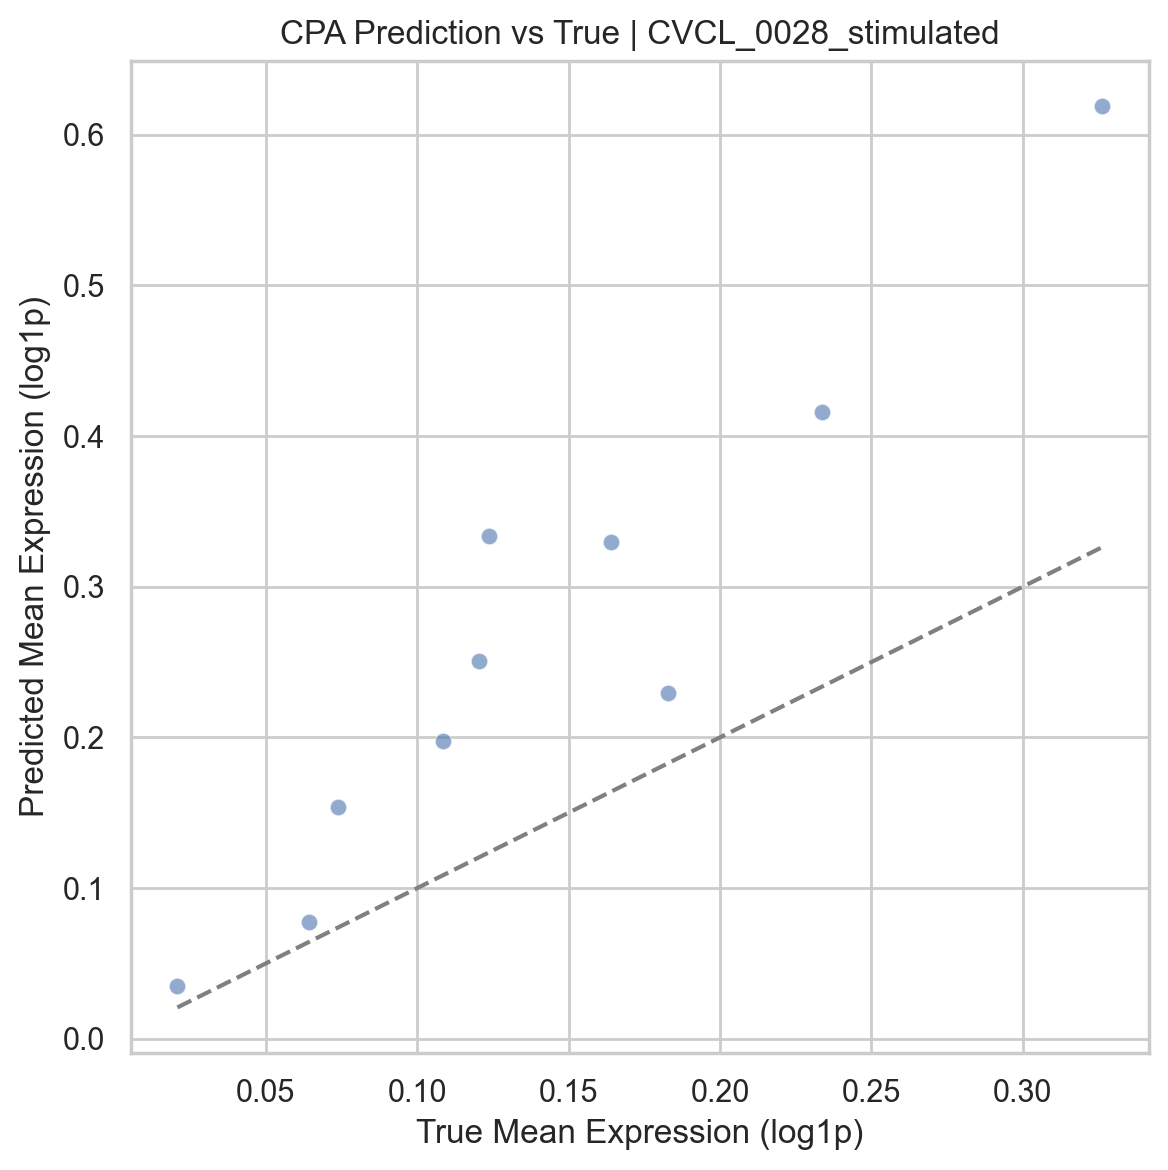

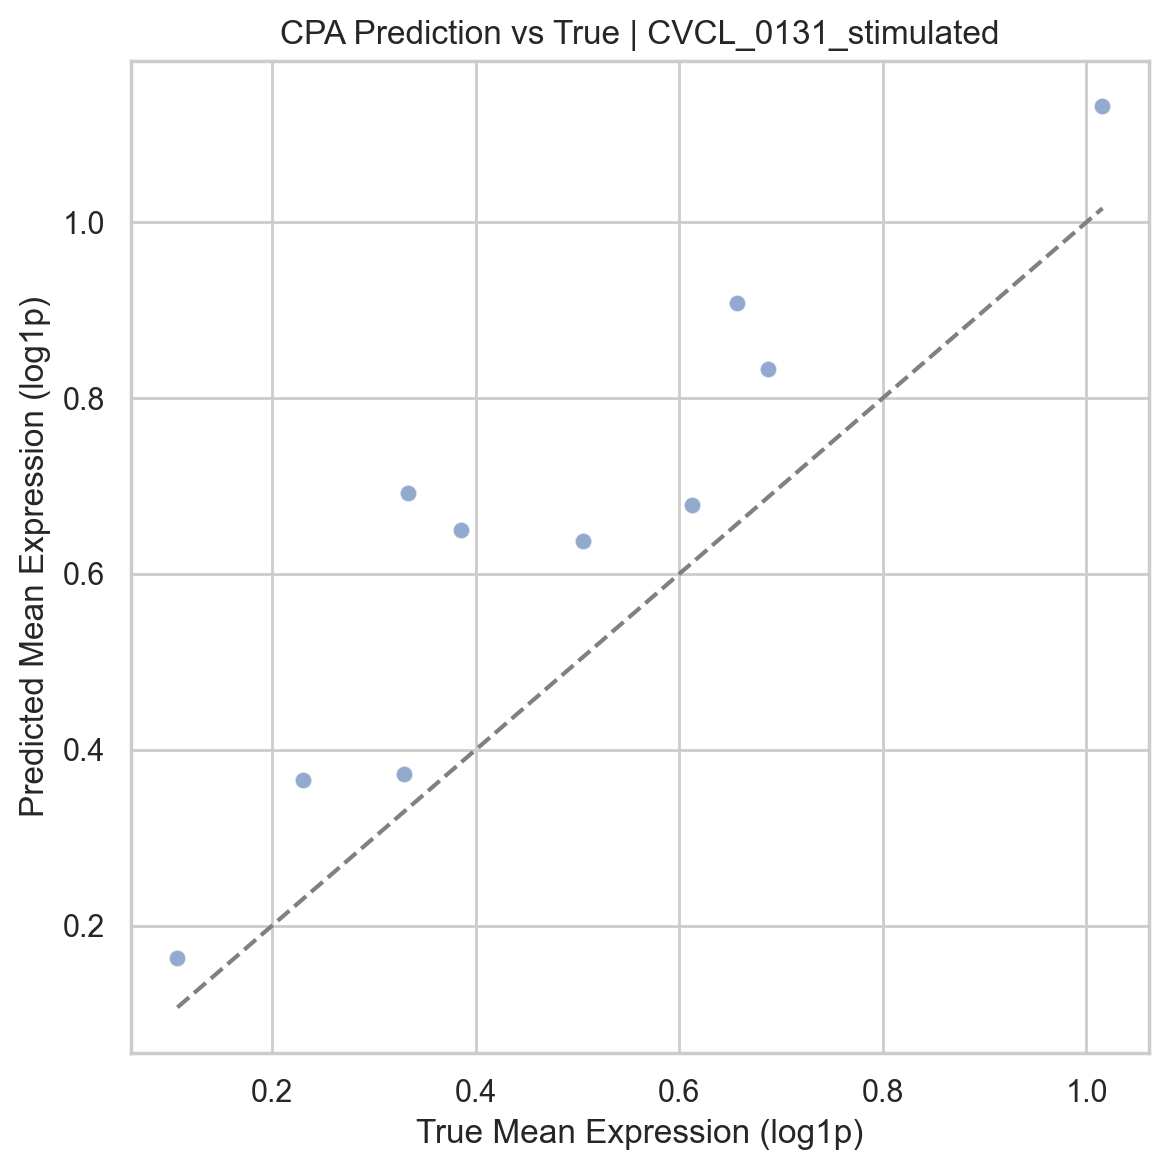

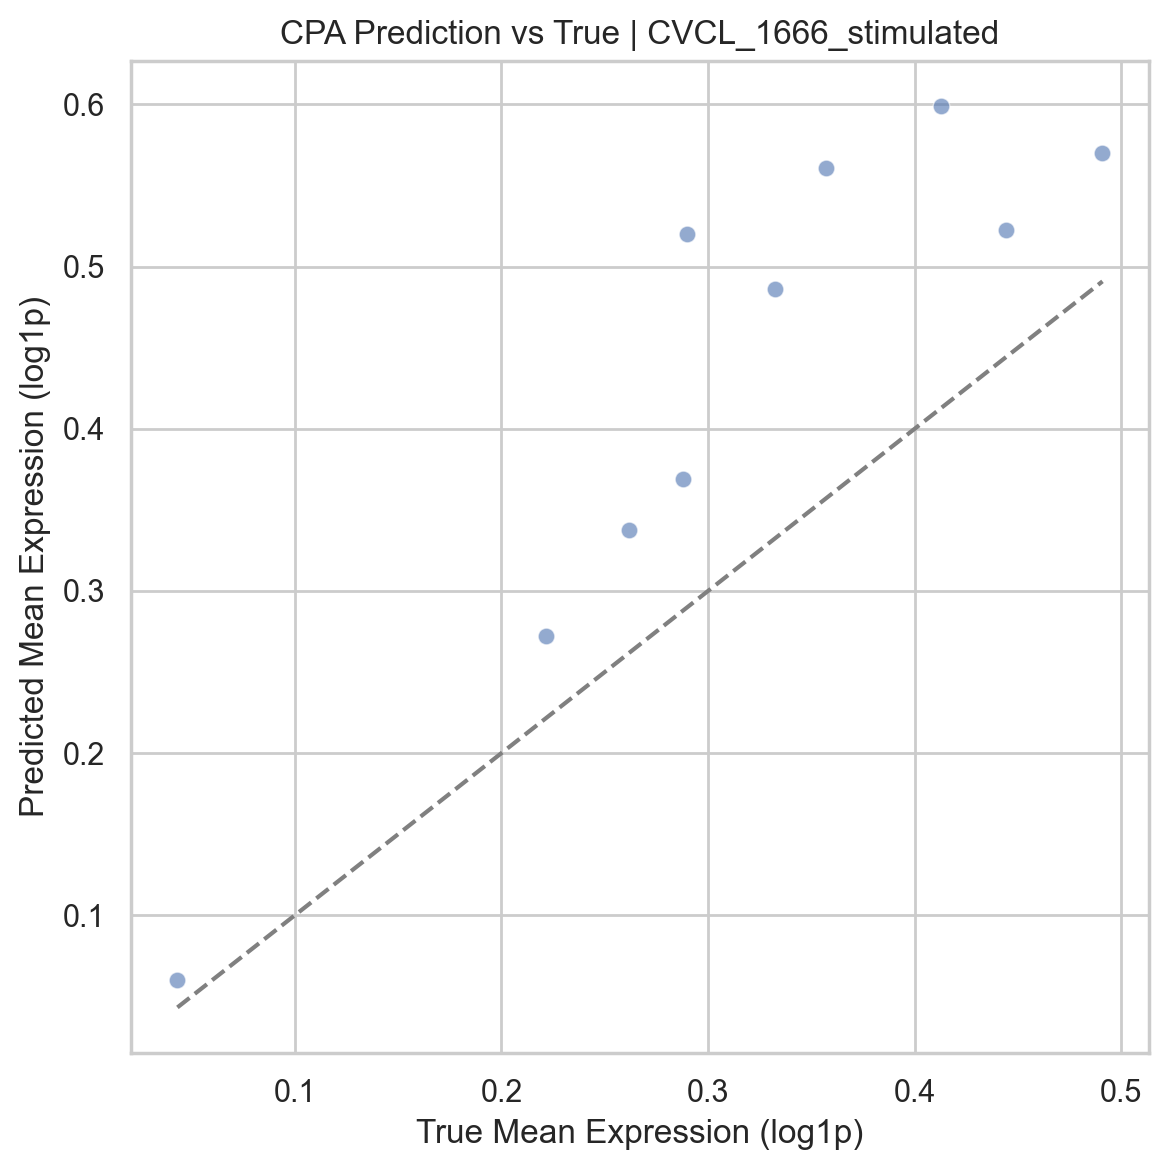

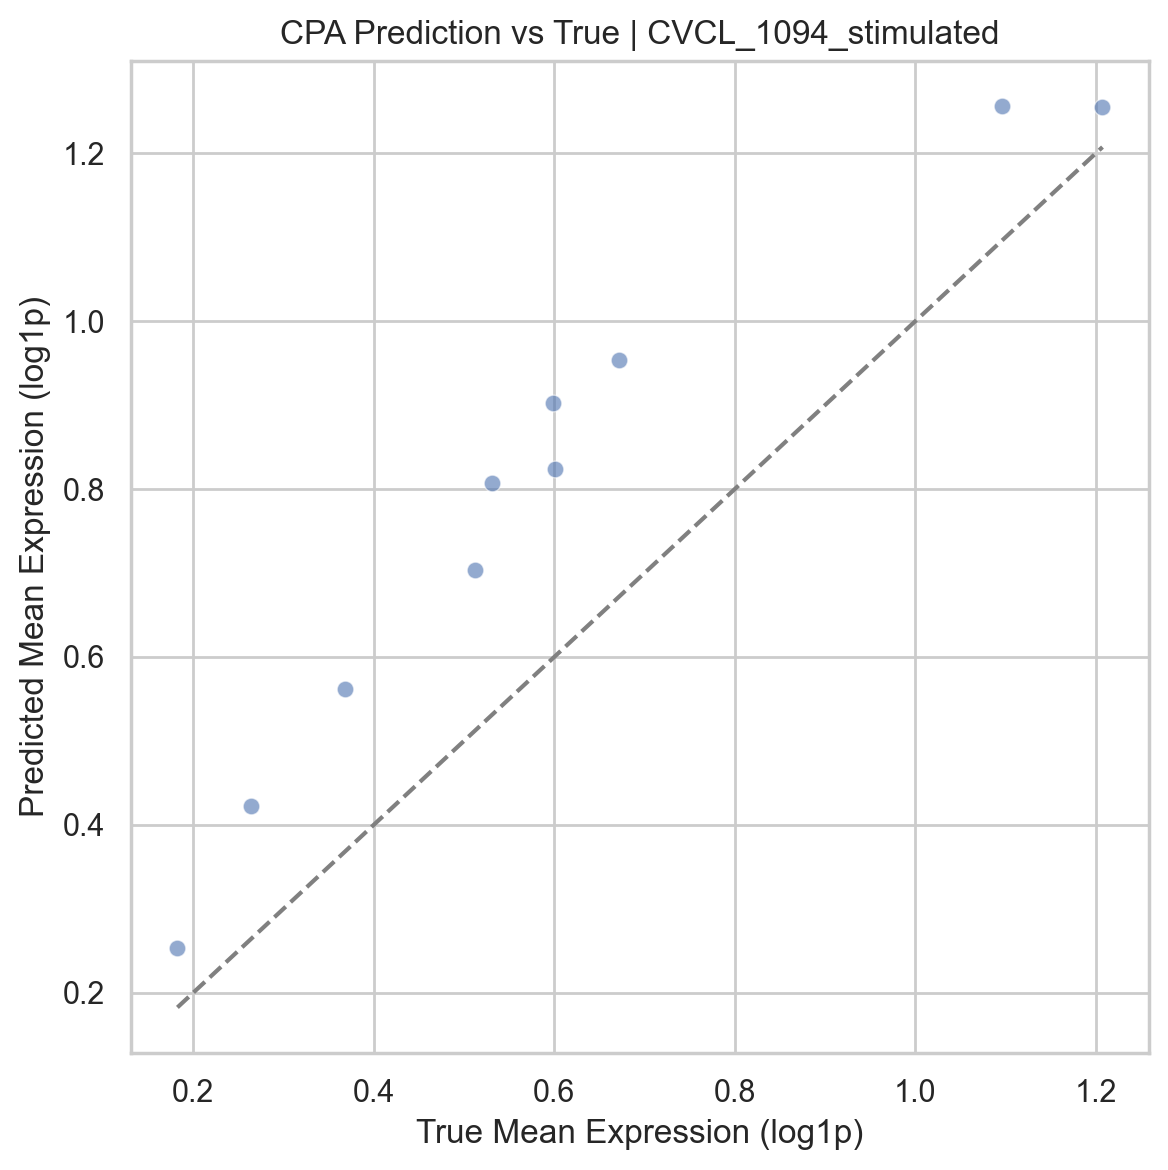

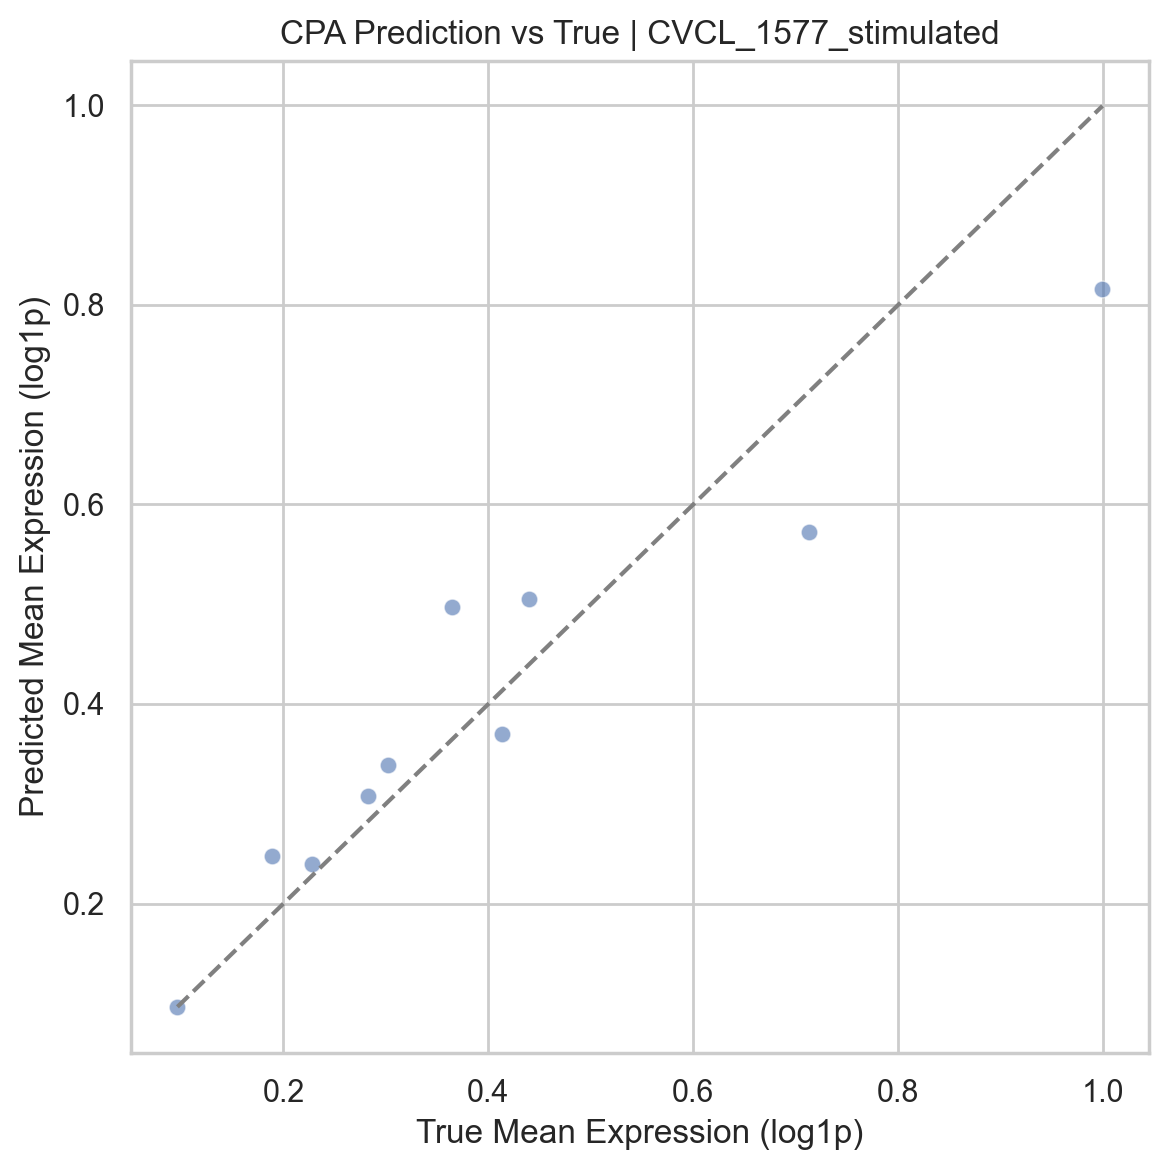

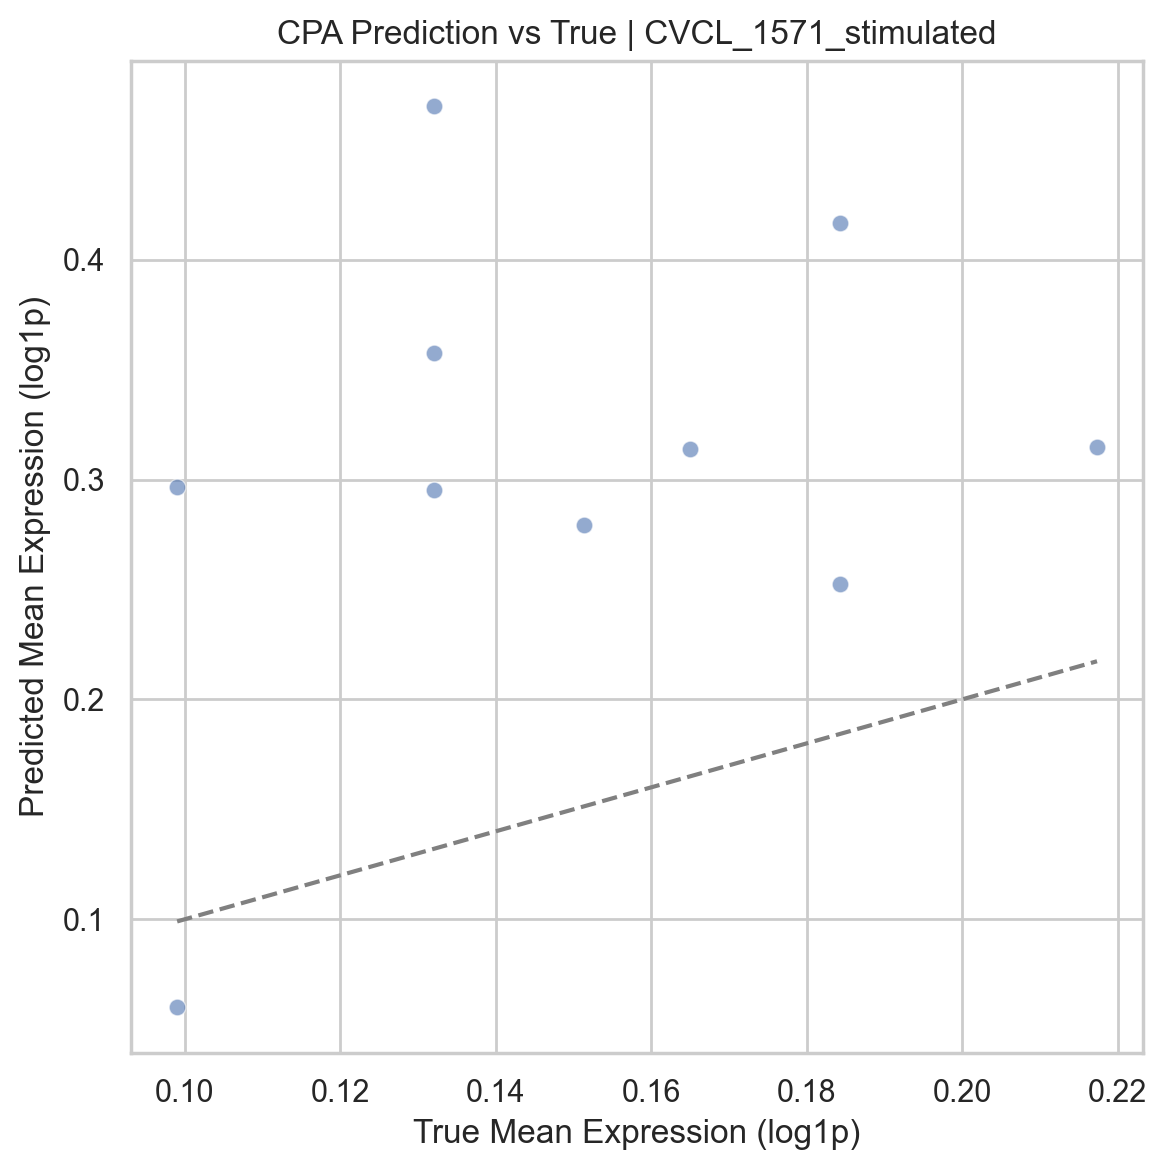

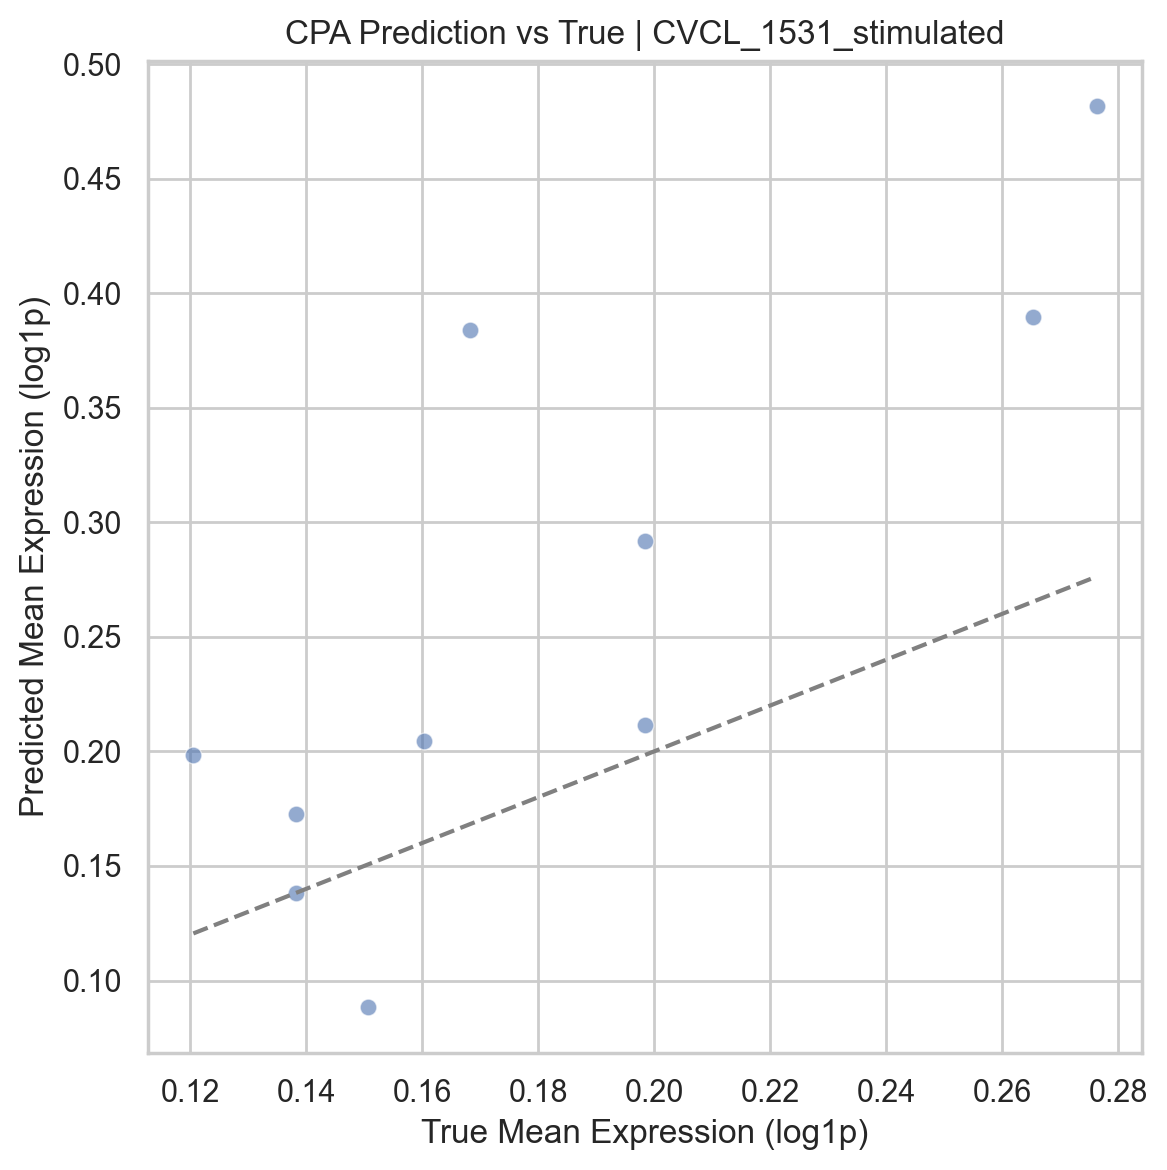

In [30]:
# Loop through all stimulated conditions
for cat in adata.obs['cov_cond'].unique():
    if 'stimulated' not in cat:
        continue

    # Get control condition
    cov, condition = cat.rsplit('_', 1)
    deg_cat = f'{cat}'
    deg_list = adata.uns['rank_genes_groups'][deg_cat]['names']
    degs = np.where(np.isin(adata.var_names, deg_list[:10]))[0]  # Top 10 DEGs

    if len(degs) == 0:
        print(f"No DEGs found for {cat}")
        continue

    # Extract adatas
    cat_adata = adata[adata.obs['cov_cond'] == cat]
    x_true = cat_adata.layers['counts']
    x_pred = cat_adata.obsm['CPA_pred']

    # Log1p transform if needed
    x_true = np.log1p(x_true)
    x_pred = np.log1p(x_pred)

    # Subset to DEGs
    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]

    # Convert mean to dense arrays
    true_mean = np.asarray(x_true_deg.mean(0)).flatten()
    pred_mean = np.asarray(x_pred_deg.mean(0)).flatten()

    # Plot
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=true_mean, y=pred_mean, alpha=0.6)
    plt.plot([true_mean.min(), true_mean.max()],
             [true_mean.min(), true_mean.max()],
             linestyle='--', color='gray')
    plt.xlabel("True Mean Expression (log1p)")
    plt.ylabel("Predicted Mean Expression (log1p)")
    plt.title(f"CPA Prediction vs True | {cat}")
    plt.tight_layout()
    plt.show()
